In [1]:
import numpy as np
from scipy.integrate import trapz, cumtrapz
from scipy.interpolate import interpn
import astropy.constants as const
import astropy.units as u

from IPython.display import display, Math

import h5py

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from matplotlib import ticker
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.image as mpimg
from skimage.measure import marching_cubes, marching_cubes_lewiner
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource
%matplotlib inline
sns.set_context("talk", font_scale=1.2)
sns.set_style('ticks')
sns.set_palette('colorblind')
figparams = {'font.family': 'DejaVu Sans',
             'font.serif':'Times',
             'text.latex.preamble': r'\usepackage{amsmath}',
             'text.usetex': True,
             'hatch.linewidth' : 3.0}
plt.rcParams.update(figparams)
clr = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
# Global variables
n_samples = int(2 ** 10)
n_mesh = int(2 ** 5)
n_resample = int(2 ** 8)
print(n_samples, n_mesh, n_resample)

label_fsize = 50

1024 32 256


In [4]:
fidhz = 1 / u.yr
coeffs = 4. * const.G ** (5. / 3.) / (3. * np.pi ** (1. / 3.)
                                          * (const.c ** 2)
                                          * (fidhz ** (4. / 3.)))

In [5]:
log_m_min = 7

In [6]:
NANOGrav_hc = 1.9e-15
IPTA_hc = 3.20e-15

# Load data

## AGN-based model

In [7]:
with h5py.File('../data/processed/agn_proxy.h5', 'r') as hf:
    log_m_bh_norm_min = hf['log_m_bh_norm_min'][()]
    log_m_bh_norm_max = hf['log_m_bh_norm_max'][()]
    log_m_bh_range = hf['log_m_bh_range'][:]
    z_range = hf['z_range'][:]
    q_range = hf['q_range'][:]
    differential_bhb_population = hf['population'][:]
    hc = hf['characteristic_strain'][:]
    local_bhmf = hf['local_bhmf'][:]

### Number density

In [8]:
differential_number_density = trapz(trapz(differential_bhb_population[log_m_bh_range >= log_m_bh_norm_min],
                                          log_m_bh_range[log_m_bh_range >= log_m_bh_norm_min], axis=0), q_range, axis=1)
differential_number_density_q = np.quantile(differential_number_density, q=[.16, .5, .84], axis=-1)

In [9]:
local_number_density = differential_number_density_q[:, 0]

order = 10. ** np.floor(np.log10(local_number_density[1]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(local_number_density[1] / order,
                     (local_number_density[2] - local_number_density[1]) / order,
                     (local_number_density[1] - local_number_density[0]) / order,
                     np.log10(order))))

local_number_density = local_number_density[1]

<IPython.core.display.Math object>

## AGN-based model with Kormendy & Ho (2013)

In [10]:
with h5py.File('../data/processed/agn_proxy_kh.h5', 'r') as hf:
    log_m_bh_range_kh = hf['log_m_bh_range'][:]
    differential_bhb_population_kh = hf['population'][:]
    hc_kh = hf['characteristic_strain'][:]
    local_bhmf_kh = hf['local_bhmf'][:]

### Number density

In [11]:
differential_number_density_kh = trapz(trapz(differential_bhb_population_kh[log_m_bh_range_kh >= log_m_min],
                                             log_m_bh_range[log_m_bh_range_kh >= log_m_min], axis=0), q_range, axis=1)
differential_number_density_kh_q = np.quantile(differential_number_density_kh, q=[.16, .5, .84], axis=-1)

In [12]:
local_number_density_kh = differential_number_density_kh_q[:, 0]

order = 10. ** np.floor(np.log10(local_number_density_kh[1]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(local_number_density_kh[1] / order,
                     (local_number_density_kh[2] - local_number_density_kh[1]) / order,
                     (local_number_density_kh[1] - local_number_density_kh[0]) / order,
                     np.log10(order))))

local_number_density_kh = local_number_density_kh[1]

<IPython.core.display.Math object>

## S1

In [13]:
# the mass and the mass ratio ranges for all models are shared, so we will only load them once
with h5py.File('../data/processed/S1.h5', 'r') as hf:
    z_range_borch = hf['z_range'][:]
    S1_bhb_population = hf['population'][:]
    S1_hc = hf['characteristic_strain'][:]
    S1_local_bhmf = hf['local_bhmf'][:]

### Number density

In [14]:
S1_number_density = trapz(trapz(S1_bhb_population[log_m_bh_range >= log_m_min],
                                          log_m_bh_range[log_m_bh_range >= log_m_min], axis=0), q_range, axis=1)
S1_number_density_q = np.quantile(S1_number_density, q=[.16, .5, .84], axis=-1)

In [15]:
S1_local_number_density = S1_number_density_q[:, 0]

order = 10. ** np.floor(np.log10(S1_local_number_density[1]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S1}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S1_local_number_density[1] / order,
                     (S1_local_number_density[2] - S1_local_number_density[1]) / order,
                     (S1_local_number_density[1] - S1_local_number_density[0]) / order,
                     np.log10(order))))

S1_local_number_density = S1_local_number_density[1]

<IPython.core.display.Math object>

## S2

In [16]:
with h5py.File('../data/processed/S2.h5', 'r') as hf:
    z_range_drory = hf['z_range'][:]
    S2_bhb_population = hf['population'][:]
    S2_hc = hf['characteristic_strain'][:]
    S2_number_density = hf['number_density'][:]
    S2_local_bhmf = hf['local_bhmf'][:]

### Number density

In [17]:
S2_number_density = trapz(trapz(S2_bhb_population[log_m_bh_range >= log_m_min],
                                          log_m_bh_range[log_m_bh_range >= log_m_min], axis=0), q_range, axis=1)
S2_number_density_q = np.quantile(S2_number_density, q=[.16, .5, .84], axis=-1)

In [18]:
S2_local_number_density = S2_number_density_q[:, 0]

order = 10. ** np.floor(np.log10(S2_local_number_density[1]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S1}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S2_local_number_density[1] / order,
                     (S2_local_number_density[2] - S2_local_number_density[1]) / order,
                     (S2_local_number_density[1] - S2_local_number_density[0]) / order,
                     np.log10(order))))

S2_local_number_density = S2_local_number_density[1]

<IPython.core.display.Math object>

## S3

In [19]:
with h5py.File('../data/processed/S3.h5', 'r') as hf:
    z_range_ilbert = hf['z_range'][:]
    S3_bhb_population = hf['population'][:]
    S3_hc = hf['characteristic_strain'][:]
    S3_number_density = hf['number_density'][:]
    S3_local_bhmf = hf['local_bhmf'][:]

### Number density

In [20]:
S3_number_density = trapz(trapz(S3_bhb_population[log_m_bh_range >= log_m_min],
                                          log_m_bh_range[log_m_bh_range >= log_m_min], axis=0), q_range, axis=1)
S3_number_density_q = np.quantile(S3_number_density, q=[.16, .5, .84], axis=-1)

In [21]:
S3_local_number_density = S3_number_density_q[:, 0]

order = 10. ** np.floor(np.log10(S3_local_number_density[1]))
display(Math(r'\Phi_{{\rm{{BHB}}, 0, \rm{{S1}}}} = ({0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}) \times 10^{{{3}}}\;\rm{{Mpc}}^{{-3}}'
             .format(S3_local_number_density[1] / order,
                     (S3_local_number_density[2] - S3_local_number_density[1]) / order,
                     (S3_local_number_density[1] - S3_local_number_density[0]) / order,
                     np.log10(order))))

S3_local_number_density = S3_local_number_density[1]

<IPython.core.display.Math object>

# Analysis

In [22]:
differential_bhb_population = differential_bhb_population[(log_m_bh_range != log_m_bh_norm_min)
                                                          & (log_m_bh_range != log_m_bh_norm_max)]
S1_bhb_population = S1_bhb_population[(log_m_bh_range != log_m_bh_norm_min)
                                      & (log_m_bh_range != log_m_bh_norm_max)]
S2_bhb_population = S2_bhb_population[(log_m_bh_range != log_m_bh_norm_min)
                                      & (log_m_bh_range != log_m_bh_norm_max)]
S3_bhb_population = S3_bhb_population[(log_m_bh_range != log_m_bh_norm_min)
                                      & (log_m_bh_range != log_m_bh_norm_max)]
log_m_bh_range = log_m_bh_range[(log_m_bh_range != log_m_bh_norm_min) & (log_m_bh_range != log_m_bh_norm_max)]

## AGN-based model

In [23]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range, q_range, indexing='ij')

In [24]:
hc_integrand = (coeffs * differential_bhb_population * ((10 ** (mm * (5 / 3)))
                                              * (qq / ((1 + qq) ** (1 / 3)))
                                              / ((1 + zz) ** (1 / 3)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [25]:
hc_bounds = np.sqrt(cumtrapz(cumtrapz(cumtrapz(hc_integrand[::-1, :, ::-1, :].to(''),
                                               log_m_bh_range[::-1], axis=0, initial=0),
                                      z_range, axis=1, initial=0),
                             q_range[::-1], axis=2, initial=0))

hc_q_bounds = np.quantile(hc_bounds, q=[.16, .5, .84], axis=-1)

In [26]:
z_sat = z_range[hc_q_bounds[1, -1, :, -1] >= 0.95 * hc_q_bounds[1, -1, -1, -1]][0]
# log_m_sat = log_m_bh_range[::-1][(hc_q_bounds[1, :, -1, -1] >= 0.95 * hc_q_bounds[1, -1, -1, -1])][0]
log_m_sat = log_m_bh_range[log_m_bh_range <= 8][-1]

hc_sat = hc_q_bounds[1, -1, -1, -1]

log_m_bh_range_zoom = log_m_bh_range[::-1][1:]
log_m_bh_range_zoom = log_m_bh_range_zoom[log_m_bh_range_zoom >= log_m_sat]

z_range_zoom = z_range[(z_range >= 1) & (z_range <= z_sat)]

In [27]:
log_m_bh_range_zoom

array([9.90322581, 9.80645161, 9.70967742, 9.61290323, 9.51612903,
       9.41935484, 9.32258065, 9.22580645, 9.12903226, 9.03225806,
       8.93548387, 8.83870968, 8.74193548, 8.64516129, 8.5483871 ,
       8.4516129 , 8.35483871, 8.25806452, 8.16129032, 8.06451613,
       7.96774194])

In [28]:
z_sat, log_m_sat

(2.5161290322580645, 7.967741935483871)

### NANOGrav

In [29]:
NANOGrav_n_artificial_range = np.sqrt(np.logspace(-1.5, 1.5, num=n_mesh))

# multiplying factor for the number density, which goes as hc**2
NANOGrav_mult_factor = 1  # (NANOGrav_hc / (.95 * hc_sat)) ** 2  
NANOGrav_mult_factor_sqrt = np.sqrt(NANOGrav_mult_factor)
NANOGrav_n_artificial_range = np.sort(np.append(NANOGrav_n_artificial_range, NANOGrav_mult_factor_sqrt))

In [30]:
NANOGrav_mult_factor

1

In [31]:
NANOGrav_hc_cube = hc_bounds[:, (z_range >= 1) & (z_range <= z_sat), -1, :]
NANOGrav_hc_cube = NANOGrav_hc_cube[1:, :]
NANOGrav_hc_cube = NANOGrav_hc_cube[log_m_bh_range[::-1][1:] >= log_m_sat, ...]
NANOGrav_hc_cube = np.quantile(NANOGrav_hc_cube, q=.5, axis=-1)
NANOGrav_hc_cube = NANOGrav_hc_cube[..., np.newaxis] * NANOGrav_n_artificial_range[np.newaxis, np.newaxis, :]

NANOGrav_mm_cube = mm[:, (z_range >= 1) & (z_range <= z_sat), -1]
NANOGrav_mm_cube = NANOGrav_mm_cube[::-1, ...]
NANOGrav_mm_cube = NANOGrav_mm_cube[1:, ...]
NANOGrav_mm_cube = NANOGrav_mm_cube[log_m_bh_range[::-1][1:] >= log_m_sat, ...]
NANOGrav_mm_cube = np.repeat(NANOGrav_mm_cube[..., np.newaxis], len(NANOGrav_n_artificial_range), axis=-1)

NANOGrav_zz_cube = zz[:, (z_range >= 1) & (z_range <= z_sat), -1]
NANOGrav_zz_cube = NANOGrav_zz_cube[1:, :]
NANOGrav_zz_cube = NANOGrav_zz_cube[log_m_bh_range[::-1][1:] >= log_m_sat, ...]
NANOGrav_zz_cube = np.repeat(NANOGrav_zz_cube[..., np.newaxis], len(NANOGrav_n_artificial_range), axis=-1)

NANOGrav_nn_cube = local_number_density * (np.broadcast_to(NANOGrav_n_artificial_range[np.newaxis, np.newaxis, ...],
                                                           NANOGrav_hc_cube.shape) ** 2)

In [32]:
# 3D plot data
NANOGrav_log_n_new = np.log10(NANOGrav_mult_factor * local_number_density)
NANOGrav_log_n_range = np.log10(NANOGrav_nn_cube[0, 0, :])

# interpolate the samples to improve the look of the plot a bit
log_m_resample = np.linspace(log_m_bh_range_zoom.max(), log_m_bh_range_zoom.min(), num=n_resample)
z_resample = np.linspace(z_range_zoom.min(), z_range_zoom.max(), num=n_resample)
NANOGrav_log_n_resample = np.linspace(NANOGrav_log_n_range.min(), NANOGrav_log_n_range.max(), num=n_resample)
NANOGrav_log_n_resample = np.sort(np.append(NANOGrav_log_n_resample, NANOGrav_log_n_new))

m_spacing = log_m_resample[0] - log_m_resample[1]
z_spacing = z_resample[1] - z_resample[0]
NANOGrav_n_spacing = NANOGrav_log_n_resample[1] - NANOGrav_log_n_resample[0]

mm_rs, zz_rs, nn_rs = np.meshgrid(log_m_resample, z_resample, NANOGrav_log_n_resample, indexing='ij')
resample_points = np.array([mm_rs.ravel(), zz_rs.ravel(), nn_rs.ravel()]).T

NANOGrav_hc_resample = np.reshape(interpn(points=(log_m_bh_range_zoom[::-1], z_range_zoom, NANOGrav_log_n_range),
                                          values=NANOGrav_hc_cube, xi=resample_points), mm_rs.shape)

In [33]:
log_m_bh_range_zoom

array([9.90322581, 9.80645161, 9.70967742, 9.61290323, 9.51612903,
       9.41935484, 9.32258065, 9.22580645, 9.12903226, 9.03225806,
       8.93548387, 8.83870968, 8.74193548, 8.64516129, 8.5483871 ,
       8.4516129 , 8.35483871, 8.25806452, 8.16129032, 8.06451613,
       7.96774194])

In [34]:
NANOGrav_hc_cube.shape

(21, 16, 33)

In [35]:
NANOGrav_verts, _, _, _ = marching_cubes(NANOGrav_hc_resample, NANOGrav_hc, spacing=(m_spacing, z_spacing, NANOGrav_n_spacing))
NANOGrav_verts[:, 0] += log_m_bh_range_zoom[-1]
NANOGrav_verts[:, 1] += z_range_zoom[0]
NANOGrav_verts[:, 2] += NANOGrav_log_n_range[0]

NANOGrav_cube_top = NANOGrav_hc_resample[..., NANOGrav_log_n_resample >= NANOGrav_log_n_new]
NANOGrav_top_verts, _, _, _ = marching_cubes(NANOGrav_cube_top, NANOGrav_hc, spacing=(m_spacing, z_spacing, NANOGrav_n_spacing))
NANOGrav_top_verts[:, 0] += log_m_bh_range_zoom[-1]
NANOGrav_top_verts[:, 1] += z_range_zoom[0]
NANOGrav_top_verts[:, 2] -= NANOGrav_top_verts[:, 2].max() - NANOGrav_verts[:, 2].max()

NANOGrav_cube_bottom = NANOGrav_hc_resample[..., NANOGrav_log_n_resample <= NANOGrav_log_n_new]
if NANOGrav_cube_bottom.max() >= NANOGrav_hc:
    NANOGrav_bottom_verts, _, _, _ = marching_cubes(NANOGrav_cube_bottom, NANOGrav_hc, spacing=(m_spacing, z_spacing, NANOGrav_n_spacing))
    NANOGrav_bottom_verts[:, 0] += log_m_bh_range_zoom[-1]
    NANOGrav_bottom_verts[:, 1] += z_range_zoom[0]
    NANOGrav_bottom_verts[:, 2] += NANOGrav_log_n_range[0]
else:
    NANOGrav_bottom_verts = None

NANOGrav_xx_3d, NANOGrav_yy_3d = np.meshgrid(log_m_bh_range_zoom, z_range_zoom)
NANOGrav_zz_3d = NANOGrav_log_n_new * np.ones_like(NANOGrav_xx_3d)

In [36]:
NANOGrav_cube_bottom.max()

1.7699575830622536e-15

### IPTA

In [37]:
IPTA_n_artificial_range = np.sqrt(np.logspace(-1.5, 1.5, num=n_mesh))
IPTA_mult_factor = (IPTA_hc / (hc_sat)) ** 2
IPTA_mult_factor_sqrt = np.sqrt(IPTA_mult_factor)
IPTA_n_artificial_range = np.sort(np.append(IPTA_n_artificial_range, IPTA_mult_factor_sqrt))
IPTA_mult_factor

2.821006548260297

In [38]:
IPTA_hc_cube = hc_bounds[:, (z_range >= 1) & (z_range <= z_sat), -1, :]
IPTA_hc_cube = IPTA_hc_cube[1:, :]
IPTA_hc_cube = IPTA_hc_cube[log_m_bh_range[::-1][1:] >= log_m_sat, ...]
IPTA_hc_cube = np.quantile(IPTA_hc_cube, q=.5, axis=-1)
IPTA_hc_cube = IPTA_hc_cube[..., np.newaxis] * IPTA_n_artificial_range[np.newaxis, np.newaxis, :]

IPTA_mm_cube = mm[:, (z_range >= 1) & (z_range <= z_sat), -1]
IPTA_mm_cube = IPTA_mm_cube[::-1, ...]
IPTA_mm_cube = IPTA_mm_cube[1:, ...]
IPTA_mm_cube = IPTA_mm_cube[log_m_bh_range[::-1][1:] >= log_m_sat, ...]
IPTA_mm_cube = np.repeat(IPTA_mm_cube[..., np.newaxis], len(IPTA_n_artificial_range), axis=-1)

IPTA_zz_cube = zz[:, (z_range >= 1) & (z_range <= z_sat), -1]
IPTA_zz_cube = IPTA_zz_cube[1:, :]
IPTA_zz_cube = IPTA_zz_cube[log_m_bh_range[::-1][1:] >= log_m_sat, ...]
IPTA_zz_cube = np.repeat(IPTA_zz_cube[..., np.newaxis], len(IPTA_n_artificial_range), axis=-1)

IPTA_nn_cube = local_number_density * (np.broadcast_to(IPTA_n_artificial_range[np.newaxis, np.newaxis, ...],
                                                       IPTA_hc_cube.shape) ** 2)

In [39]:
# 3D plot data
IPTA_log_n_new = np.log10(IPTA_mult_factor * local_number_density)
IPTA_log_n_range = np.log10(IPTA_nn_cube[0, 0, :])

# interpolate the samples to improve the look of the plot a bit
log_m_resample = np.linspace(log_m_bh_range_zoom.max(), log_m_bh_range_zoom.min(), num=n_resample)
z_resample = np.linspace(z_range_zoom.min(), z_range_zoom.max(), num=n_resample)
IPTA_log_n_resample = np.linspace(IPTA_log_n_range.min(), IPTA_log_n_range.max(), num=n_resample)
IPTA_log_n_resample = np.sort(np.append(IPTA_log_n_resample, IPTA_log_n_new))

m_spacing = log_m_resample[0] - log_m_resample[1]
z_spacing = z_resample[1] - z_resample[0]
IPTA_n_spacing = IPTA_log_n_resample[1] - IPTA_log_n_resample[0]

mm_rs, zz_rs, nn_rs = np.meshgrid(log_m_resample, z_resample, IPTA_log_n_resample, indexing='ij')
resample_points = np.array([mm_rs.ravel(), zz_rs.ravel(), nn_rs.ravel()]).T

IPTA_hc_resample = np.reshape(interpn(points=(log_m_bh_range_zoom[::-1], z_range_zoom, IPTA_log_n_range),
                                          values=IPTA_hc_cube, xi=resample_points), mm_rs.shape)

In [40]:
IPTA_verts, _, _, _ = marching_cubes(IPTA_hc_resample, IPTA_hc, spacing=(m_spacing, z_spacing, IPTA_n_spacing))
IPTA_verts[:, 0] += log_m_bh_range_zoom[-1]
IPTA_verts[:, 1] += z_range_zoom[0]
IPTA_verts[:, 2] += IPTA_log_n_range[0]

IPTA_cube_top = IPTA_hc_resample[..., IPTA_log_n_resample >= IPTA_log_n_new]
IPTA_top_verts, _, _, _ = marching_cubes(IPTA_cube_top, IPTA_hc, spacing=(m_spacing, z_spacing, IPTA_n_spacing))
IPTA_top_verts[:, 0] += log_m_bh_range_zoom[-1]
IPTA_top_verts[:, 1] += z_range_zoom[0]
IPTA_top_verts[:, 2] -= IPTA_top_verts[:, 2].max() - IPTA_verts[:, 2].max()

IPTA_cube_bottom = IPTA_hc_resample[..., IPTA_log_n_resample <= IPTA_log_n_new]
if IPTA_cube_bottom.max() >= IPTA_hc:
    IPTA_bottom_verts, _, _, _ = marching_cubes(IPTA_cube_bottom, IPTA_hc, spacing=(m_spacing, z_spacing, IPTA_n_spacing))
    IPTA_bottom_verts[:, 0] += log_m_bh_range_zoom[-1]
    IPTA_bottom_verts[:, 1] += z_range_zoom[0]
    IPTA_bottom_verts[:, 2] += IPTA_log_n_range[0]
else:
    IPTA_bottom_verts = None

IPTA_xx_3d, IPTA_yy_3d = np.meshgrid(log_m_bh_range_zoom, z_range_zoom)
IPTA_zz_3d = IPTA_log_n_new * np.ones_like(IPTA_xx_3d)

## AGN-based model with Kormendy & Ho (2013)

In [41]:
mm, zz, qq = np.meshgrid(log_m_bh_range_kh, z_range, q_range, indexing='ij')

In [42]:
hc_integrand_kh = (coeffs * differential_bhb_population_kh * ((10 ** (mm * (5 / 3)))
                                              * (qq / ((1 + qq) ** (1 / 3)))
                                              / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [43]:
hc_bounds_kh = np.sqrt(cumtrapz(cumtrapz(cumtrapz(hc_integrand_kh[::-1, :, ::-1, :].to(''),
                                               log_m_bh_range_kh[::-1], axis=0, initial=0),
                                      z_range, axis=1, initial=0),
                             q_range[::-1], axis=2, initial=0))

hc_q_bounds_kh = np.quantile(hc_bounds_kh, q=[.16, .5, .84], axis=-1)

In [44]:
z_sat_kh = z_range[hc_q_bounds_kh[1, -1, :, -1] >= 0.95 * hc_q_bounds_kh[1, -1, -1, -1]][0]
log_m_sat_kh = log_m_bh_range_kh[::-1][(hc_q_bounds_kh[1, :, z_range == z_sat_kh, -1]
                                        >= 0.95 * hc_q_bounds_kh[1, -1, z_range == z_sat_kh, -1])[0]][0]

hc_sat_kh = hc_q_bounds_kh[1, log_m_bh_range_kh[::-1] == log_m_sat_kh, z_range == z_sat_kh, -1]

log_m_bh_range_zoom_kh = log_m_bh_range_kh[::-1][1:]
log_m_bh_range_zoom_kh = log_m_bh_range_zoom_kh[log_m_bh_range_zoom_kh >= log_m_sat_kh]

z_range_zoom_kh = z_range[(z_range >= 1) & (z_range <= z_sat_kh)]

### NANOGrav

In [45]:
NANOGrav_n_artificial_range_kh = np.sqrt(np.logspace(-1., 2., num=n_mesh))
NANOGrav_mult_factor_kh = (NANOGrav_hc / (.95 * hc_sat_kh[0])) ** 2
NANOGrav_mult_factor_sqrt_kh = np.sqrt(NANOGrav_mult_factor_kh)
NANOGrav_n_artificial_range_kh = np.sort(np.append(NANOGrav_n_artificial_range_kh, NANOGrav_mult_factor_sqrt_kh))
NANOGrav_mult_factor_kh

8.508073964185805

In [46]:
NANOGrav_hc_cube_kh = hc_bounds_kh[:, (z_range >= 1) & (z_range <= z_sat_kh), -1, :]
NANOGrav_hc_cube_kh = NANOGrav_hc_cube_kh[1:, :]
NANOGrav_hc_cube_kh = NANOGrav_hc_cube_kh[log_m_bh_range_kh[::-1][1:] >= log_m_sat_kh, ...]
NANOGrav_hc_cube_kh = np.quantile(NANOGrav_hc_cube_kh, q=.5, axis=-1)
NANOGrav_hc_cube_kh = NANOGrav_hc_cube_kh[..., np.newaxis] * NANOGrav_n_artificial_range_kh[np.newaxis, np.newaxis, :]

NANOGrav_mm_cube_kh = mm[:, (z_range >= 1) & (z_range <= z_sat_kh), -1]
NANOGrav_mm_cube_kh = NANOGrav_mm_cube_kh[::-1, ...]
NANOGrav_mm_cube_kh = NANOGrav_mm_cube_kh[1:, ...]
NANOGrav_mm_cube_kh = NANOGrav_mm_cube_kh[log_m_bh_range_kh[::-1][1:] >= log_m_sat_kh, ...]
NANOGrav_mm_cube_kh = np.repeat(NANOGrav_mm_cube_kh[..., np.newaxis], len(NANOGrav_n_artificial_range_kh), axis=-1)

NANOGrav_zz_cube_kh = zz[:, (z_range >= 1) & (z_range <= z_sat_kh), -1]
NANOGrav_zz_cube_kh = NANOGrav_zz_cube_kh[1:, :]
NANOGrav_zz_cube_kh = NANOGrav_zz_cube_kh[log_m_bh_range_kh[::-1][1:] >= log_m_sat_kh, ...]
NANOGrav_zz_cube_kh = np.repeat(NANOGrav_zz_cube_kh[..., np.newaxis], len(NANOGrav_n_artificial_range_kh), axis=-1)

NANOGrav_nn_cube_kh = local_number_density_kh * (np.broadcast_to(NANOGrav_n_artificial_range_kh[np.newaxis, np.newaxis, ...],
                                                                 NANOGrav_hc_cube_kh.shape) ** 2)

In [47]:
# 3D plot data
NANOGrav_log_n_new_kh = np.log10(NANOGrav_mult_factor_kh * local_number_density_kh)
NANOGrav_log_n_range_kh = np.log10(NANOGrav_nn_cube_kh[0, 0, :])

# interpolate the samples to improve the look of the plot a bit
log_m_resample_kh = np.linspace(log_m_bh_range_zoom_kh.max(), log_m_bh_range_zoom_kh.min(), num=n_resample)
z_resample_kh = np.linspace(z_range_zoom_kh.min(), z_range_zoom_kh.max(), num=n_resample)
NANOGrav_log_n_resample_kh = np.linspace(NANOGrav_log_n_range_kh.min(), NANOGrav_log_n_range_kh.max(), num=n_resample)
NANOGrav_log_n_resample_kh = np.sort(np.append(NANOGrav_log_n_resample_kh, NANOGrav_log_n_new_kh))

m_spacing_kh = log_m_resample_kh[0] - log_m_resample_kh[1]
z_spacing_kh = z_resample_kh[1] - z_resample_kh[0]
NANOGrav_n_spacing_kh = NANOGrav_log_n_resample_kh[1] - NANOGrav_log_n_resample_kh[0]

mm_rs, zz_rs, nn_rs = np.meshgrid(log_m_resample_kh, z_resample_kh, NANOGrav_log_n_resample_kh, indexing='ij')
resample_points = np.array([mm_rs.ravel(), zz_rs.ravel(), nn_rs.ravel()]).T

NANOGrav_hc_resample_kh = np.reshape(interpn(points=(log_m_bh_range_zoom_kh[::-1], z_range_zoom_kh, NANOGrav_log_n_range_kh),
                                          values=NANOGrav_hc_cube_kh, xi=resample_points), mm_rs.shape)

In [48]:
NANOGrav_verts_kh, _, _, _ = marching_cubes(NANOGrav_hc_resample_kh, NANOGrav_hc,
                                    spacing=(m_spacing_kh, z_spacing_kh, NANOGrav_n_spacing_kh))

NANOGrav_cube_top_kh = NANOGrav_hc_resample_kh[..., NANOGrav_log_n_resample_kh >= NANOGrav_log_n_new_kh]
NANOGrav_top_verts_kh, _, _, _ = marching_cubes(NANOGrav_cube_top_kh, NANOGrav_hc,
                                             spacing=(m_spacing_kh, z_spacing_kh, NANOGrav_n_spacing_kh))
NANOGrav_cube_bottom_kh = NANOGrav_hc_resample_kh[..., NANOGrav_log_n_resample_kh <= NANOGrav_log_n_new_kh]
NANOGrav_bottom_verts_kh, _, _, _ = marching_cubes(NANOGrav_cube_bottom_kh, NANOGrav_hc,
                                                spacing=(m_spacing_kh, z_spacing_kh, NANOGrav_n_spacing_kh))

NANOGrav_verts_kh[:, 0] += log_m_bh_range_zoom_kh[-1]
NANOGrav_verts_kh[:, 1] += z_range_zoom_kh[0]
NANOGrav_verts_kh[:, 2] += NANOGrav_log_n_range_kh[0]

NANOGrav_top_verts_kh[:, 0] += log_m_bh_range_zoom_kh[-1]
NANOGrav_top_verts_kh[:, 1] += z_range_zoom_kh[0]
NANOGrav_top_verts_kh[:, 2] -= NANOGrav_top_verts_kh[:, 2].max() - NANOGrav_verts_kh[:, 2].max()

NANOGrav_bottom_verts_kh[:, 0] += log_m_bh_range_zoom_kh[-1]
NANOGrav_bottom_verts_kh[:, 1] += z_range_zoom_kh[0]
NANOGrav_bottom_verts_kh[:, 2] += NANOGrav_log_n_range_kh[0]

NANOGrav_xx_3d_kh, NANOGrav_yy_3d_kh = np.meshgrid(log_m_bh_range_zoom_kh, z_range_zoom_kh)
NANOGrav_zz_3d_kh = NANOGrav_log_n_new_kh * np.ones_like(NANOGrav_xx_3d_kh)

### IPTA

In [49]:
IPTA_n_artificial_range_kh = np.sqrt(np.logspace(-1., 2., num=n_mesh))
IPTA_mult_factor_kh = (IPTA_hc / (.95 * hc_sat_kh[0])) ** 2
IPTA_mult_factor_sqrt_kh = np.sqrt(IPTA_mult_factor_kh)
IPTA_n_artificial_range_kh = np.sort(np.append(IPTA_n_artificial_range_kh, IPTA_mult_factor_sqrt_kh))
IPTA_mult_factor_kh

24.13370564910322

In [50]:
IPTA_hc_cube_kh = hc_bounds_kh[:, (z_range >= 1) & (z_range <= z_sat_kh), -1, :]
IPTA_hc_cube_kh = IPTA_hc_cube_kh[1:, :]
IPTA_hc_cube_kh = IPTA_hc_cube_kh[log_m_bh_range_kh[::-1][1:] >= log_m_sat_kh, ...]
IPTA_hc_cube_kh = np.quantile(IPTA_hc_cube_kh, q=.5, axis=-1)
IPTA_hc_cube_kh = IPTA_hc_cube_kh[..., np.newaxis] * IPTA_n_artificial_range_kh[np.newaxis, np.newaxis, :]

IPTA_mm_cube_kh = mm[:, (z_range >= 1) & (z_range <= z_sat_kh), -1]
IPTA_mm_cube_kh = IPTA_mm_cube_kh[::-1, ...]
IPTA_mm_cube_kh = IPTA_mm_cube_kh[1:, ...]
IPTA_mm_cube_kh = IPTA_mm_cube_kh[log_m_bh_range_kh[::-1][1:] >= log_m_sat_kh, ...]
IPTA_mm_cube_kh = np.repeat(IPTA_mm_cube_kh[..., np.newaxis], len(IPTA_n_artificial_range_kh), axis=-1)

IPTA_zz_cube_kh = zz[:, (z_range >= 1) & (z_range <= z_sat_kh), -1]
IPTA_zz_cube_kh = IPTA_zz_cube_kh[1:, :]
IPTA_zz_cube_kh = IPTA_zz_cube_kh[log_m_bh_range_kh[::-1][1:] >= log_m_sat_kh, ...]
IPTA_zz_cube_kh = np.repeat(IPTA_zz_cube_kh[..., np.newaxis], len(IPTA_n_artificial_range_kh), axis=-1)

IPTA_nn_cube_kh = local_number_density_kh * (np.broadcast_to(IPTA_n_artificial_range_kh[np.newaxis, np.newaxis, ...],
                                                             IPTA_hc_cube_kh.shape) ** 2)

In [51]:
# 3D plot data
IPTA_log_n_new_kh = np.log10(IPTA_mult_factor_kh * local_number_density_kh)
IPTA_log_n_range_kh = np.log10(IPTA_nn_cube_kh[0, 0, :])

# interpolate the samples to improve the look of the plot a bit
log_m_resample_kh = np.linspace(log_m_bh_range_zoom_kh.max(), log_m_bh_range_zoom_kh.min(), num=n_resample)
z_resample_kh = np.linspace(z_range_zoom_kh.min(), z_range_zoom_kh.max(), num=n_resample)
IPTA_log_n_resample_kh = np.linspace(IPTA_log_n_range_kh.min(), IPTA_log_n_range_kh.max(), num=n_resample)
IPTA_log_n_resample_kh = np.sort(np.append(IPTA_log_n_resample_kh, IPTA_log_n_new_kh))

m_spacing_kh = log_m_resample_kh[0] - log_m_resample_kh[1]
z_spacing_kh = z_resample_kh[1] - z_resample_kh[0]
IPTA_n_spacing_kh = IPTA_log_n_resample_kh[1] - IPTA_log_n_resample_kh[0]

mm_rs, zz_rs, nn_rs = np.meshgrid(log_m_resample_kh, z_resample_kh, IPTA_log_n_resample_kh, indexing='ij')
resample_points = np.array([mm_rs.ravel(), zz_rs.ravel(), nn_rs.ravel()]).T

IPTA_hc_resample_kh = np.reshape(interpn(points=(log_m_bh_range_zoom_kh[::-1], z_range_zoom_kh, IPTA_log_n_range_kh),
                                          values=IPTA_hc_cube_kh, xi=resample_points), mm_rs.shape)

In [52]:
IPTA_verts_kh, _, _, _ = marching_cubes(IPTA_hc_resample_kh, IPTA_hc,
                                    spacing=(m_spacing_kh, z_spacing_kh, IPTA_n_spacing_kh))

IPTA_cube_top_kh = IPTA_hc_resample_kh[..., IPTA_log_n_resample_kh >= IPTA_log_n_new_kh]
IPTA_top_verts_kh, _, _, _ = marching_cubes(IPTA_cube_top_kh, IPTA_hc,
                                             spacing=(m_spacing_kh, z_spacing_kh, IPTA_n_spacing_kh))
IPTA_cube_bottom_kh = IPTA_hc_resample_kh[..., IPTA_log_n_resample_kh <= IPTA_log_n_new_kh]
IPTA_bottom_verts_kh, _, _, _ = marching_cubes(IPTA_cube_bottom_kh, IPTA_hc,
                                                spacing=(m_spacing_kh, z_spacing_kh, IPTA_n_spacing_kh))

IPTA_verts_kh[:, 0] += log_m_bh_range_zoom_kh[-1]
IPTA_verts_kh[:, 1] += z_range_zoom_kh[0]
IPTA_verts_kh[:, 2] += IPTA_log_n_range_kh[0]

IPTA_top_verts_kh[:, 0] += log_m_bh_range_zoom_kh[-1]
IPTA_top_verts_kh[:, 1] += z_range_zoom_kh[0]
IPTA_top_verts_kh[:, 2] -= IPTA_top_verts_kh[:, 2].max() - IPTA_verts_kh[:, 2].max()

IPTA_bottom_verts_kh[:, 0] += log_m_bh_range_zoom_kh[-1]
IPTA_bottom_verts_kh[:, 1] += z_range_zoom_kh[0]
IPTA_bottom_verts_kh[:, 2] += IPTA_log_n_range_kh[0]

IPTA_xx_3d_kh, IPTA_yy_3d_kh = np.meshgrid(log_m_bh_range_zoom_kh, z_range_zoom_kh)
IPTA_zz_3d_kh = IPTA_log_n_new_kh * np.ones_like(IPTA_xx_3d_kh)

## S1

In [53]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range_borch, q_range, indexing='ij')

In [54]:
S1_hc_integrand = (coeffs * S1_bhb_population * ((10 ** (mm * (5 / 3)))
                                              * (qq / ((1 + qq) ** (1 / 3)))
                                              / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [55]:
S1_hc_bounds = np.sqrt(cumtrapz(cumtrapz(cumtrapz(S1_hc_integrand[::-1, :, ::-1, :].to(''),
                                                  log_m_bh_range[::-1], axis=0, initial=0),
                                      z_range_borch, axis=1, initial=0),
                             q_range[::-1], axis=2, initial=0))

S1_hc_q_bounds = np.quantile(S1_hc_bounds, q=[.16, .5, .84], axis=-1)

In [56]:
z_sat_S1 = z_range_borch[S1_hc_q_bounds[1, -1, :, -1] >= 0.95 * S1_hc_q_bounds[1, -1, -1, -1]][0]
log_m_sat_S1 = log_m_bh_range[::-1][(S1_hc_q_bounds[1, :, z_range_borch == z_sat_S1, -1]
                                        >= 0.95 * S1_hc_q_bounds[1, -1, z_range_borch == z_sat_S1, -1])[0]][0]

hc_sat_S1 = S1_hc_q_bounds[1, log_m_bh_range[::-1] == log_m_sat_S1, z_range_borch == z_sat_S1, -1]

log_m_bh_range_zoom_S1 = log_m_bh_range[::-1][1:]
log_m_bh_range_zoom_S1 = log_m_bh_range_zoom_S1[log_m_bh_range_zoom_S1 >= log_m_sat_S1]

z_range_zoom_S1 = z_range_borch[z_range_borch <= z_sat_S1]
z_range_zoom_S1 = z_range_zoom_S1[1:]

### NANOGrav

In [57]:
NANOGrav_n_artificial_range_S1 = np.sqrt(np.logspace(-1., 2., num=n_mesh))
NANOGrav_mult_factor_S1 = (NANOGrav_hc / (.95 * hc_sat_S1[0])) ** 2
NANOGrav_mult_factor_sqrt_S1 = np.sqrt(NANOGrav_mult_factor_S1)
NANOGrav_n_artificial_range_S1 = np.sort(np.append(NANOGrav_n_artificial_range_S1, NANOGrav_mult_factor_sqrt_S1))
NANOGrav_mult_factor_S1

21.434248983271754

In [58]:
NANOGrav_hc_cube_S1 = S1_hc_bounds[:, z_range_borch <= z_sat_S1, -1, :]
NANOGrav_hc_cube_S1 = NANOGrav_hc_cube_S1[:, 1:, :]
NANOGrav_hc_cube_S1 = NANOGrav_hc_cube_S1[1:, :]
NANOGrav_hc_cube_S1 = NANOGrav_hc_cube_S1[log_m_bh_range[::-1][1:] >= log_m_sat_S1, ...]
NANOGrav_hc_cube_S1 = np.quantile(NANOGrav_hc_cube_S1, q=.5, axis=-1)
NANOGrav_hc_cube_S1 = NANOGrav_hc_cube_S1[..., np.newaxis] * NANOGrav_n_artificial_range_S1[np.newaxis, np.newaxis, :]

NANOGrav_mm_cube_S1 = mm[:, z_range_borch <= z_sat_S1, -1]
NANOGrav_mm_cube_S1 = NANOGrav_mm_cube_S1[:, 1:]
NANOGrav_mm_cube_S1 = NANOGrav_mm_cube_S1[::-1, ...]
NANOGrav_mm_cube_S1 = NANOGrav_mm_cube_S1[1:, ...]
NANOGrav_mm_cube_S1 = NANOGrav_mm_cube_S1[log_m_bh_range[::-1][1:] >= log_m_sat_S1, ...]
NANOGrav_mm_cube_S1 = np.repeat(NANOGrav_mm_cube_S1[..., np.newaxis], len(NANOGrav_n_artificial_range_S1), axis=-1)

NANOGrav_zz_cube_S1 = zz[:, z_range_borch <= z_sat_S1, -1]
NANOGrav_zz_cube_S1 = NANOGrav_zz_cube_S1[:, 1:]
NANOGrav_zz_cube_S1 = NANOGrav_zz_cube_S1[1:, :]
NANOGrav_zz_cube_S1 = NANOGrav_zz_cube_S1[log_m_bh_range[::-1][1:] >= log_m_sat_S1, ...]
NANOGrav_zz_cube_S1 = np.repeat(NANOGrav_zz_cube_S1[..., np.newaxis], len(NANOGrav_n_artificial_range_S1), axis=-1)

NANOGrav_nn_cube_S1 = S1_local_number_density * (np.broadcast_to(NANOGrav_n_artificial_range_S1[np.newaxis, np.newaxis, ...],
                                                                 NANOGrav_hc_cube_S1.shape) ** 2)

In [59]:
# 3D plot data
NANOGrav_log_n_new_S1 = np.log10(NANOGrav_mult_factor_S1 * S1_local_number_density)
NANOGrav_log_n_range_S1 = np.log10(NANOGrav_nn_cube_S1[0, 0, :])

# interpolate the samples to improve the look of the plot a bit
log_m_resample_S1 = np.linspace(log_m_bh_range_zoom_S1.max(), log_m_bh_range_zoom_S1.min(), num=n_resample)
z_resample_S1 = np.linspace(z_range_zoom_S1.min(), z_range_zoom_S1.max(), num=n_resample)
NANOGrav_log_n_resample_S1 = np.linspace(NANOGrav_log_n_range_S1.min(), NANOGrav_log_n_range_S1.max(), num=n_resample)
NANOGrav_log_n_resample_S1 = np.sort(np.append(NANOGrav_log_n_resample_S1, NANOGrav_log_n_new_S1))

m_spacing_S1 = log_m_resample_S1[0] - log_m_resample_S1[1]
z_spacing_S1 = z_resample_S1[1] - z_resample_S1[0]
NANOGrav_n_spacing_S1 = NANOGrav_log_n_resample_S1[1] - NANOGrav_log_n_resample_S1[0]

mm_rs, zz_rs, nn_rs = np.meshgrid(log_m_resample_S1, z_resample_S1, NANOGrav_log_n_resample_S1, indexing='ij')
resample_points = np.array([mm_rs.ravel(), zz_rs.ravel(), nn_rs.ravel()]).T

NANOGrav_hc_resample_S1 = np.reshape(interpn(points=(log_m_bh_range_zoom_S1[::-1], z_range_zoom_S1, NANOGrav_log_n_range_S1),
                                          values=NANOGrav_hc_cube_S1, xi=resample_points), mm_rs.shape)

In [60]:
NANOGrav_verts_S1, _, _, _ = marching_cubes(NANOGrav_hc_resample_S1, NANOGrav_hc,
                                    spacing=(m_spacing_S1, z_spacing_S1, NANOGrav_n_spacing_S1))

NANOGrav_cube_top_S1 = NANOGrav_hc_resample_S1[..., NANOGrav_log_n_resample_S1 >= NANOGrav_log_n_new_S1]
NANOGrav_top_verts_S1, _, _, _ = marching_cubes(NANOGrav_cube_top_S1, NANOGrav_hc,
                                             spacing=(m_spacing_S1, z_spacing_S1, NANOGrav_n_spacing_S1))
NANOGrav_cube_bottom_S1 = NANOGrav_hc_resample_S1[..., NANOGrav_log_n_resample_S1 <= NANOGrav_log_n_new_S1]
NANOGrav_bottom_verts_S1, _, _, _ = marching_cubes(NANOGrav_cube_bottom_S1, NANOGrav_hc,
                                                spacing=(m_spacing_S1, z_spacing_S1, NANOGrav_n_spacing_S1))

NANOGrav_verts_S1[:, 0] += log_m_bh_range_zoom_S1[-1]
NANOGrav_verts_S1[:, 1] += z_range_zoom_S1[0]
NANOGrav_verts_S1[:, 2] += NANOGrav_log_n_range_S1[0]

NANOGrav_top_verts_S1[:, 0] += log_m_bh_range_zoom_S1[-1]
NANOGrav_top_verts_S1[:, 1] += z_range_zoom_S1[0]
NANOGrav_top_verts_S1[:, 2] -= NANOGrav_top_verts_S1[:, 2].max() - NANOGrav_verts_S1[:, 2].max()

NANOGrav_bottom_verts_S1[:, 0] += log_m_bh_range_zoom_S1[-1]
NANOGrav_bottom_verts_S1[:, 1] += z_range_zoom_S1[0]
NANOGrav_bottom_verts_S1[:, 2] += NANOGrav_log_n_range_S1[0]

NANOGrav_xx_3d_S1, NANOGrav_yy_3d_S1 = np.meshgrid(log_m_bh_range_zoom_S1, z_range_zoom_S1)
NANOGrav_zz_3d_S1 = NANOGrav_log_n_new_S1 * np.ones_like(NANOGrav_xx_3d_S1)

### IPTA

In [61]:
IPTA_n_artificial_range_S1 = np.sqrt(np.logspace(-1., 2., num=n_mesh))
IPTA_mult_factor_S1 = (IPTA_hc / (.95 * hc_sat_S1[0])) ** 2
IPTA_mult_factor_sqrt_S1 = np.sqrt(IPTA_mult_factor_S1)
IPTA_n_artificial_range_S1 = np.sort(np.append(IPTA_n_artificial_range_S1, IPTA_mult_factor_sqrt_S1))
IPTA_mult_factor_S1

60.79964254534703

In [62]:
IPTA_hc_cube_S1 = S1_hc_bounds[:, z_range_borch <= z_sat_S1, -1, :]
IPTA_hc_cube_S1 = IPTA_hc_cube_S1[1:, :]
IPTA_hc_cube_S1 = IPTA_hc_cube_S1[:, 1:]
IPTA_hc_cube_S1 = IPTA_hc_cube_S1[log_m_bh_range[::-1][1:] >= log_m_sat_S1, ...]
IPTA_hc_cube_S1 = np.quantile(IPTA_hc_cube_S1, q=.5, axis=-1)
IPTA_hc_cube_S1 = IPTA_hc_cube_S1[..., np.newaxis] * IPTA_n_artificial_range_S1[np.newaxis, np.newaxis, :]

IPTA_mm_cube_S1 = mm[:, z_range_borch <= z_sat_S1, -1]
IPTA_mm_cube_S1 = IPTA_mm_cube_S1[:, 1:]
IPTA_mm_cube_S1 = IPTA_mm_cube_S1[::-1, ...]
IPTA_mm_cube_S1 = IPTA_mm_cube_S1[1:, ...]
IPTA_mm_cube_S1 = IPTA_mm_cube_S1[log_m_bh_range[::-1][1:] >= log_m_sat_S1, ...]
IPTA_mm_cube_S1 = np.repeat(IPTA_mm_cube_S1[..., np.newaxis], len(IPTA_n_artificial_range_S1), axis=-1)

IPTA_zz_cube_S1 = zz[:, z_range_borch <= z_sat_S1, -1]
IPTA_zz_cube_S1 = IPTA_zz_cube_S1[:, 1:]
IPTA_zz_cube_S1 = IPTA_zz_cube_S1[1:, :]
IPTA_zz_cube_S1 = IPTA_zz_cube_S1[log_m_bh_range[::-1][1:] >= log_m_sat_S1, ...]
IPTA_zz_cube_S1 = np.repeat(IPTA_zz_cube_S1[..., np.newaxis], len(IPTA_n_artificial_range_S1), axis=-1)

IPTA_nn_cube_S1 = S1_local_number_density * (np.broadcast_to(IPTA_n_artificial_range_S1[np.newaxis, np.newaxis, ...],
                                                             IPTA_hc_cube_S1.shape) ** 2)

In [63]:
# 3D plot data
IPTA_log_n_new_S1 = np.log10(IPTA_mult_factor_S1 * S1_local_number_density)
IPTA_log_n_range_S1 = np.log10(IPTA_nn_cube_S1[0, 0, :])

# interpolate the samples to improve the look of the plot a bit
log_m_resample_S1 = np.linspace(log_m_bh_range_zoom_S1.max(), log_m_bh_range_zoom_S1.min(), num=n_resample)
z_resample_S1 = np.linspace(z_range_zoom_S1.min(), z_range_zoom_S1.max(), num=n_resample)
IPTA_log_n_resample_S1 = np.linspace(IPTA_log_n_range_S1.min(), IPTA_log_n_range_S1.max(), num=n_resample)
IPTA_log_n_resample_S1 = np.sort(np.append(IPTA_log_n_resample_S1, IPTA_log_n_new_S1))

m_spacing_S1 = log_m_resample_S1[0] - log_m_resample_S1[1]
z_spacing_S1 = z_resample_S1[1] - z_resample_S1[0]
IPTA_n_spacing_S1 = IPTA_log_n_resample_S1[1] - IPTA_log_n_resample_S1[0]

mm_rs, zz_rs, nn_rs = np.meshgrid(log_m_resample_S1, z_resample_S1, IPTA_log_n_resample_S1, indexing='ij')
resample_points = np.array([mm_rs.ravel(), zz_rs.ravel(), nn_rs.ravel()]).T

IPTA_hc_resample_S1 = np.reshape(interpn(points=(log_m_bh_range_zoom_S1[::-1], z_range_zoom_S1, IPTA_log_n_range_S1),
                                          values=IPTA_hc_cube_S1, xi=resample_points), mm_rs.shape)

In [64]:
IPTA_verts_S1, _, _, _ = marching_cubes(IPTA_hc_resample_S1, IPTA_hc,
                                    spacing=(m_spacing_S1, z_spacing_S1, IPTA_n_spacing_S1))

IPTA_cube_top_S1 = IPTA_hc_resample_S1[..., IPTA_log_n_resample_S1 >= IPTA_log_n_new_S1]
IPTA_top_verts_S1, _, _, _ = marching_cubes(IPTA_cube_top_S1, IPTA_hc,
                                             spacing=(m_spacing_S1, z_spacing_S1, IPTA_n_spacing_S1))
IPTA_cube_bottom_S1 = IPTA_hc_resample_S1[..., IPTA_log_n_resample_S1 <= IPTA_log_n_new_S1]
IPTA_bottom_verts_S1, _, _, _ = marching_cubes(IPTA_cube_bottom_S1, IPTA_hc,
                                                spacing=(m_spacing_S1, z_spacing_S1, IPTA_n_spacing_S1))

IPTA_verts_S1[:, 0] += log_m_bh_range_zoom_S1[-1]
IPTA_verts_S1[:, 1] += z_range_zoom_S1[0]
IPTA_verts_S1[:, 2] += IPTA_log_n_range_S1[0]

IPTA_top_verts_S1[:, 0] += log_m_bh_range_zoom_S1[-1]
IPTA_top_verts_S1[:, 1] += z_range_zoom_S1[0]
IPTA_top_verts_S1[:, 2] -= IPTA_top_verts_S1[:, 2].max() - IPTA_verts_S1[:, 2].max()

IPTA_bottom_verts_S1[:, 0] += log_m_bh_range_zoom_S1[-1]
IPTA_bottom_verts_S1[:, 1] += z_range_zoom_S1[0]
IPTA_bottom_verts_S1[:, 2] += IPTA_log_n_range_S1[0]

IPTA_xx_3d_S1, IPTA_yy_3d_S1 = np.meshgrid(log_m_bh_range_zoom_S1, z_range_zoom_S1)
IPTA_zz_3d_S1 = IPTA_log_n_new_S1 * np.ones_like(IPTA_xx_3d_S1)

## S2

In [65]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range_drory, q_range, indexing='ij')

In [66]:
S2_hc_integrand = (coeffs * S2_bhb_population * ((10 ** (mm * (5 / 3)))
                                              * (qq / ((1 + qq) ** (1 / 3)))
                                              / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [67]:
S2_hc_bounds = np.sqrt(cumtrapz(cumtrapz(cumtrapz(S2_hc_integrand[::-1, :, ::-1, :].to(''),
                                                  log_m_bh_range[::-1], axis=0, initial=0),
                                      z_range_drory, axis=1, initial=0),
                             q_range[::-1], axis=2, initial=0))

S2_hc_q_bounds = np.quantile(S2_hc_bounds, q=[.16, .5, .84], axis=-1)

In [68]:
z_sat_S2 = z_range_drory[S2_hc_q_bounds[1, -1, :, -1] >= 0.95 * S2_hc_q_bounds[1, -1, -1, -1]][0]
log_m_sat_S2 = log_m_bh_range[::-1][(S2_hc_q_bounds[1, :, z_range_drory == z_sat_S2, -1]
                                        >= 0.95 * S2_hc_q_bounds[1, -1, z_range_drory == z_sat_S2, -1])[0]][0]

hc_sat_S2 = S2_hc_q_bounds[1, log_m_bh_range[::-1] == log_m_sat_S2, z_range_drory == z_sat_S2, -1]

log_m_bh_range_zoom_S2 = log_m_bh_range[::-1][1:]
log_m_bh_range_zoom_S2 = log_m_bh_range_zoom_S2[log_m_bh_range_zoom_S2 >= log_m_sat_S2]

z_range_zoom_S2 = z_range_drory[z_range_drory <= z_sat_S2]
z_range_zoom_S2 = z_range_zoom_S2[1:]

### NANOGrav

In [69]:
NANOGrav_n_artificial_range_S2 = np.sqrt(np.logspace(-1., 2., num=n_mesh))
NANOGrav_mult_factor_S2 = (NANOGrav_hc / (.95 * hc_sat_S2[0])) ** 2
NANOGrav_mult_factor_sqrt_S2 = np.sqrt(NANOGrav_mult_factor_S2)
NANOGrav_n_artificial_range_S2 = np.sort(np.append(NANOGrav_n_artificial_range_S2, NANOGrav_mult_factor_sqrt_S2))
NANOGrav_mult_factor_S2

3.299028326326577

In [70]:
NANOGrav_hc_cube_S2 = S2_hc_bounds[:, z_range_drory <= z_sat_S2, -1, :]
NANOGrav_hc_cube_S2 = NANOGrav_hc_cube_S2[:, 1:, :]
NANOGrav_hc_cube_S2 = NANOGrav_hc_cube_S2[1:, :]
NANOGrav_hc_cube_S2 = NANOGrav_hc_cube_S2[log_m_bh_range[::-1][1:] >= log_m_sat_S2, ...]
NANOGrav_hc_cube_S2 = np.quantile(NANOGrav_hc_cube_S2, q=.5, axis=-1)
NANOGrav_hc_cube_S2 = NANOGrav_hc_cube_S2[..., np.newaxis] * NANOGrav_n_artificial_range_S2[np.newaxis, np.newaxis, :]

NANOGrav_mm_cube_S2 = mm[:, z_range_drory <= z_sat_S2, -1]
NANOGrav_mm_cube_S2 = NANOGrav_mm_cube_S2[:, 1:]
NANOGrav_mm_cube_S2 = NANOGrav_mm_cube_S2[::-1, ...]
NANOGrav_mm_cube_S2 = NANOGrav_mm_cube_S2[1:, ...]
NANOGrav_mm_cube_S2 = NANOGrav_mm_cube_S2[log_m_bh_range[::-1][1:] >= log_m_sat_S2, ...]
NANOGrav_mm_cube_S2 = np.repeat(NANOGrav_mm_cube_S2[..., np.newaxis], len(NANOGrav_n_artificial_range_S2), axis=-1)

NANOGrav_zz_cube_S2 = zz[:, z_range_drory <= z_sat_S2, -1]
NANOGrav_zz_cube_S2 = NANOGrav_zz_cube_S2[:, 1:]
NANOGrav_zz_cube_S2 = NANOGrav_zz_cube_S2[1:, :]
NANOGrav_zz_cube_S2 = NANOGrav_zz_cube_S2[log_m_bh_range[::-1][1:] >= log_m_sat_S2, ...]
NANOGrav_zz_cube_S2 = np.repeat(NANOGrav_zz_cube_S2[..., np.newaxis], len(NANOGrav_n_artificial_range_S2), axis=-1)

NANOGrav_nn_cube_S2 = S2_local_number_density * (np.broadcast_to(NANOGrav_n_artificial_range_S2[np.newaxis, np.newaxis, ...],
                                                                 NANOGrav_hc_cube_S2.shape) ** 2)

In [71]:
# 3D plot data
NANOGrav_log_n_new_S2 = np.log10(NANOGrav_mult_factor_S2 * S2_local_number_density)
NANOGrav_log_n_range_S2 = np.log10(NANOGrav_nn_cube_S2[0, 0, :])

# interpolate the samples to improve the look of the plot a bit
log_m_resample_S2 = np.linspace(log_m_bh_range_zoom_S2.max(), log_m_bh_range_zoom_S2.min(), num=n_resample)
z_resample_S2 = np.linspace(z_range_zoom_S2.min(), z_range_zoom_S2.max(), num=n_resample)
NANOGrav_log_n_resample_S2 = np.linspace(NANOGrav_log_n_range_S2.min(), NANOGrav_log_n_range_S2.max(), num=n_resample)
NANOGrav_log_n_resample_S2 = np.sort(np.append(NANOGrav_log_n_resample_S2, NANOGrav_log_n_new_S2))

m_spacing_S2 = log_m_resample_S2[0] - log_m_resample_S2[1]
z_spacing_S2 = z_resample_S2[1] - z_resample_S2[0]
NANOGrav_n_spacing_S2 = NANOGrav_log_n_resample_S2[1] - NANOGrav_log_n_resample_S2[0]

mm_rs, zz_rs, nn_rs = np.meshgrid(log_m_resample_S2, z_resample_S2, NANOGrav_log_n_resample_S2, indexing='ij')
resample_points = np.array([mm_rs.ravel(), zz_rs.ravel(), nn_rs.ravel()]).T

NANOGrav_hc_resample_S2 = np.reshape(interpn(points=(log_m_bh_range_zoom_S2[::-1], z_range_zoom_S2, NANOGrav_log_n_range_S2),
                                          values=NANOGrav_hc_cube_S2, xi=resample_points), mm_rs.shape)

In [72]:
NANOGrav_verts_S2, _, _, _ = marching_cubes(NANOGrav_hc_resample_S2, NANOGrav_hc,
                                    spacing=(m_spacing_S2, z_spacing_S2, NANOGrav_n_spacing_S2))

NANOGrav_cube_top_S2 = NANOGrav_hc_resample_S2[..., NANOGrav_log_n_resample_S2 >= NANOGrav_log_n_new_S2]
NANOGrav_top_verts_S2, _, _, _ = marching_cubes(NANOGrav_cube_top_S2, NANOGrav_hc,
                                             spacing=(m_spacing_S2, z_spacing_S2, NANOGrav_n_spacing_S2))
NANOGrav_cube_bottom_S2 = NANOGrav_hc_resample_S2[..., NANOGrav_log_n_resample_S2 <= NANOGrav_log_n_new_S2]
NANOGrav_bottom_verts_S2, _, _, _ = marching_cubes(NANOGrav_cube_bottom_S2, NANOGrav_hc,
                                                spacing=(m_spacing_S2, z_spacing_S2, NANOGrav_n_spacing_S2))

NANOGrav_verts_S2[:, 0] += log_m_bh_range_zoom_S2[-1]
NANOGrav_verts_S2[:, 1] += z_range_zoom_S2[0]
NANOGrav_verts_S2[:, 2] += NANOGrav_log_n_range_S2[0]

NANOGrav_top_verts_S2[:, 0] += log_m_bh_range_zoom_S2[-1]
NANOGrav_top_verts_S2[:, 1] += z_range_zoom_S2[0]
NANOGrav_top_verts_S2[:, 2] -= NANOGrav_top_verts_S2[:, 2].max() - NANOGrav_verts_S2[:, 2].max()

NANOGrav_bottom_verts_S2[:, 0] += log_m_bh_range_zoom_S2[-1]
NANOGrav_bottom_verts_S2[:, 1] += z_range_zoom_S2[0]
NANOGrav_bottom_verts_S2[:, 2] += NANOGrav_log_n_range_S2[0]

NANOGrav_xx_3d_S2, NANOGrav_yy_3d_S2 = np.meshgrid(log_m_bh_range_zoom_S2, z_range_zoom_S2)
NANOGrav_zz_3d_S2 = NANOGrav_log_n_new_S2 * np.ones_like(NANOGrav_xx_3d_S2)

### IPTA

In [73]:
IPTA_n_artificial_range_S2 = np.sqrt(np.logspace(-1., 2., num=n_mesh))
IPTA_mult_factor_S2 = (IPTA_hc / (.95 * hc_sat_S2[0])) ** 2
IPTA_mult_factor_sqrt_S2 = np.sqrt(IPTA_mult_factor_S2)
IPTA_n_artificial_range_S2 = np.sort(np.append(IPTA_n_artificial_range_S2, IPTA_mult_factor_sqrt_S2))
IPTA_mult_factor_S2

9.357908604316938

In [74]:
IPTA_hc_cube_S2 = S2_hc_bounds[:, z_range_drory <= z_sat_S2, -1, :]
IPTA_hc_cube_S2 = IPTA_hc_cube_S2[1:, :]
IPTA_hc_cube_S2 = IPTA_hc_cube_S2[:, 1:]
IPTA_hc_cube_S2 = IPTA_hc_cube_S2[log_m_bh_range[::-1][1:] >= log_m_sat_S2, ...]
IPTA_hc_cube_S2 = np.quantile(IPTA_hc_cube_S2, q=.5, axis=-1)
IPTA_hc_cube_S2 = IPTA_hc_cube_S2[..., np.newaxis] * IPTA_n_artificial_range_S2[np.newaxis, np.newaxis, :]

IPTA_mm_cube_S2 = mm[:, z_range_drory <= z_sat_S2, -1]
IPTA_mm_cube_S2 = IPTA_mm_cube_S2[:, 1:]
IPTA_mm_cube_S2 = IPTA_mm_cube_S2[::-1, ...]
IPTA_mm_cube_S2 = IPTA_mm_cube_S2[1:, ...]
IPTA_mm_cube_S2 = IPTA_mm_cube_S2[log_m_bh_range[::-1][1:] >= log_m_sat_S2, ...]
IPTA_mm_cube_S2 = np.repeat(IPTA_mm_cube_S2[..., np.newaxis], len(IPTA_n_artificial_range_S2), axis=-1)

IPTA_zz_cube_S2 = zz[:, z_range_drory <= z_sat_S2, -1]
IPTA_zz_cube_S2 = IPTA_zz_cube_S2[:, 1:]
IPTA_zz_cube_S2 = IPTA_zz_cube_S2[1:, :]
IPTA_zz_cube_S2 = IPTA_zz_cube_S2[log_m_bh_range[::-1][1:] >= log_m_sat_S2, ...]
IPTA_zz_cube_S2 = np.repeat(IPTA_zz_cube_S2[..., np.newaxis], len(IPTA_n_artificial_range_S2), axis=-1)

IPTA_nn_cube_S2 = S2_local_number_density * (np.broadcast_to(IPTA_n_artificial_range_S2[np.newaxis, np.newaxis, ...],
                                                             IPTA_hc_cube_S2.shape) ** 2)

In [75]:
# 3D plot data
IPTA_log_n_new_S2 = np.log10(IPTA_mult_factor_S2 * S2_local_number_density)
IPTA_log_n_range_S2 = np.log10(IPTA_nn_cube_S2[0, 0, :])

# interpolate the samples to improve the look of the plot a bit
log_m_resample_S2 = np.linspace(log_m_bh_range_zoom_S2.max(), log_m_bh_range_zoom_S2.min(), num=n_resample)
z_resample_S2 = np.linspace(z_range_zoom_S2.min(), z_range_zoom_S2.max(), num=n_resample)
IPTA_log_n_resample_S2 = np.linspace(IPTA_log_n_range_S2.min(), IPTA_log_n_range_S2.max(), num=n_resample)
IPTA_log_n_resample_S2 = np.sort(np.append(IPTA_log_n_resample_S2, IPTA_log_n_new_S2))

m_spacing_S2 = log_m_resample_S2[0] - log_m_resample_S2[1]
z_spacing_S2 = z_resample_S2[1] - z_resample_S2[0]
IPTA_n_spacing_S2 = IPTA_log_n_resample_S2[1] - IPTA_log_n_resample_S2[0]

mm_rs, zz_rs, nn_rs = np.meshgrid(log_m_resample_S2, z_resample_S2, IPTA_log_n_resample_S2, indexing='ij')
resample_points = np.array([mm_rs.ravel(), zz_rs.ravel(), nn_rs.ravel()]).T

IPTA_hc_resample_S2 = np.reshape(interpn(points=(log_m_bh_range_zoom_S2[::-1], z_range_zoom_S2, IPTA_log_n_range_S2),
                                          values=IPTA_hc_cube_S2, xi=resample_points), mm_rs.shape)

In [76]:
IPTA_verts_S2, _, _, _ = marching_cubes(IPTA_hc_resample_S2, IPTA_hc,
                                    spacing=(m_spacing_S2, z_spacing_S2, IPTA_n_spacing_S2))

IPTA_cube_top_S2 = IPTA_hc_resample_S2[..., IPTA_log_n_resample_S2 >= IPTA_log_n_new_S2]
IPTA_top_verts_S2, _, _, _ = marching_cubes(IPTA_cube_top_S2, IPTA_hc,
                                             spacing=(m_spacing_S2, z_spacing_S2, IPTA_n_spacing_S2))
IPTA_cube_bottom_S2 = IPTA_hc_resample_S2[..., IPTA_log_n_resample_S2 <= IPTA_log_n_new_S2]
IPTA_bottom_verts_S2, _, _, _ = marching_cubes(IPTA_cube_bottom_S2, IPTA_hc,
                                                spacing=(m_spacing_S2, z_spacing_S2, IPTA_n_spacing_S2))

IPTA_verts_S2[:, 0] += log_m_bh_range_zoom_S2[-1]
IPTA_verts_S2[:, 1] += z_range_zoom_S2[0]
IPTA_verts_S2[:, 2] += IPTA_log_n_range_S2[0]

IPTA_top_verts_S2[:, 0] += log_m_bh_range_zoom_S2[-1]
IPTA_top_verts_S2[:, 1] += z_range_zoom_S2[0]
IPTA_top_verts_S2[:, 2] -= IPTA_top_verts_S2[:, 2].max() - IPTA_verts_S2[:, 2].max()

IPTA_bottom_verts_S2[:, 0] += log_m_bh_range_zoom_S2[-1]
IPTA_bottom_verts_S2[:, 1] += z_range_zoom_S2[0]
IPTA_bottom_verts_S2[:, 2] += IPTA_log_n_range_S2[0]

IPTA_xx_3d_S2, IPTA_yy_3d_S2 = np.meshgrid(log_m_bh_range_zoom_S2, z_range_zoom_S2)
IPTA_zz_3d_S2 = IPTA_log_n_new_S2 * np.ones_like(IPTA_xx_3d_S2)

## S3

In [77]:
mm, zz, qq = np.meshgrid(log_m_bh_range, z_range_ilbert, q_range, indexing='ij')

In [78]:
S3_hc_integrand = (coeffs * S3_bhb_population * ((10 ** (mm * (5 / 3)))
                                              * (qq / ((1 + qq) ** (1 / 3)))
                                              / ((1 + zz) ** (1. / 3.)))[..., np.newaxis]
                * (u.Msun ** (5 / 3)) / (u.Mpc ** 3))

In [79]:
S3_hc_bounds = np.sqrt(cumtrapz(cumtrapz(cumtrapz(S3_hc_integrand[::-1, :, ::-1, :].to(''),
                                                  log_m_bh_range[::-1], axis=0, initial=0),
                                      z_range_ilbert, axis=1, initial=0),
                             q_range[::-1], axis=2, initial=0))

S3_hc_q_bounds = np.quantile(S3_hc_bounds, q=[.16, .5, .84], axis=-1)

In [80]:
z_sat_S3 = z_range_ilbert[S3_hc_q_bounds[1, -1, :, -1] >= 0.95 * S3_hc_q_bounds[1, -1, -1, -1]][0]
log_m_sat_S3 = log_m_bh_range[::-1][(S3_hc_q_bounds[1, :, z_range_ilbert == z_sat_S3, -1]
                                        >= 0.95 * S3_hc_q_bounds[1, -1, z_range_ilbert == z_sat_S3, -1])[0]][0]

hc_sat_S3 = S3_hc_q_bounds[1, log_m_bh_range[::-1] == log_m_sat_S3, z_range_ilbert == z_sat_S3, -1]

log_m_bh_range_zoom_S3 = log_m_bh_range[::-1][1:]
log_m_bh_range_zoom_S3 = log_m_bh_range_zoom_S3[log_m_bh_range_zoom_S3 >= log_m_sat_S3]

z_range_zoom_S3 = z_range_ilbert[z_range_ilbert <= z_sat_S3]
z_range_zoom_S3 = z_range_zoom_S3[1:]

### NANOGrav

In [81]:
NANOGrav_n_artificial_range_S3 = np.sqrt(np.logspace(-1., 2., num=n_mesh))
NANOGrav_mult_factor_S3 = (NANOGrav_hc / (.95 * hc_sat_S3[0])) ** 2
NANOGrav_mult_factor_sqrt_S3 = np.sqrt(NANOGrav_mult_factor_S3)
NANOGrav_n_artificial_range_S3 = np.sort(np.append(NANOGrav_n_artificial_range_S3, NANOGrav_mult_factor_sqrt_S3))
NANOGrav_mult_factor_S3

16.97445469533262

In [82]:
NANOGrav_hc_cube_S3 = S3_hc_bounds[:, z_range_ilbert <= z_sat_S3, -1, :]
NANOGrav_hc_cube_S3 = NANOGrav_hc_cube_S3[:, 1:, :]
NANOGrav_hc_cube_S3 = NANOGrav_hc_cube_S3[1:, :]
NANOGrav_hc_cube_S3 = NANOGrav_hc_cube_S3[log_m_bh_range[::-1][1:] >= log_m_sat_S3, ...]
NANOGrav_hc_cube_S3 = np.quantile(NANOGrav_hc_cube_S3, q=.5, axis=-1)
NANOGrav_hc_cube_S3 = NANOGrav_hc_cube_S3[..., np.newaxis] * NANOGrav_n_artificial_range_S3[np.newaxis, np.newaxis, :]

NANOGrav_mm_cube_S3 = mm[:, z_range_ilbert <= z_sat_S3, -1]
NANOGrav_mm_cube_S3 = NANOGrav_mm_cube_S3[:, 1:]
NANOGrav_mm_cube_S3 = NANOGrav_mm_cube_S3[::-1, ...]
NANOGrav_mm_cube_S3 = NANOGrav_mm_cube_S3[1:, ...]
NANOGrav_mm_cube_S3 = NANOGrav_mm_cube_S3[log_m_bh_range[::-1][1:] >= log_m_sat_S3, ...]
NANOGrav_mm_cube_S3 = np.repeat(NANOGrav_mm_cube_S3[..., np.newaxis], len(NANOGrav_n_artificial_range_S3), axis=-1)

NANOGrav_zz_cube_S3 = zz[:, z_range_ilbert <= z_sat_S3, -1]
NANOGrav_zz_cube_S3 = NANOGrav_zz_cube_S3[:, 1:]
NANOGrav_zz_cube_S3 = NANOGrav_zz_cube_S3[1:, :]
NANOGrav_zz_cube_S3 = NANOGrav_zz_cube_S3[log_m_bh_range[::-1][1:] >= log_m_sat_S3, ...]
NANOGrav_zz_cube_S3 = np.repeat(NANOGrav_zz_cube_S3[..., np.newaxis], len(NANOGrav_n_artificial_range_S3), axis=-1)

NANOGrav_nn_cube_S3 = S3_local_number_density * (np.broadcast_to(NANOGrav_n_artificial_range_S3[np.newaxis, np.newaxis, ...],
                                                                 NANOGrav_hc_cube_S3.shape) ** 2)

In [83]:
# 3D plot data
NANOGrav_log_n_new_S3 = np.log10(NANOGrav_mult_factor_S3 * S3_local_number_density)
NANOGrav_log_n_range_S3 = np.log10(NANOGrav_nn_cube_S3[0, 0, :])

# interpolate the samples to improve the look of the plot a bit
log_m_resample_S3 = np.linspace(log_m_bh_range_zoom_S3.max(), log_m_bh_range_zoom_S3.min(), num=n_resample)
z_resample_S3 = np.linspace(z_range_zoom_S3.min(), z_range_zoom_S3.max(), num=n_resample)
NANOGrav_log_n_resample_S3 = np.linspace(NANOGrav_log_n_range_S3.min(), NANOGrav_log_n_range_S3.max(), num=n_resample)
NANOGrav_log_n_resample_S3 = np.sort(np.append(NANOGrav_log_n_resample_S3, NANOGrav_log_n_new_S3))

m_spacing_S3 = log_m_resample_S3[0] - log_m_resample_S3[1]
z_spacing_S3 = z_resample_S3[1] - z_resample_S3[0]
NANOGrav_n_spacing_S3 = NANOGrav_log_n_resample_S3[1] - NANOGrav_log_n_resample_S3[0]

mm_rs, zz_rs, nn_rs = np.meshgrid(log_m_resample_S3, z_resample_S3, NANOGrav_log_n_resample_S3, indexing='ij')
resample_points = np.array([mm_rs.ravel(), zz_rs.ravel(), nn_rs.ravel()]).T

NANOGrav_hc_resample_S3 = np.reshape(interpn(points=(log_m_bh_range_zoom_S3[::-1], z_range_zoom_S3, NANOGrav_log_n_range_S3),
                                          values=NANOGrav_hc_cube_S3, xi=resample_points), mm_rs.shape)

In [84]:
NANOGrav_verts_S3, _, _, _ = marching_cubes(NANOGrav_hc_resample_S3, NANOGrav_hc,
                                    spacing=(m_spacing_S3, z_spacing_S3, NANOGrav_n_spacing_S3))

NANOGrav_cube_top_S3 = NANOGrav_hc_resample_S3[..., NANOGrav_log_n_resample_S3 >= NANOGrav_log_n_new_S3]
NANOGrav_top_verts_S3, _, _, _ = marching_cubes(NANOGrav_cube_top_S3, NANOGrav_hc,
                                             spacing=(m_spacing_S3, z_spacing_S3, NANOGrav_n_spacing_S3))
NANOGrav_cube_bottom_S3 = NANOGrav_hc_resample_S3[..., NANOGrav_log_n_resample_S3 <= NANOGrav_log_n_new_S3]
NANOGrav_bottom_verts_S3, _, _, _ = marching_cubes(NANOGrav_cube_bottom_S3, NANOGrav_hc,
                                                spacing=(m_spacing_S3, z_spacing_S3, NANOGrav_n_spacing_S3))

NANOGrav_verts_S3[:, 0] += log_m_bh_range_zoom_S3[-1]
NANOGrav_verts_S3[:, 1] += z_range_zoom_S3[0]
NANOGrav_verts_S3[:, 2] += NANOGrav_log_n_range_S3[0]

NANOGrav_top_verts_S3[:, 0] += log_m_bh_range_zoom_S3[-1]
NANOGrav_top_verts_S3[:, 1] += z_range_zoom_S3[0]
NANOGrav_top_verts_S3[:, 2] -= NANOGrav_top_verts_S3[:, 2].max() - NANOGrav_verts_S3[:, 2].max()

NANOGrav_bottom_verts_S3[:, 0] += log_m_bh_range_zoom_S3[-1]
NANOGrav_bottom_verts_S3[:, 1] += z_range_zoom_S3[0]
NANOGrav_bottom_verts_S3[:, 2] += NANOGrav_log_n_range_S3[0]

NANOGrav_xx_3d_S3, NANOGrav_yy_3d_S3 = np.meshgrid(log_m_bh_range_zoom_S3, z_range_zoom_S3)
NANOGrav_zz_3d_S3 = NANOGrav_log_n_new_S3 * np.ones_like(NANOGrav_xx_3d_S3)

### IPTA

In [85]:
IPTA_n_artificial_range_S3 = np.sqrt(np.logspace(-1., 2., num=n_mesh))
IPTA_mult_factor_S3 = (IPTA_hc / (.95 * hc_sat_S3[0])) ** 2
IPTA_mult_factor_sqrt_S3 = np.sqrt(IPTA_mult_factor_S3)
IPTA_n_artificial_range_S3 = np.sort(np.append(IPTA_n_artificial_range_S3, IPTA_mult_factor_sqrt_S3))
IPTA_mult_factor_S3

48.14914572858893

In [86]:
IPTA_hc_cube_S3 = S3_hc_bounds[:, z_range_ilbert <= z_sat_S3, -1, :]
IPTA_hc_cube_S3 = IPTA_hc_cube_S3[1:, :]
IPTA_hc_cube_S3 = IPTA_hc_cube_S3[:, 1:]
IPTA_hc_cube_S3 = IPTA_hc_cube_S3[log_m_bh_range[::-1][1:] >= log_m_sat_S3, ...]
IPTA_hc_cube_S3 = np.quantile(IPTA_hc_cube_S3, q=.5, axis=-1)
IPTA_hc_cube_S3 = IPTA_hc_cube_S3[..., np.newaxis] * IPTA_n_artificial_range_S3[np.newaxis, np.newaxis, :]

IPTA_mm_cube_S3 = mm[:, z_range_ilbert <= z_sat_S3, -1]
IPTA_mm_cube_S3 = IPTA_mm_cube_S3[:, 1:]
IPTA_mm_cube_S3 = IPTA_mm_cube_S3[::-1, ...]
IPTA_mm_cube_S3 = IPTA_mm_cube_S3[1:, ...]
IPTA_mm_cube_S3 = IPTA_mm_cube_S3[log_m_bh_range[::-1][1:] >= log_m_sat_S3, ...]
IPTA_mm_cube_S3 = np.repeat(IPTA_mm_cube_S3[..., np.newaxis], len(IPTA_n_artificial_range_S3), axis=-1)

IPTA_zz_cube_S3 = zz[:, z_range_ilbert <= z_sat_S3, -1]
IPTA_zz_cube_S3 = IPTA_zz_cube_S3[:, 1:]
IPTA_zz_cube_S3 = IPTA_zz_cube_S3[1:, :]
IPTA_zz_cube_S3 = IPTA_zz_cube_S3[log_m_bh_range[::-1][1:] >= log_m_sat_S3, ...]
IPTA_zz_cube_S3 = np.repeat(IPTA_zz_cube_S3[..., np.newaxis], len(IPTA_n_artificial_range_S3), axis=-1)

IPTA_nn_cube_S3 = S3_local_number_density * (np.broadcast_to(IPTA_n_artificial_range_S3[np.newaxis, np.newaxis, ...],
                                                             IPTA_hc_cube_S3.shape) ** 2)

In [87]:
# 3D plot data
IPTA_log_n_new_S3 = np.log10(IPTA_mult_factor_S3 * S3_local_number_density)
IPTA_log_n_range_S3 = np.log10(IPTA_nn_cube_S3[0, 0, :])

# interpolate the samples to improve the look of the plot a bit
log_m_resample_S3 = np.linspace(log_m_bh_range_zoom_S3.max(), log_m_bh_range_zoom_S3.min(), num=n_resample)
z_resample_S3 = np.linspace(z_range_zoom_S3.min(), z_range_zoom_S3.max(), num=n_resample)
IPTA_log_n_resample_S3 = np.linspace(IPTA_log_n_range_S3.min(), IPTA_log_n_range_S3.max(), num=n_resample)
IPTA_log_n_resample_S3 = np.sort(np.append(IPTA_log_n_resample_S3, IPTA_log_n_new_S3))

m_spacing_S3 = log_m_resample_S3[0] - log_m_resample_S3[1]
z_spacing_S3 = z_resample_S3[1] - z_resample_S3[0]
IPTA_n_spacing_S3 = IPTA_log_n_resample_S3[1] - IPTA_log_n_resample_S3[0]

mm_rs, zz_rs, nn_rs = np.meshgrid(log_m_resample_S3, z_resample_S3, IPTA_log_n_resample_S3, indexing='ij')
resample_points = np.array([mm_rs.ravel(), zz_rs.ravel(), nn_rs.ravel()]).T

IPTA_hc_resample_S3 = np.reshape(interpn(points=(log_m_bh_range_zoom_S3[::-1], z_range_zoom_S3, IPTA_log_n_range_S3),
                                          values=IPTA_hc_cube_S3, xi=resample_points), mm_rs.shape)

In [88]:
IPTA_verts_S3, _, _, _ = marching_cubes(IPTA_hc_resample_S3, IPTA_hc,
                                    spacing=(m_spacing_S3, z_spacing_S3, IPTA_n_spacing_S3))

IPTA_cube_top_S3 = IPTA_hc_resample_S3[..., IPTA_log_n_resample_S3 >= IPTA_log_n_new_S3]
IPTA_top_verts_S3, _, _, _ = marching_cubes(IPTA_cube_top_S3, IPTA_hc,
                                             spacing=(m_spacing_S3, z_spacing_S3, IPTA_n_spacing_S3))
IPTA_cube_bottom_S3 = IPTA_hc_resample_S3[..., IPTA_log_n_resample_S3 <= IPTA_log_n_new_S3]
IPTA_bottom_verts_S3, _, _, _ = marching_cubes(IPTA_cube_bottom_S3, IPTA_hc,
                                                spacing=(m_spacing_S3, z_spacing_S3, IPTA_n_spacing_S3))

IPTA_verts_S3[:, 0] += log_m_bh_range_zoom_S3[-1]
IPTA_verts_S3[:, 1] += z_range_zoom_S3[0]
IPTA_verts_S3[:, 2] += IPTA_log_n_range_S3[0]

IPTA_top_verts_S3[:, 0] += log_m_bh_range_zoom_S3[-1]
IPTA_top_verts_S3[:, 1] += z_range_zoom_S3[0]
IPTA_top_verts_S3[:, 2] -= IPTA_top_verts_S3[:, 2].max() - IPTA_verts_S3[:, 2].max()

IPTA_bottom_verts_S3[:, 0] += log_m_bh_range_zoom_S3[-1]
IPTA_bottom_verts_S3[:, 1] += z_range_zoom_S3[0]
IPTA_bottom_verts_S3[:, 2] += IPTA_log_n_range_S3[0]

IPTA_xx_3d_S3, IPTA_yy_3d_S3 = np.meshgrid(log_m_bh_range_zoom_S3, z_range_zoom_S3)
IPTA_zz_3d_S3 = IPTA_log_n_new_S3 * np.ones_like(IPTA_xx_3d_S3)

# Plots

In [89]:
w_pad = 1.08 / 2

## AGN-based model

### NANOGrav

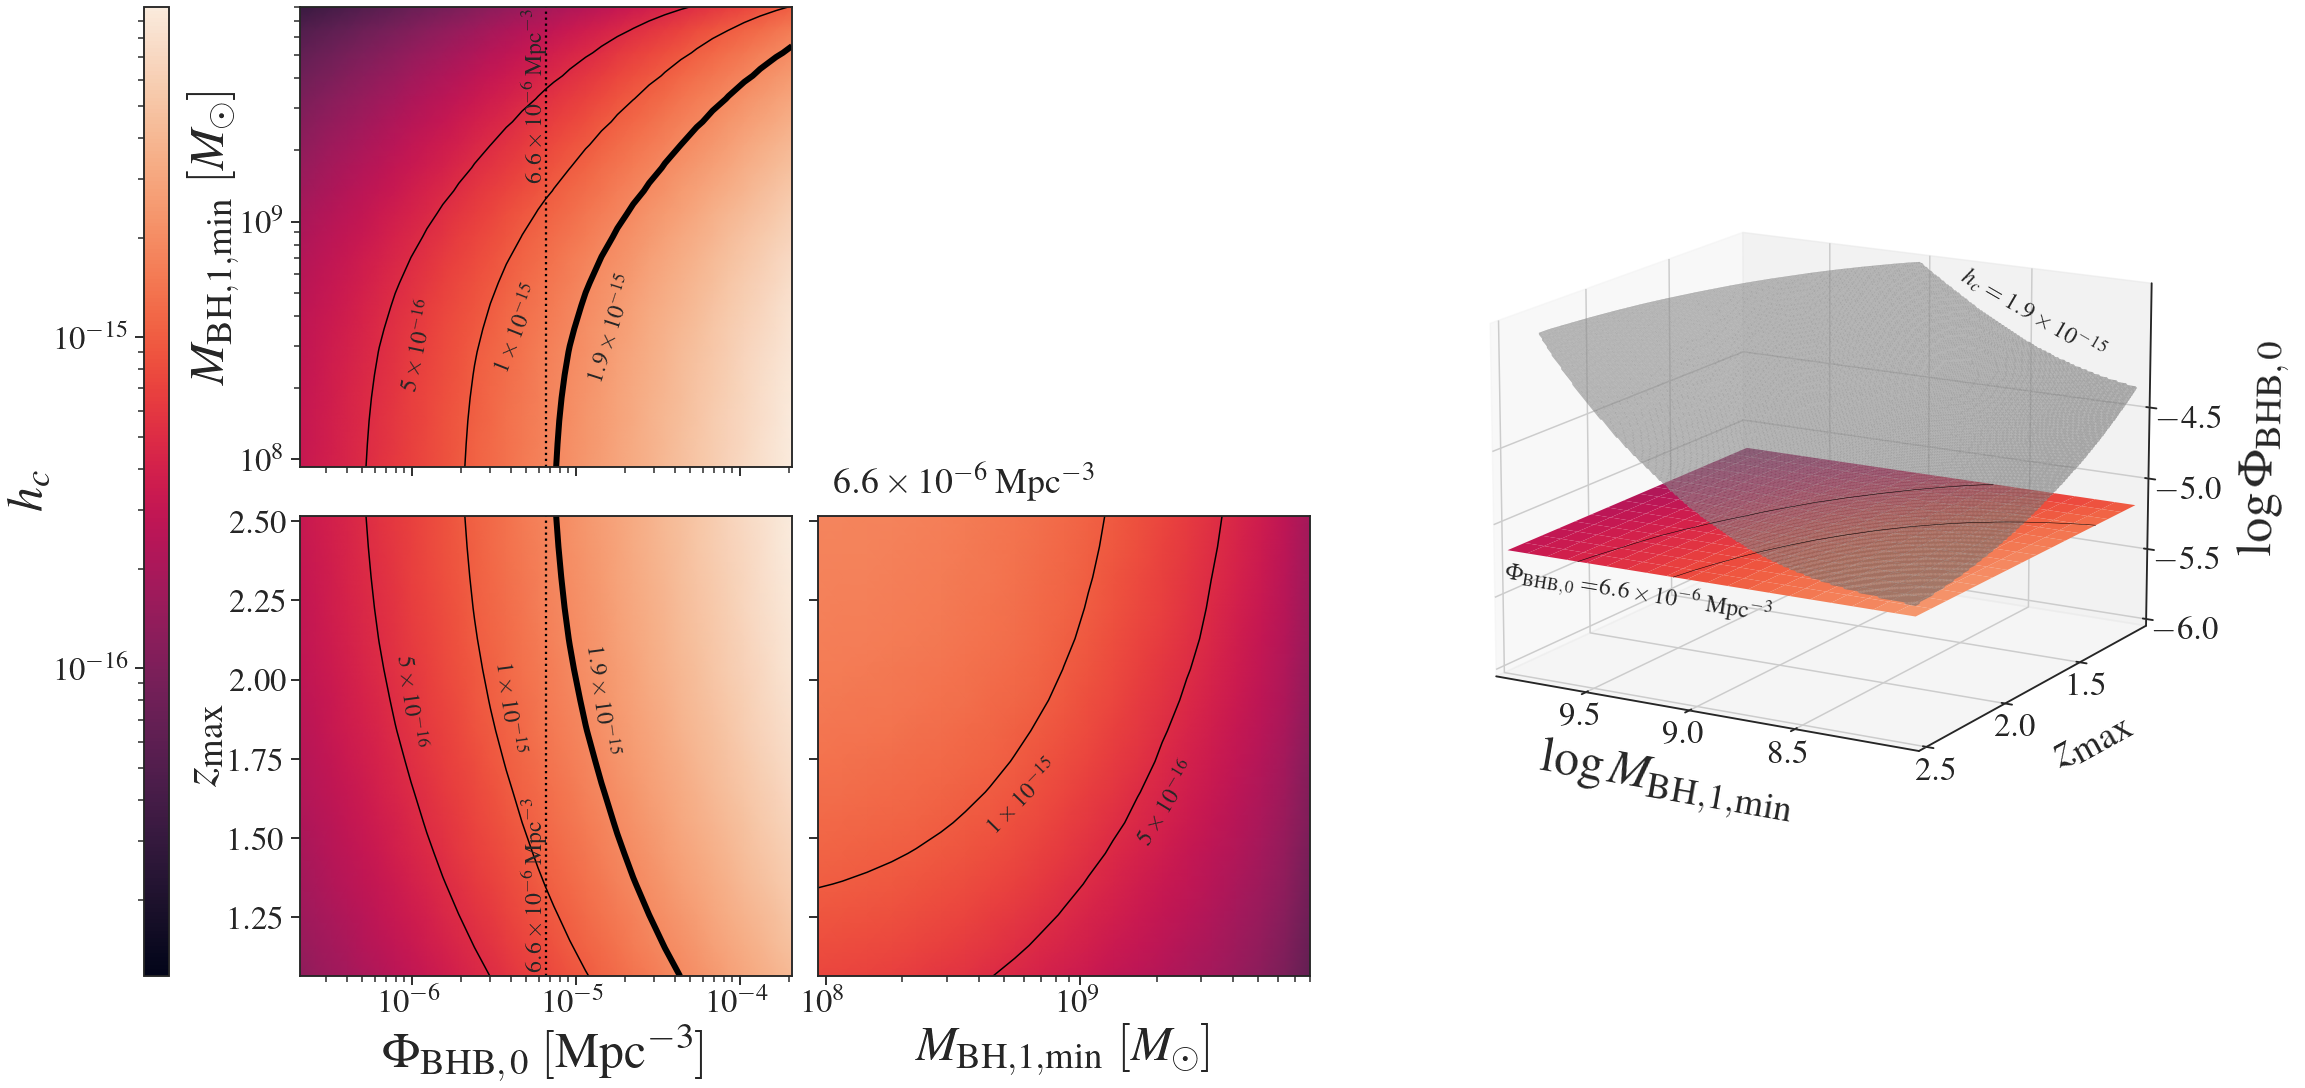

In [104]:
# corner plots
# %matplotlib inline
fmt = {}
strs = [r'$5 \times 10^{{-16}}$', r'$1 \times 10^{{-15}}$', r'$1.9 \times 10^{{-15}}$']
levels = [5e-16, 1e-15, NANOGrav_hc]
linewidths = [1.5, 1.5, 6]
labels = dict(zip(levels, strs))
cfont_size = 32
inline_spacing=1
inline=False
n_art_idx = 21
text_fs = 24

# NANOGrav_plot_3d = mpimg.imread('../reports/figures/NANOGrav_3D.png')
light = LightSource(-60, 15)

sns.set_context("talk", font_scale=2)

widths = [.05, 1, 1, 2]
heights = [1, 1]

order = 10. ** np.floor(NANOGrav_log_n_new)
art_dens = r'${0:.1f} \times 10^{{{1:.0f}}} \; \rm{{Mpc}}^{{-3}}$'.format((10 ** NANOGrav_log_n_new) / order, np.log10(order))

fig_width = 30
fig_height = fig_width * np.sum(heights) / (np.sum(widths) + .1)

fig = plt.figure(figsize=(32, 15), constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=4, width_ratios=widths, height_ratios=heights)

cnorm = colors.LogNorm(vmin=np.amin(NANOGrav_hc_cube),
                       vmax=np.amax(NANOGrav_hc_cube))
cmap = sns.color_palette("rocket", as_cmap=True)
c = cmap(cnorm(np.squeeze(NANOGrav_hc_cube[log_m_bh_range_zoom == log_m_sat, :, :])))

# next the slices from 3D parameter space
mm_nn_ax = fig.add_subplot(gs[0, 1])
pcm = mm_nn_ax.pcolormesh(np.squeeze(NANOGrav_nn_cube[:, z_range_zoom == z_sat, :]),
                          10 ** np.squeeze(NANOGrav_mm_cube[:, z_range_zoom == z_sat, :]),
                          np.squeeze(NANOGrav_hc_cube[:, z_range_zoom == z_sat, :]), norm=cnorm,
                          shading='gouraud')
cs = mm_nn_ax.contour(np.squeeze(NANOGrav_nn_cube[:, z_range_zoom == z_sat, :]),
                       np.squeeze(10 ** NANOGrav_mm_cube[:, z_range_zoom == z_sat, :]),
                       np.squeeze(NANOGrav_hc_cube[:, z_range_zoom == z_sat, :]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
# for i, (cl, lbl) in enumerate(zip(cs.collections, strs)):
p = cs.collections[0].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 10
rot = np.degrees(np.arctan2([np.log10(y[mid - 4]) - np.log10(y[mid - 10])], [np.log10(x[mid - 4]) - np.log10(x[mid - 10])]))[0]
mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[0], rotation=rot,
              verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

p = cs.collections[1].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 9
rot = np.degrees(np.arctan2([np.log10(y[mid - 4]) - np.log10(y[mid - 6])], [np.log10(x[mid - 4]) - np.log10(x[mid - 6])]))[0]
mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[1], rotation=rot,
              verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

p = cs.collections[2].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 5
rot = np.degrees(np.arctan2([np.log10(y[mid - 2]) - np.log10(y[mid - 10])], [np.log10(x[mid - 2]) - np.log10(x[mid - 10])]))[0]
mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[2], rotation=rot,
              verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

mm_nn_ax.axvline(local_number_density * NANOGrav_mult_factor, color='k', linestyle=':')
mm_nn_ax.text(local_number_density * NANOGrav_mult_factor, 10 ** (np.max(log_m_bh_range_zoom) - .01), art_dens, rotation='vertical',
              horizontalalignment='right', verticalalignment='bottom', rotation_mode='anchor', fontsize=text_fs)

mm_nn_ax.set_ylabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
mm_nn_ax.set_yscale('log')
mm_nn_ax.set_xscale('log')
plt.setp(mm_nn_ax.get_xticklabels(), visible=False)

zz_nn_ax = fig.add_subplot(gs[1, 1], sharex=mm_nn_ax)
pcm = zz_nn_ax.pcolormesh(np.squeeze(NANOGrav_nn_cube[log_m_bh_range_zoom == log_m_sat, :, :]),
                          np.squeeze(NANOGrav_zz_cube[log_m_bh_range_zoom == log_m_sat, :, :]),
                          np.squeeze(NANOGrav_hc_cube[log_m_bh_range_zoom == log_m_sat, :, :]), norm=cnorm,
                          shading='gouraud')
cs = zz_nn_ax.contour(np.squeeze(NANOGrav_nn_cube[log_m_bh_range_zoom == log_m_sat, :, :]),
                       np.squeeze(NANOGrav_zz_cube[log_m_bh_range_zoom == log_m_sat, :, :]),
                       np.squeeze(NANOGrav_hc_cube[log_m_bh_range_zoom == log_m_sat, :, :]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
for cl, lbl in zip(cs.collections, strs):
    p = cl.get_paths()[0]
    v = p.vertices
    x = v[:, 0]
    y = v[:, 1]
    
    mid = int(np.trunc(len(x) / 2))
    
    rot = np.degrees(np.arctan2([y[-1] - y[0]], [np.log10(x[-1]) - np.log10(x[0])]))[0] - 20
    
    zz_nn_ax.text(x[mid + 2], y[mid - 4], lbl, rotation=rot,
                  verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)
    
zz_nn_ax.axvline(local_number_density * NANOGrav_mult_factor, color='k', linestyle=':')
zz_nn_ax.text(local_number_density * NANOGrav_mult_factor, np.min(z_range_zoom) + .01, art_dens, rotation='vertical',
              horizontalalignment='left', verticalalignment='bottom', rotation_mode='anchor', fontsize=text_fs)
zz_nn_ax.set_xlabel(r'$\Phi_{\rm{BHB},\,0}\ [\rm{Mpc}^{-3}]$', fontsize=label_fsize)
zz_nn_ax.set_xscale('log')
zz_nn_ax.set_ylabel(r'$z_{\rm{max}}$', fontsize=label_fsize)

zz_mm_ax = fig.add_subplot(gs[1, 2], sharey=zz_nn_ax)
pcm = zz_mm_ax.pcolormesh(10 ** np.squeeze(NANOGrav_mm_cube[:, :, NANOGrav_n_artificial_range == NANOGrav_mult_factor_sqrt]),
                          np.squeeze(NANOGrav_zz_cube[:, :, NANOGrav_n_artificial_range == NANOGrav_mult_factor_sqrt]),
                          np.squeeze(NANOGrav_hc_cube[:, :, NANOGrav_n_artificial_range == NANOGrav_mult_factor_sqrt]),
                          norm=cnorm, shading='gouraud')
cs = zz_mm_ax.contour(10 ** np.squeeze(NANOGrav_mm_cube[:, :, NANOGrav_n_artificial_range == NANOGrav_mult_factor_sqrt]),
                       np.squeeze(NANOGrav_zz_cube[:, :, NANOGrav_n_artificial_range == NANOGrav_mult_factor_sqrt]),
                       np.squeeze(NANOGrav_hc_cube[:, :, NANOGrav_n_artificial_range == NANOGrav_mult_factor_sqrt]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
for i, (cl, lbl) in enumerate(zip(cs.collections, strs)):
    p = cl.get_paths()[0]
    v = p.vertices
    x = v[:, 0]
    y = v[:, 1]
    
    mid = int(np.trunc(len(x) / 2))
    
    rot = np.degrees(np.arctan2([y[mid + 1] - y[mid - 1]], [np.log10(x[mid + 1]) - np.log10(x[mid - 1])]))[0]
    
    zz_mm_ax.text(x[mid + 1], y[mid - 1], lbl, rotation=rot,
                  verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)
    if i == 1:
        break

zz_mm_ax.set_xlabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
zz_mm_ax.set_ylabel(r'$ $', fontsize=label_fsize)
zz_mm_ax.set_xscale('log')
plt.setp(zz_mm_ax.get_yticklabels(), visible=False)

# add a colorbar
cb_ax = fig.add_subplot(gs[:, 0])
cb = plt.colorbar(pcm, cax=cb_ax)
cb.set_label(r'$h_{c}$', fontsize=label_fsize)

cb_ax.yaxis.set_ticks_position('left')
cb_ax.yaxis.set_label_position('left')

# # add Mathematica plot
# plot_3d_ax = fig.add_subplot(gs[:, 3])
# plot_3d_ax.imshow(NANOGrav_plot_3d)
# plot_3d_ax.axis('off')

# add 3D plot
plot_3d_ax = fig.add_subplot(gs[:, 3], projection='3d')
if NANOGrav_bottom_verts is not None:
    tri_bottom = plot_3d_ax.plot_trisurf(NANOGrav_bottom_verts[:, 0], NANOGrav_bottom_verts[:,1], NANOGrav_bottom_verts[:, 2], #vmin=-4,
                                         lw=0, color=clr[7], shade=True, lightsource=light, alpha=.8)
tri_top = plot_3d_ax.plot_trisurf(NANOGrav_top_verts[:, 0], NANOGrav_top_verts[:,1], NANOGrav_top_verts[:, 2], #vmin=-4,
                                  lw=0, color=clr[7], shade=True, lightsource=light, alpha=.8)
surf = plot_3d_ax.plot_surface(NANOGrav_xx_3d, NANOGrav_yy_3d, NANOGrav_zz_3d, shade=False, lightsource=light, 
                               facecolors=c, alpha=1, lw=0)
if NANOGrav_bottom_verts is not None:
    tri_bottom.set_sort_zpos(.5)

surf.set_sort_zpos(1.5)
tri_top.set_sort_zpos(2.5)

# custom contours
for i, cl in enumerate(cs.collections):
    p = cl.get_paths()[0]
    v = p.vertices
    x = v[:, 0]
    y = v[:, 1]
    
#     print(np.log10(x))
#     print(np.log10(NANOGrav_mult_factor * local_number_density))
    lw = .5
    plot_3d_ax.plot(np.log10(x), y, NANOGrav_log_n_new, color='k', zorder=3, linewidth=lw)
    if i == 1:
        break

plot_3d_ax.set_xlim(log_m_bh_range_zoom[0], log_m_bh_range_zoom[-1])
plot_3d_ax.set_ylim(z_range_zoom[-1], z_range_zoom[0])
# plot_3d_ax.set_zlim(log_n_range[0], log_n_range[-1])
plot_3d_ax.text(np.max(NANOGrav_xx_3d), np.max(NANOGrav_yy_3d), NANOGrav_zz_3d[0, 0] - .05,
                r'$\Phi_{\rm{BHB},\,0} = $' + art_dens,
                zdir='x', rotation_mode='anchor', verticalalignment='top',
                fontsize=text_fs, zorder=5)

density_label_x = NANOGrav_top_verts[NANOGrav_top_verts[:, 1] == NANOGrav_top_verts[:, 1].min(), 0].max()
density_label_y = NANOGrav_top_verts[NANOGrav_top_verts[:, 1] == NANOGrav_top_verts[:, 1].min(), 1][0]
density_label_z = NANOGrav_top_verts[NANOGrav_top_verts[:, 1] == NANOGrav_top_verts[:, 1].min(), 2].max()
delta_x = density_label_x - NANOGrav_top_verts[NANOGrav_top_verts[:, 1] == NANOGrav_top_verts[:, 1].min(), 0].min()
delta_z = density_label_z - NANOGrav_top_verts[NANOGrav_top_verts[:, 1] == NANOGrav_top_verts[:, 1].min(), 2].min()
plot_3d_ax.text(density_label_x - (.5 * delta_x), density_label_y, density_label_z - (.5 * delta_z),
                r'$h_{c} = 1.9 \times 10^{-15}$',
                zdir=(delta_x, 0, delta_z), rotation_mode='anchor', 
                horizontalalignment='center', verticalalignment='bottom',
                fontsize=text_fs, zorder=5)
plot_3d_ax.set_zlim(-6, NANOGrav_log_n_range[-1])
plot_3d_ax.set_xticks([8.5, 9, 9.5])
plot_3d_ax.set_yticks([1.5, 2, 2.5])
plot_3d_ax.set_zticks([-6, -5.5, -5, -4.5])
plot_3d_ax.tick_params(axis='z', which='major', pad=25)
plot_3d_ax.view_init(azim=-60, elev=15)
plot_3d_ax.set_xlabel(r'$\log M_{\rm{BH}, 1, \min}$', fontsize=label_fsize, labelpad=50)
plot_3d_ax.set_ylabel(r'$z_{\rm{max}}$', fontsize=label_fsize, labelpad=40)
plot_3d_ax.set_zlabel(r'$\log \Phi_{\rm{BHB},\,0}$', fontsize=label_fsize, labelpad=70)
plot_3d_ax.dist = 13
plot_3d_ax.set_rasterized(True)

# plt.tight_layout(w_pad=w_pad)
fig.text(.36, .54, art_dens, horizontalalignment='left', verticalalignment='bottom')
plt.savefig('../reports/figures/corner_NANOGrav.pdf')
plt.savefig('../reports/figures/corner_NANOGrav.png')
plt.show()

In [102]:
NANOGrav_log_n_range[0]

-6.681990644385688

In [ ]:
np.log10(local_number_density)

### IPTA

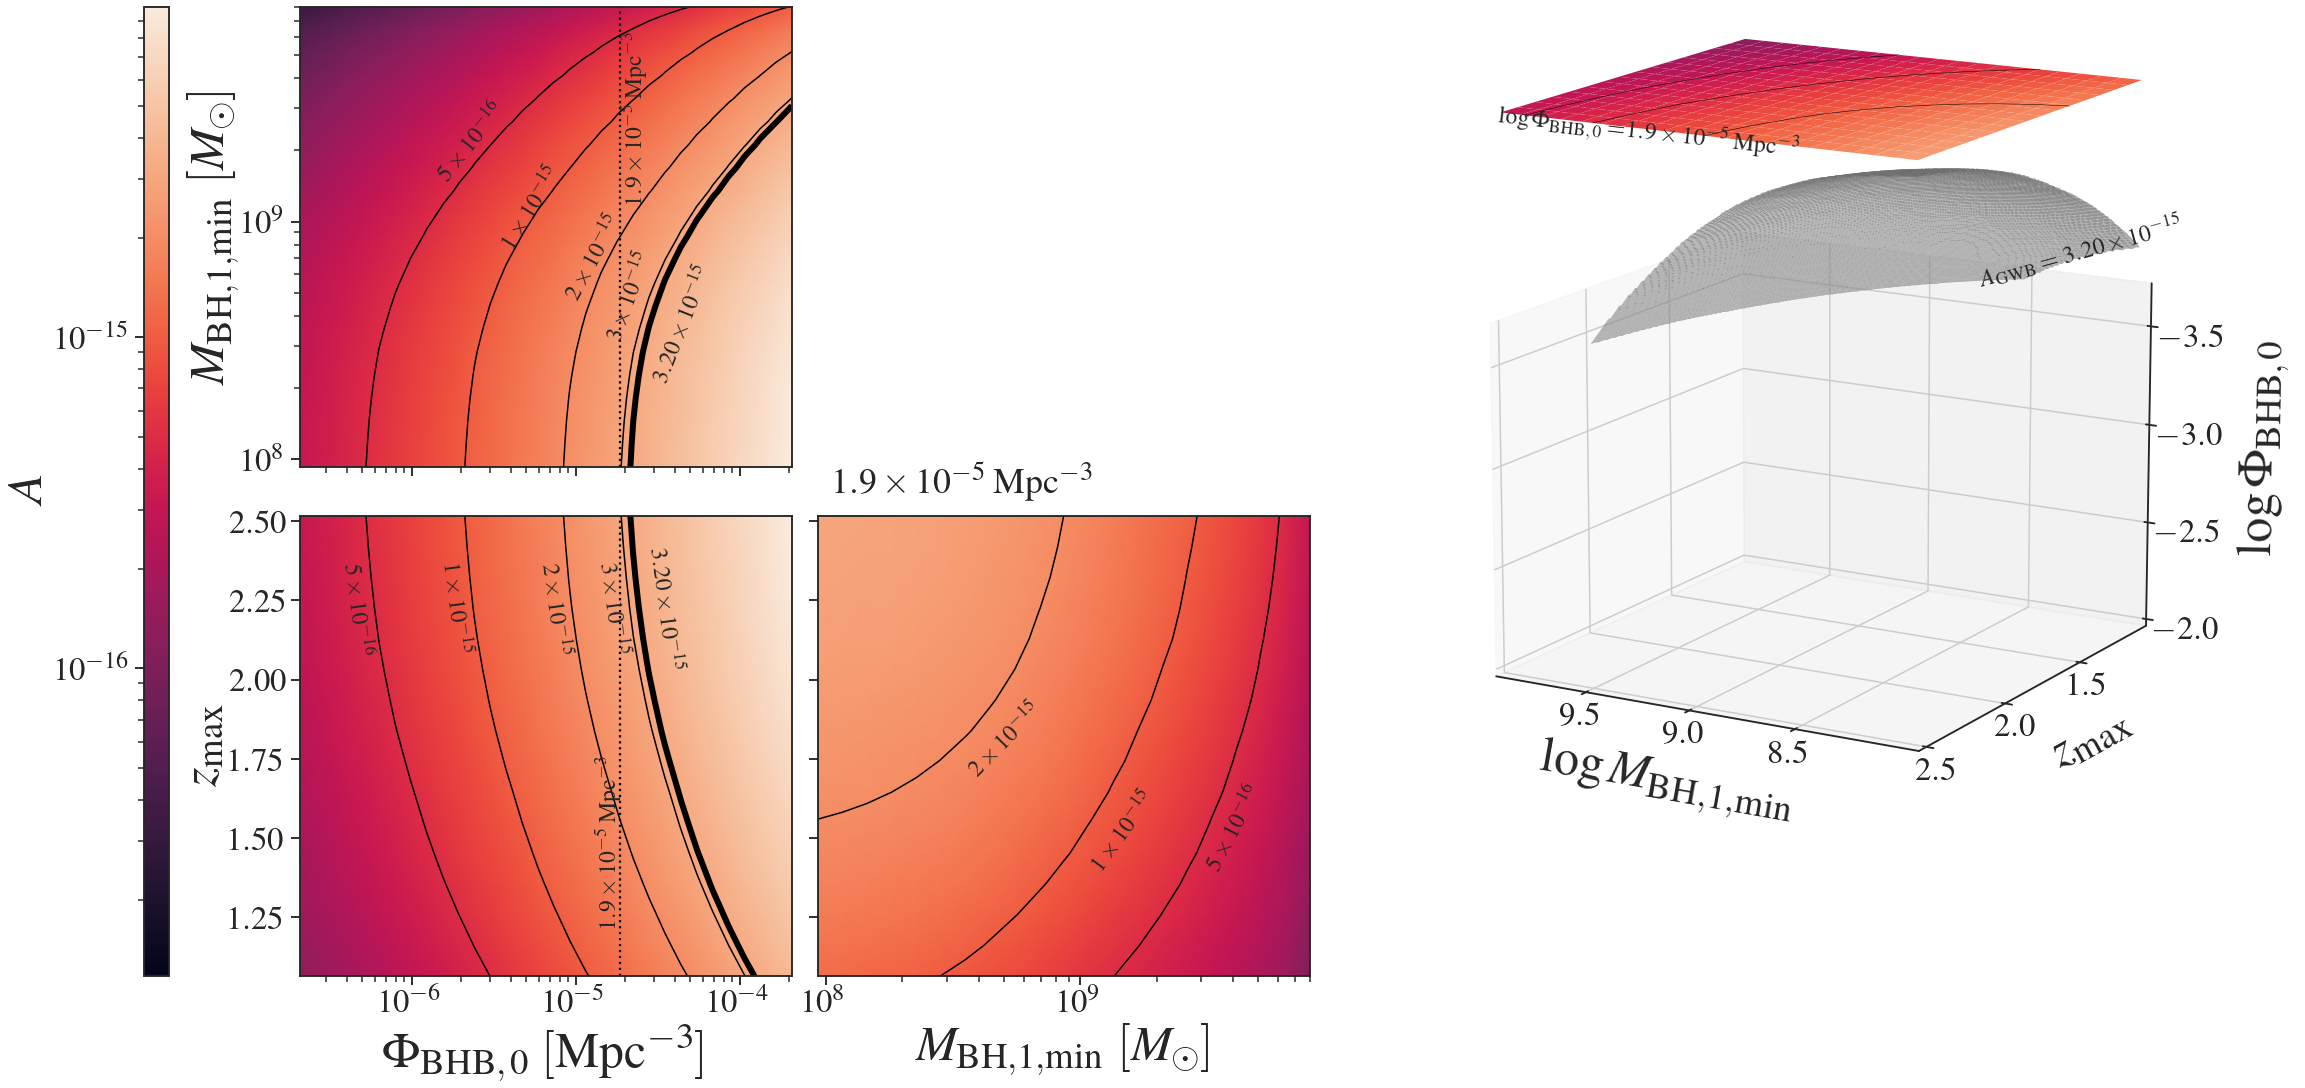

In [91]:
# corner plots
# %matplotlib inline
fmt = {}
strs = [r'$5 \times 10^{{-16}}$', r'$1 \times 10^{{-15}}$', r'$2 \times 10^{{-15}}$', r'$3 \times 10^{{-15}}$', r'$3.20 \times 10^{{-15}}$']
levels = [5e-16, 1e-15, 2e-15, 3e-15, IPTA_hc]
linewidths = [1.5, 1.5, 1.5, 1.5, 6]
labels = dict(zip(levels, strs))
cfont_size = 32
inline_spacing=1
inline=False
n_art_idx = 21
text_fs = 24

sns.set_context("talk", font_scale=2)

widths = [.05, 1, 1, 2]
heights = [1, 1]

order = 10. ** np.floor(IPTA_log_n_new)
art_dens = r'${0:.1f} \times 10^{{{1:.0f}}} \; \rm{{Mpc}}^{{-3}}$'.format((10 ** IPTA_log_n_new) / order, np.log10(order))

fig_width = 30
fig_height = fig_width * np.sum(heights) / (np.sum(widths) + .1)

fig = plt.figure(figsize=(32, 15), constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=4, width_ratios=widths, height_ratios=heights)

cnorm = colors.LogNorm(vmin=np.amin(IPTA_hc_cube),
                       vmax=np.amax(IPTA_hc_cube))
cmap = sns.color_palette("rocket", as_cmap=True)
c = cmap(cnorm(np.squeeze(IPTA_hc_cube[log_m_bh_range_zoom == log_m_sat, :, :])))

# next the slices from 3D parameter space
mm_nn_ax = fig.add_subplot(gs[0, 1])
pcm = mm_nn_ax.pcolormesh(np.squeeze(IPTA_nn_cube[:, z_range_zoom == z_sat, :]),
                          10 ** np.squeeze(IPTA_mm_cube[:, z_range_zoom == z_sat, :]),
                          np.squeeze(IPTA_hc_cube[:, z_range_zoom == z_sat, :]), norm=cnorm,
                          shading='gouraud')
cs = mm_nn_ax.contour(np.squeeze(IPTA_nn_cube[:, z_range_zoom == z_sat, :]),
                       np.squeeze(10 ** IPTA_mm_cube[:, z_range_zoom == z_sat, :]),
                       np.squeeze(IPTA_hc_cube[:, z_range_zoom == z_sat, :]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
# for i, (cl, lbl) in enumerate(zip(cs.collections, strs)):
### 5e-16
p = cs.collections[0].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2))
rot = np.degrees(np.arctan2([np.log10(y[mid]) - np.log10(y[mid - 15])], [np.log10(x[mid]) - np.log10(x[mid - 15])]))[0]
mm_nn_ax.text(x[mid - 1], y[mid], strs[0], rotation=rot,
              verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

### 1e-15
p = cs.collections[1].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 5
rot = np.degrees(np.arctan2([np.log10(y[mid]) - np.log10(y[mid - 10])], [np.log10(x[mid]) - np.log10(x[mid - 10])]))[0]
mm_nn_ax.text(x[mid - 1], y[mid], strs[1], rotation=rot,
              verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

### 2e-15
p = cs.collections[2].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 5
rot = np.degrees(np.arctan2([np.log10(y[mid]) - np.log10(y[mid - 5])], [np.log10(x[mid]) - np.log10(x[mid - 5])]))[0]
mm_nn_ax.text(x[mid - 2], y[mid], strs[2], rotation=rot,
              verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

### 3e-15
p = cs.collections[3].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 5
rot = np.degrees(np.arctan2([np.log10(y[mid]) - np.log10(y[mid - 5])], [np.log10(x[mid]) - np.log10(x[mid - 5])]))[0]
mm_nn_ax.text(x[mid - 3], y[mid], strs[3], rotation=rot,
              verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

### 3.2e-15
p = cs.collections[4].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2))
rot = np.degrees(np.arctan2([np.log10(y[mid]) - np.log10(y[mid - 10])], [np.log10(x[mid]) - np.log10(x[mid - 10])]))[0]
mm_nn_ax.text(x[mid + 1], y[mid - 5], strs[4], rotation=rot,
              verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

mm_nn_ax.axvline(local_number_density * IPTA_mult_factor, color='k', linestyle=':')
mm_nn_ax.text(local_number_density * IPTA_mult_factor, 10 ** (np.max(log_m_bh_range_zoom) - .1), art_dens, rotation='vertical',
              horizontalalignment='right', verticalalignment='top', rotation_mode='anchor', fontsize=text_fs)

mm_nn_ax.set_ylabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
mm_nn_ax.set_yscale('log')
mm_nn_ax.set_xscale('log')
plt.setp(mm_nn_ax.get_xticklabels(), visible=False)

zz_nn_ax = fig.add_subplot(gs[1, 1], sharex=mm_nn_ax)
pcm = zz_nn_ax.pcolormesh(np.squeeze(IPTA_nn_cube[log_m_bh_range_zoom == log_m_sat, :, :]),
                          np.squeeze(IPTA_zz_cube[log_m_bh_range_zoom == log_m_sat, :, :]),
                          np.squeeze(IPTA_hc_cube[log_m_bh_range_zoom == log_m_sat, :, :]), norm=cnorm,
                          shading='gouraud')
cs = zz_nn_ax.contour(np.squeeze(IPTA_nn_cube[log_m_bh_range_zoom == log_m_sat, :, :]),
                       np.squeeze(IPTA_zz_cube[log_m_bh_range_zoom == log_m_sat, :, :]),
                       np.squeeze(IPTA_hc_cube[log_m_bh_range_zoom == log_m_sat, :, :]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# # custom contours
# for i, (cl, lbl) in enumerate(zip(cs.collections, strs)):
#     p = cl.get_paths()[0]
#     v = p.vertices
#     x = v[:, 0]
#     y = v[:, 1]
    
#     mid = int(np.trunc(len(x) / 2)) - 4
    
#     rot = np.degrees(np.arctan2([y[-1] - y[0]], [np.log10(x[-1]) - np.log10(x[0])]))[0] - 20
    
#     if i == len(strs) - 1:
#         zz_nn_ax.text(x[mid + 4], y[mid - 4], lbl, rotation=rot,
#                       verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)
#     else:
#         zz_nn_ax.text(x[mid - 4], y[mid - 4], lbl, rotation=rot,
#                       verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

### 5e-16
p = cs.collections[0].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 4
rot = np.degrees(np.arctan2([y[-1] - y[0]], [np.log10(x[-1]) - np.log10(x[0])]))[0] - 20
zz_nn_ax.text(.95 * x[mid - 4], y[mid - 4], strs[0], rotation=rot,
              verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

### 1e-15
p = cs.collections[1].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 5
rot = np.degrees(np.arctan2([y[-1] - y[0]], [np.log10(x[-1]) - np.log10(x[0])]))[0] - 20
zz_nn_ax.text(.95 * x[mid - 4], y[mid - 4], strs[1], rotation=rot,
              verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

### 2e-15
p = cs.collections[2].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 4
rot = np.degrees(np.arctan2([y[-1] - y[0]], [np.log10(x[-1]) - np.log10(x[0])]))[0] - 20
zz_nn_ax.text(.95 * x[mid - 4], y[mid - 4], strs[2], rotation=rot,
              verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

### 3e-15
p = cs.collections[3].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 5
rot = np.degrees(np.arctan2([y[-1] - y[0]], [np.log10(x[-1]) - np.log10(x[0])]))[0] - 20
zz_nn_ax.text(.95 * x[mid - 4], y[mid - 4], strs[3], rotation=rot,
              verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

### 3.2e-15
p = cs.collections[4].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 4
rot = np.degrees(np.arctan2([y[-1] - y[0]], [np.log10(x[-1]) - np.log10(x[0])]))[0] - 20
zz_nn_ax.text(x[mid + 4], y[mid - 4], strs[4], rotation=rot,
                      verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)


zz_nn_ax.axvline(local_number_density * IPTA_mult_factor, color='k', linestyle=':')
zz_nn_ax.text(local_number_density * IPTA_mult_factor, np.min(z_range_zoom) + .15, art_dens, rotation='vertical',
              horizontalalignment='left', verticalalignment='bottom', rotation_mode='anchor', fontsize=text_fs)

zz_nn_ax.set_xlabel(r'$\Phi_{\rm{BHB},\,0}\ [\rm{Mpc}^{-3}]$', fontsize=label_fsize)
zz_nn_ax.set_xscale('log')
zz_nn_ax.set_ylabel(r'$z_{\rm{max}}$', fontsize=label_fsize)

zz_mm_ax = fig.add_subplot(gs[1, 2], sharey=zz_nn_ax)
pcm = zz_mm_ax.pcolormesh(10 ** np.squeeze(IPTA_mm_cube[:, :, IPTA_n_artificial_range == IPTA_mult_factor_sqrt]),
                          np.squeeze(IPTA_zz_cube[:, :, IPTA_n_artificial_range == IPTA_mult_factor_sqrt]),
                          np.squeeze(IPTA_hc_cube[:, :, IPTA_n_artificial_range == IPTA_mult_factor_sqrt]),
                          norm=cnorm, shading='gouraud')
cs = zz_mm_ax.contour(10 ** np.squeeze(IPTA_mm_cube[:, :, IPTA_n_artificial_range == IPTA_mult_factor_sqrt]),
                       np.squeeze(IPTA_zz_cube[:, :, IPTA_n_artificial_range == IPTA_mult_factor_sqrt]),
                       np.squeeze(IPTA_hc_cube[:, :, IPTA_n_artificial_range == IPTA_mult_factor_sqrt]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
# for cl, lbl in zip(cs.collections, strs):
#     p = cl.get_paths()[0]
#     v = p.vertices
#     x = v[:, 0]
#     y = v[:, 1]
    
#     mid = int(np.trunc(len(x) / 2))
#     rot = np.degrees(np.arctan2([y[mid + 1] - y[mid - 1]], [np.log10(x[mid + 1]) - np.log10(x[mid - 1])]))[0]
#     zz_mm_ax.text(x[mid + 1], y[mid - 1], lbl, rotation=rot,
#                   verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

### 5e-16
p = cs.collections[0].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 2
rot = np.degrees(np.arctan2([y[mid + 1] - y[mid - 1]], [np.log10(x[mid + 1]) - np.log10(x[mid - 1])]))[0]
zz_mm_ax.text(x[mid + 1], y[mid - 1], strs[0], rotation=rot,
              verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

### 1e-15
p = cs.collections[1].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2))
rot = np.degrees(np.arctan2([y[mid + 1] - y[mid - 1]], [np.log10(x[mid + 1]) - np.log10(x[mid - 1])]))[0]
zz_mm_ax.text(x[mid + 1], y[mid - 1], strs[1], rotation=rot,
              verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

### 2e-15
p = cs.collections[2].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2))
rot = np.degrees(np.arctan2([y[mid + 1] - y[mid - 1]], [np.log10(x[mid + 1]) - np.log10(x[mid - 1])]))[0]
zz_mm_ax.text(x[mid + 1], y[mid - 1], strs[2], rotation=rot,
              verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

### 3e-15
# p = cs.collections[3].get_paths()[0]
# v = p.vertices
# x = v[:, 0]
# y = v[:, 1]

# mid = int(np.trunc(len(x) / 2))
# rot = np.degrees(np.arctan2([y[mid + 1] - y[mid - 1]], [np.log10(x[mid + 1]) - np.log10(x[mid - 1])]))[0]
# zz_mm_ax.text(x[mid + 1], y[mid - 1], strs[3], rotation=rot,
#               verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

### 3.2e-15
# p = cs.collections[4].get_paths()[0]
# v = p.vertices
# x = v[:, 0]
# y = v[:, 1]

# mid = int(np.trunc(len(x) / 2))
# rot = np.degrees(np.arctan2([y[mid + 1] - y[mid - 1]], [np.log10(x[mid + 1]) - np.log10(x[mid - 1])]))[0]
# zz_mm_ax.text(x[mid + 1], y[mid - 1], strs[4], rotation=rot,
#               verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

zz_mm_ax.set_xlabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
zz_mm_ax.set_xscale('log')
plt.setp(zz_mm_ax.get_yticklabels(), visible=False)

# add a colorbar
cb_ax = fig.add_subplot(gs[:, 0])
cb = plt.colorbar(pcm, cax=cb_ax)
cb.set_label(r'$A$', fontsize=label_fsize)

cb_ax.yaxis.set_ticks_position('left')
cb_ax.yaxis.set_label_position('left')

# # add Mathematica plot
# plot_3d_ax = fig.add_subplot(gs[:, 3])
# plot_3d_ax.imshow(IPTA_plot_3d)
# plot_3d_ax.axis('off')

# add 3D plot
plot_3d_ax = fig.add_subplot(gs[:, 3], projection='3d')
if IPTA_bottom_verts is not None:
    tri_bottom = plot_3d_ax.plot_trisurf(IPTA_bottom_verts[:, 0], IPTA_bottom_verts[:,1], IPTA_bottom_verts[:, 2], #vmin=-4,
                                         lw=0, color=clr[7], shade=True, lightsource=light, alpha=.8)
tri_top = plot_3d_ax.plot_trisurf(IPTA_top_verts[:, 0], IPTA_top_verts[:,1], IPTA_top_verts[:, 2], #vmin=-4,
                                  lw=0, color=clr[7], shade=True, lightsource=light, alpha=.8)
surf = plot_3d_ax.plot_surface(IPTA_xx_3d, IPTA_yy_3d, IPTA_zz_3d, shade=False, lightsource=light, 
                               facecolors=c, alpha=1, lw=0)

if IPTA_bottom_verts is not None:
    tri_bottom.set_sort_zpos(.5)
surf.set_sort_zpos(1.5)
tri_top.set_sort_zpos(2.5)

# custom contours
for i, cl in enumerate(cs.collections):
    p = cl.get_paths()[0]
    v = p.vertices
    x = v[:, 0]
    y = v[:, 1]
    
#     print(np.log10(x))
#     print(np.log10(IPTA_mult_factor * local_number_density))
    lw = .5
    plot_3d_ax.plot(np.log10(x), y, IPTA_log_n_new, color='k', zorder=3, linewidth=lw)
    
    if i == 2:
        break

plot_3d_ax.text(np.max(IPTA_xx_3d), np.max(IPTA_yy_3d), IPTA_zz_3d[0, 0] - .05,
                r'$\log \Phi_{\rm{BHB},\,0} = $' + art_dens,
                zdir='x', rotation_mode='anchor', verticalalignment='top',
                fontsize=text_fs, zorder=5)

density_label_x = IPTA_top_verts[IPTA_top_verts[:, 1] == IPTA_top_verts[:, 1].min(), 0].max()
density_label_y = IPTA_top_verts[IPTA_top_verts[:, 1] == IPTA_top_verts[:, 1].min(), 1][0]
density_label_z = IPTA_top_verts[IPTA_top_verts[:, 1] == IPTA_top_verts[:, 1].min(), 2].max()
delta_x = density_label_x - IPTA_top_verts[IPTA_top_verts[:, 1] == IPTA_top_verts[:, 1].min(), 0].min()
delta_z = density_label_z - IPTA_top_verts[IPTA_top_verts[:, 1] == IPTA_top_verts[:, 1].min(), 2].min()
plot_3d_ax.text(density_label_x - (.5 * delta_x), density_label_y, density_label_z - (.5 * delta_z),
                r'$A_{\rm{GWB}} = 3.20 \times 10^{-15}$',
                zdir=(delta_x, 0, delta_z), rotation_mode='anchor', horizontalalignment='center', verticalalignment='bottom',
                fontsize=text_fs, zorder=5)
plot_3d_ax.set_xlim(log_m_bh_range_zoom[0], log_m_bh_range_zoom[-1])
plot_3d_ax.set_ylim(z_range_zoom[-1], z_range_zoom[0])
plot_3d_ax.set_zlim(-3.5, IPTA_log_n_range[-1])
plot_3d_ax.set_xticks([8.5, 9, 9.5])
plot_3d_ax.set_yticks([1.5, 2, 2.5])
plot_3d_ax.set_zticks([-3.5, -3, -2.5, -2])
plot_3d_ax.tick_params(axis='z', which='major', pad=25)
plot_3d_ax.view_init(azim=-60, elev=15)
plot_3d_ax.set_xlabel(r'$\log M_{\rm{BH}, 1, \min}$', fontsize=label_fsize, labelpad=50)
plot_3d_ax.set_ylabel(r'$z_{\rm{max}}$', fontsize=label_fsize, labelpad=40)
plot_3d_ax.set_zlabel(r'$\log \Phi_{\rm{BHB},\,0}$', fontsize=label_fsize, labelpad=70)
plot_3d_ax.dist = 13
plot_3d_ax.set_rasterized(True)

# plt.tight_layout(w_pad=w_pad)
fig.text(.36, .54, art_dens, horizontalalignment='left', verticalalignment='bottom')
plt.savefig('../reports/figures/corner_IPTA.pdf')
plt.savefig('../reports/figures/corner_IPTA.png')
plt.show()

## AGN-based model with Kormendy & Ho (2013)

### NANOGrav

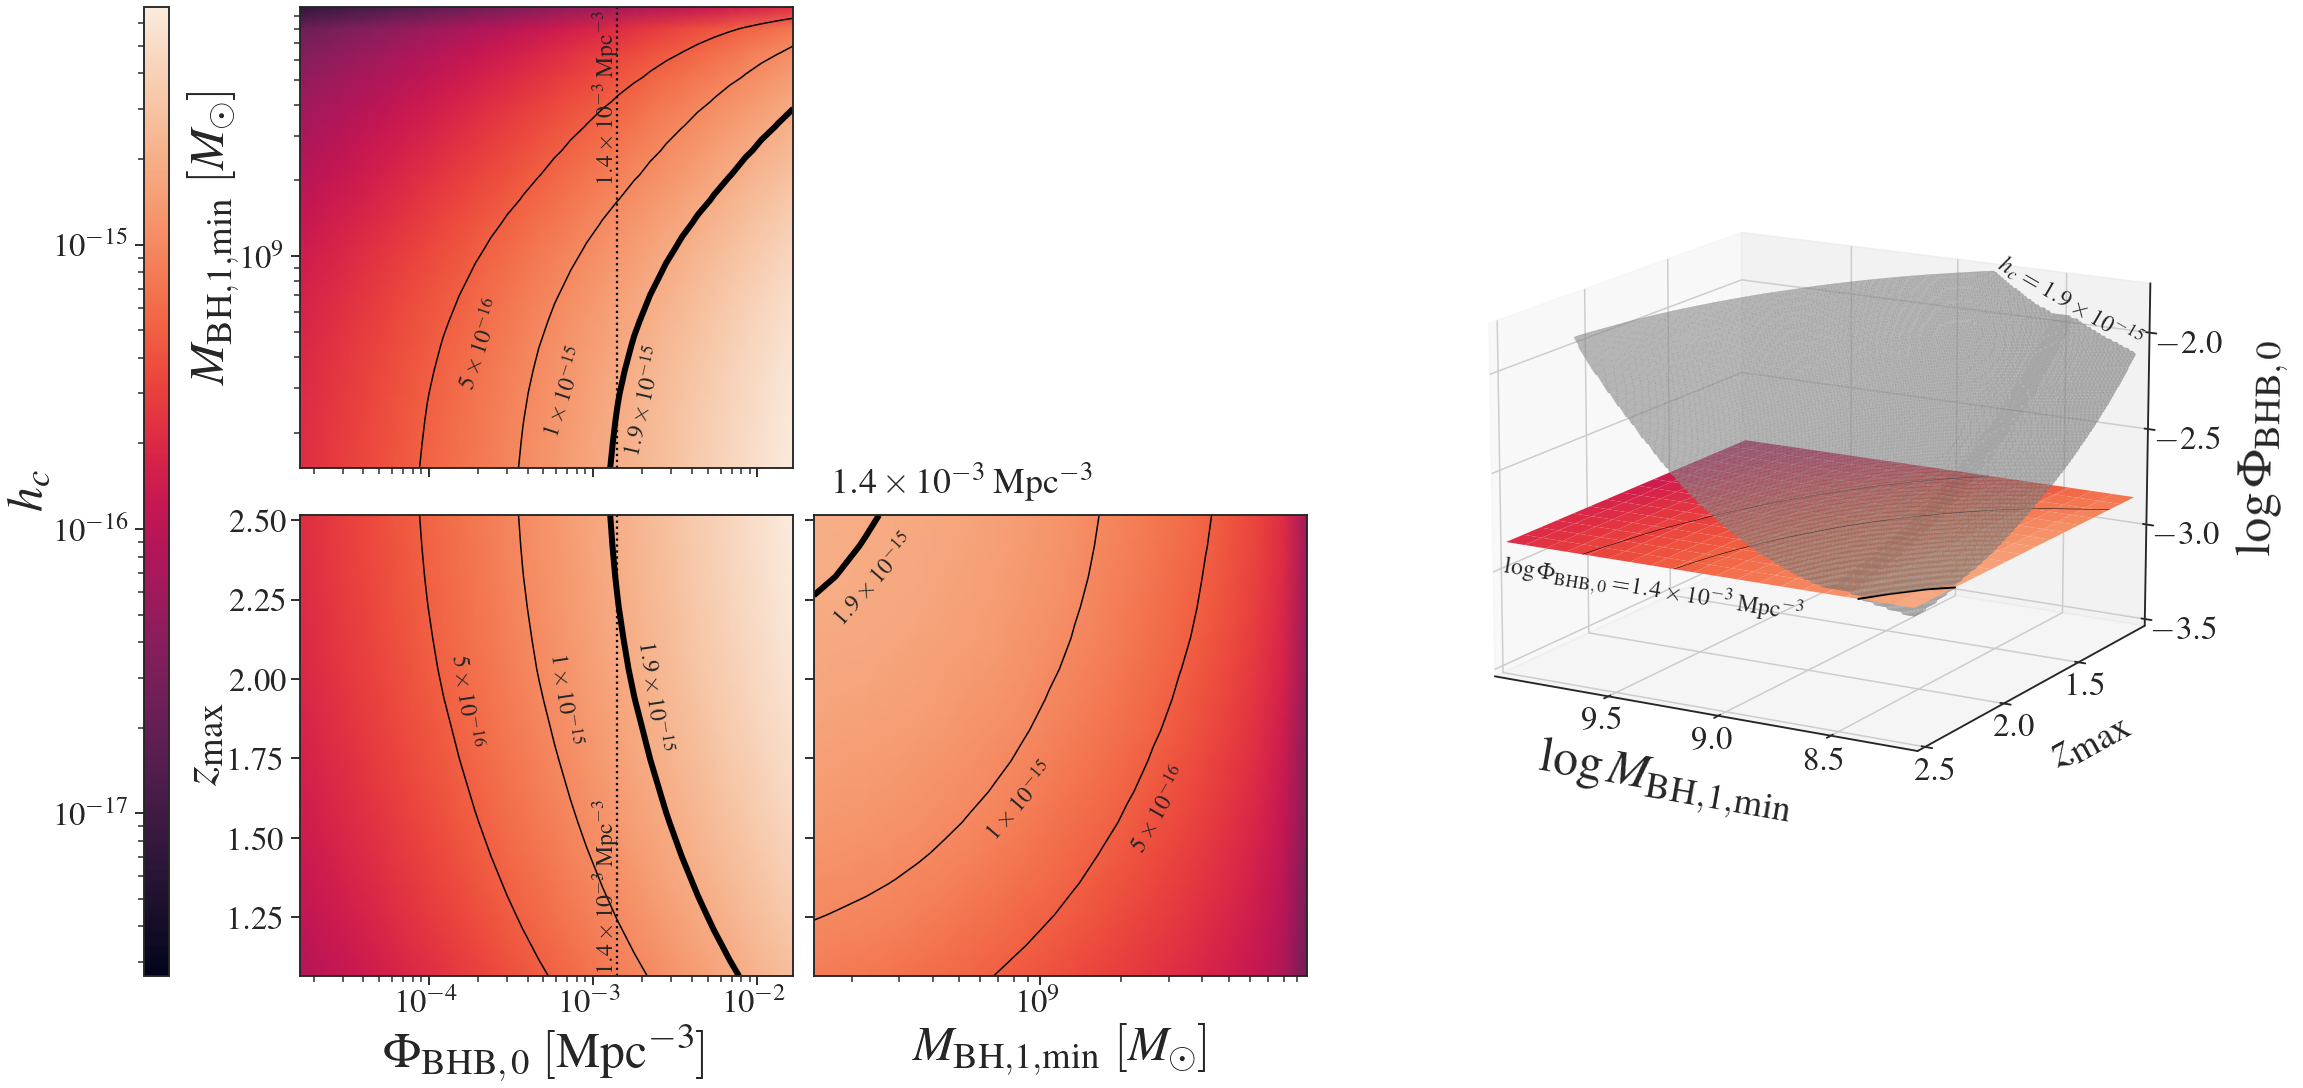

In [92]:
# corner plots
# %matplotlib inline
fmt = {}
strs = [r'$5 \times 10^{{-16}}$', r'$1 \times 10^{{-15}}$', r'$1.9 \times 10^{{-15}}$']
levels = [5e-16, 1e-15, NANOGrav_hc]
linewidths = [1.5, 1.5, 6]
labels = dict(zip(levels, strs))
cfont_size = 32
inline_spacing=1
inline=False
n_art_idx = 21
text_fs = 24

sns.set_context("talk", font_scale=2)

widths = [.05, 1, 1, 2]
heights = [1, 1]

order = 10. ** np.floor(np.log10(local_number_density_kh * NANOGrav_mult_factor_kh))
art_dens = r'${0:.1f} \times 10^{{{1:.0f}}} \; \rm{{Mpc}}^{{-3}}$'.format(local_number_density_kh * NANOGrav_mult_factor_kh / order, np.log10(order))

fig_width = 30
fig_height = fig_width * np.sum(heights) / (np.sum(widths) + .1)

fig = plt.figure(figsize=(32, 15), constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=4, width_ratios=widths, height_ratios=heights)

cnorm = colors.LogNorm(vmin=np.amin(NANOGrav_hc_cube_kh),
                       vmax=np.amax(NANOGrav_hc_cube_kh))
cmap = sns.color_palette("rocket", as_cmap=True)
c = cmap(cnorm(np.squeeze(NANOGrav_hc_cube_kh[log_m_bh_range_zoom_kh == log_m_sat_kh, :, :])))

# next the slices from 3D parameter space
mm_nn_ax = fig.add_subplot(gs[0, 1])
pcm = mm_nn_ax.pcolormesh(np.squeeze(NANOGrav_nn_cube_kh[:, z_range_zoom_kh == z_sat_kh, :]),
                          10 ** np.squeeze(NANOGrav_mm_cube_kh[:, z_range_zoom_kh == z_sat_kh, :]),
                          np.squeeze(NANOGrav_hc_cube_kh[:, z_range_zoom_kh == z_sat_kh, :]), norm=cnorm,
                          shading='gouraud')
cs = mm_nn_ax.contour(np.squeeze(NANOGrav_nn_cube_kh[:, z_range_zoom_kh == z_sat_kh, :]),
                       np.squeeze(10 ** NANOGrav_mm_cube_kh[:, z_range_zoom_kh == z_sat_kh, :]),
                       np.squeeze(NANOGrav_hc_cube_kh[:, z_range_zoom_kh == z_sat_kh, :]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
# for i, (cl, lbl) in enumerate(zip(cs.collections, strs)):
p = cs.collections[0].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 10
rot = np.degrees(np.arctan2([np.log10(y[mid - 4]) - np.log10(y[mid - 10])], [np.log10(x[mid - 4]) - np.log10(x[mid - 10])]))[0]
mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[0], rotation=rot,
              verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

p = cs.collections[1].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 9
rot = np.degrees(np.arctan2([np.log10(y[mid - 4]) - np.log10(y[mid - 6])], [np.log10(x[mid - 4]) - np.log10(x[mid - 6])]))[0]
mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[1], rotation=rot,
              verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

p = cs.collections[2].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 5
rot = np.degrees(np.arctan2([np.log10(y[mid - 2]) - np.log10(y[0])], [np.log10(x[mid - 2]) - np.log10(x[0])]))[0]
mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[2], rotation=rot,
              verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

mm_nn_ax.axvline(local_number_density_kh * NANOGrav_mult_factor_kh, color='k', linestyle=':')
mm_nn_ax.text(local_number_density_kh * NANOGrav_mult_factor_kh, 10 ** (np.max(log_m_bh_range_zoom_kh) - .01), art_dens, rotation='vertical',
              horizontalalignment='right', verticalalignment='bottom', rotation_mode='anchor', fontsize=text_fs)
mm_nn_ax.set_ylabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
mm_nn_ax.set_yscale('log')
mm_nn_ax.set_xscale('log')
plt.setp(mm_nn_ax.get_xticklabels(), visible=False)

zz_nn_ax = fig.add_subplot(gs[1, 1], sharex=mm_nn_ax)
pcm = zz_nn_ax.pcolormesh(np.squeeze(NANOGrav_nn_cube_kh[log_m_bh_range_zoom_kh == log_m_sat_kh, :, :]),
                          np.squeeze(NANOGrav_zz_cube_kh[log_m_bh_range_zoom_kh == log_m_sat_kh, :, :]),
                          np.squeeze(NANOGrav_hc_cube_kh[log_m_bh_range_zoom_kh == log_m_sat_kh, :, :]), norm=cnorm,
                          shading='gouraud')
cs = zz_nn_ax.contour(np.squeeze(NANOGrav_nn_cube_kh[log_m_bh_range_zoom_kh == log_m_sat_kh, :, :]),
                       np.squeeze(NANOGrav_zz_cube_kh[log_m_bh_range_zoom_kh == log_m_sat_kh, :, :]),
                       np.squeeze(NANOGrav_hc_cube_kh[log_m_bh_range_zoom_kh == log_m_sat_kh, :, :]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
for cl, lbl in zip(cs.collections, strs):
    p = cl.get_paths()[0]
    v = p.vertices
    x = v[:, 0]
    y = v[:, 1]
    
    mid = int(np.trunc(len(x) / 2))
    
    rot = np.degrees(np.arctan2([y[-1] - y[0]], [np.log10(x[-1]) - np.log10(x[0])]))[0] - 20
    
    zz_nn_ax.text(x[mid + 2], y[mid - 4], lbl, rotation=rot,
                  verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)
    
zz_nn_ax.axvline(local_number_density_kh * NANOGrav_mult_factor_kh, color='k', linestyle=':')
zz_nn_ax.text(local_number_density_kh * NANOGrav_mult_factor_kh, np.min(z_range_zoom_kh) + .01, art_dens, rotation='vertical',
              horizontalalignment='left', verticalalignment='bottom', rotation_mode='anchor', fontsize=text_fs)
zz_nn_ax.set_xlabel(r'$\Phi_{\rm{BHB},\,0}\ [\rm{Mpc}^{-3}]$', fontsize=label_fsize)
zz_nn_ax.set_xscale('log')
zz_nn_ax.set_ylabel(r'$z_{\rm{max}}$', fontsize=label_fsize)

zz_mm_ax = fig.add_subplot(gs[1, 2], sharey=zz_nn_ax)
pcm = zz_mm_ax.pcolormesh(10 ** np.squeeze(NANOGrav_mm_cube_kh[:, :, NANOGrav_n_artificial_range_kh == NANOGrav_mult_factor_sqrt_kh]),
                          np.squeeze(NANOGrav_zz_cube_kh[:, :, NANOGrav_n_artificial_range_kh == NANOGrav_mult_factor_sqrt_kh]),
                          np.squeeze(NANOGrav_hc_cube_kh[:, :, NANOGrav_n_artificial_range_kh == NANOGrav_mult_factor_sqrt_kh]),
                          norm=cnorm, shading='gouraud')
cs = zz_mm_ax.contour(10 ** np.squeeze(NANOGrav_mm_cube_kh[:, :, NANOGrav_n_artificial_range_kh == NANOGrav_mult_factor_sqrt_kh]),
                       np.squeeze(NANOGrav_zz_cube_kh[:, :, NANOGrav_n_artificial_range_kh == NANOGrav_mult_factor_sqrt_kh]),
                       np.squeeze(NANOGrav_hc_cube_kh[:, :, NANOGrav_n_artificial_range_kh == NANOGrav_mult_factor_sqrt_kh]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
for cl, lbl in zip(cs.collections, strs):
    p = cl.get_paths()[0]
    v = p.vertices
    x = v[:, 0]
    y = v[:, 1]
    
    mid = int(np.trunc(len(x) / 2))
    
    rot = np.degrees(np.arctan2([y[mid + 1] - y[mid - 1]], [np.log10(x[mid + 1]) - np.log10(x[mid - 1])]))[0]
    
    zz_mm_ax.text(x[mid + 1], y[mid - 1], lbl, rotation=rot,
                  verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

zz_mm_ax.set_xlabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
zz_mm_ax.set_xscale('log')
plt.setp(zz_mm_ax.get_yticklabels(), visible=False)

# add a colorbar
cb_ax = fig.add_subplot(gs[:, 0])
cb = plt.colorbar(pcm, cax=cb_ax)
cb.set_label(r'$h_{c}$', fontsize=label_fsize)

cb_ax.yaxis.set_ticks_position('left')
cb_ax.yaxis.set_label_position('left')

# add 3D plot
plot_3d_ax = fig.add_subplot(gs[:, 3], projection='3d')
tri_bottom = plot_3d_ax.plot_trisurf(NANOGrav_bottom_verts_kh[:, 0], NANOGrav_bottom_verts_kh[:,1], NANOGrav_bottom_verts_kh[:, 2], #vmin=-4,
                                     lw=0, color=clr[7], shade=True, lightsource=light, alpha=.8)
tri_top = plot_3d_ax.plot_trisurf(NANOGrav_top_verts_kh[:, 0], NANOGrav_top_verts_kh[:,1], NANOGrav_top_verts_kh[:, 2], #vmin=-4,
                                  lw=0, color=clr[7], shade=True, lightsource=light, alpha=.8)
surf = plot_3d_ax.plot_surface(NANOGrav_xx_3d_kh, NANOGrav_yy_3d_kh, NANOGrav_zz_3d_kh, shade=False, lightsource=light, 
                               facecolors=c, alpha=1, lw=0)
tri_bottom.set_sort_zpos(.5)
surf.set_sort_zpos(1.5)
tri_top.set_sort_zpos(2.5)

# custom contours
for i, cl in enumerate(cs.collections):
    p = cl.get_paths()[0]
    v = p.vertices
    x = v[:, 0]
    y = v[:, 1]
    
#     print(np.log10(x))
#     print(np.log10(NANOGrav_mult_factor * local_number_density))
    if i == 2:
        lw = 2
    else:
        lw = .5
    plot_3d_ax.plot(np.log10(x), y, NANOGrav_log_n_new_kh, color='k', zorder=3, linewidth=lw)

plot_3d_ax.text(np.max(NANOGrav_xx_3d_kh), np.max(NANOGrav_yy_3d_kh), NANOGrav_zz_3d_kh[0, 0] - .05,
                r'$\log \Phi_{\rm{BHB},\,0} = $' + art_dens,
                zdir='x', rotation_mode='anchor', verticalalignment='top',
                fontsize=text_fs, zorder=5)

density_label_x = NANOGrav_top_verts_kh[NANOGrav_top_verts_kh[:, 1] == NANOGrav_top_verts_kh[:, 1].min(), 0].max()
density_label_y = NANOGrav_top_verts_kh[NANOGrav_top_verts_kh[:, 1] == NANOGrav_top_verts_kh[:, 1].min(), 1][0]
density_label_z = NANOGrav_top_verts_kh[NANOGrav_top_verts_kh[:, 1] == NANOGrav_top_verts_kh[:, 1].min(), 2].max()
delta_x = density_label_x - NANOGrav_top_verts_kh[NANOGrav_top_verts_kh[:, 1] == NANOGrav_top_verts_kh[:, 1].min(), 0].min()
delta_z = density_label_z - NANOGrav_top_verts_kh[NANOGrav_top_verts_kh[:, 1] == NANOGrav_top_verts_kh[:, 1].min(), 2].min()
plot_3d_ax.text(density_label_x - (.5 * delta_x), density_label_y, density_label_z - (.5 * delta_z),
                r'$h_{c} = 1.9 \times 10^{-15}$',
                zdir=(delta_x, 0, delta_z), rotation_mode='anchor', 
                horizontalalignment='center', verticalalignment='bottom',
                fontsize=text_fs, zorder=5)
plot_3d_ax.set_xlim(log_m_bh_range_zoom_kh[0], log_m_bh_range_zoom_kh[-1])
plot_3d_ax.set_ylim(z_range_zoom_kh[-1], z_range_zoom_kh[0])
plot_3d_ax.set_zlim(-3.5, NANOGrav_log_n_range_kh[-1])
plot_3d_ax.set_xticks([8.5, 9, 9.5])
plot_3d_ax.set_yticks([1.5, 2, 2.5])
plot_3d_ax.set_zticks([-3.5, -3, -2.5, -2])
plot_3d_ax.tick_params(axis='z', which='major', pad=25)
plot_3d_ax.view_init(azim=-60, elev=15)
plot_3d_ax.set_xlabel(r'$\log M_{\rm{BH}, 1, \min}$', fontsize=label_fsize, labelpad=50)
plot_3d_ax.set_ylabel(r'$z_{\rm{max}}$', fontsize=label_fsize, labelpad=40)
plot_3d_ax.set_zlabel(r'$\log \Phi_{\rm{BHB},\,0}$', fontsize=label_fsize, labelpad=70)
plot_3d_ax.dist = 13
plot_3d_ax.set_rasterized(True)

# plt.tight_layout(w_pad=w_pad)
fig.text(.36, .54, art_dens, horizontalalignment='left', verticalalignment='bottom')
plt.savefig('../reports/figures/corner_NANOGrav_kh.pdf')
plt.savefig('../reports/figures/corner_NANOGrav_kh.png')
plt.show()

### IPTA

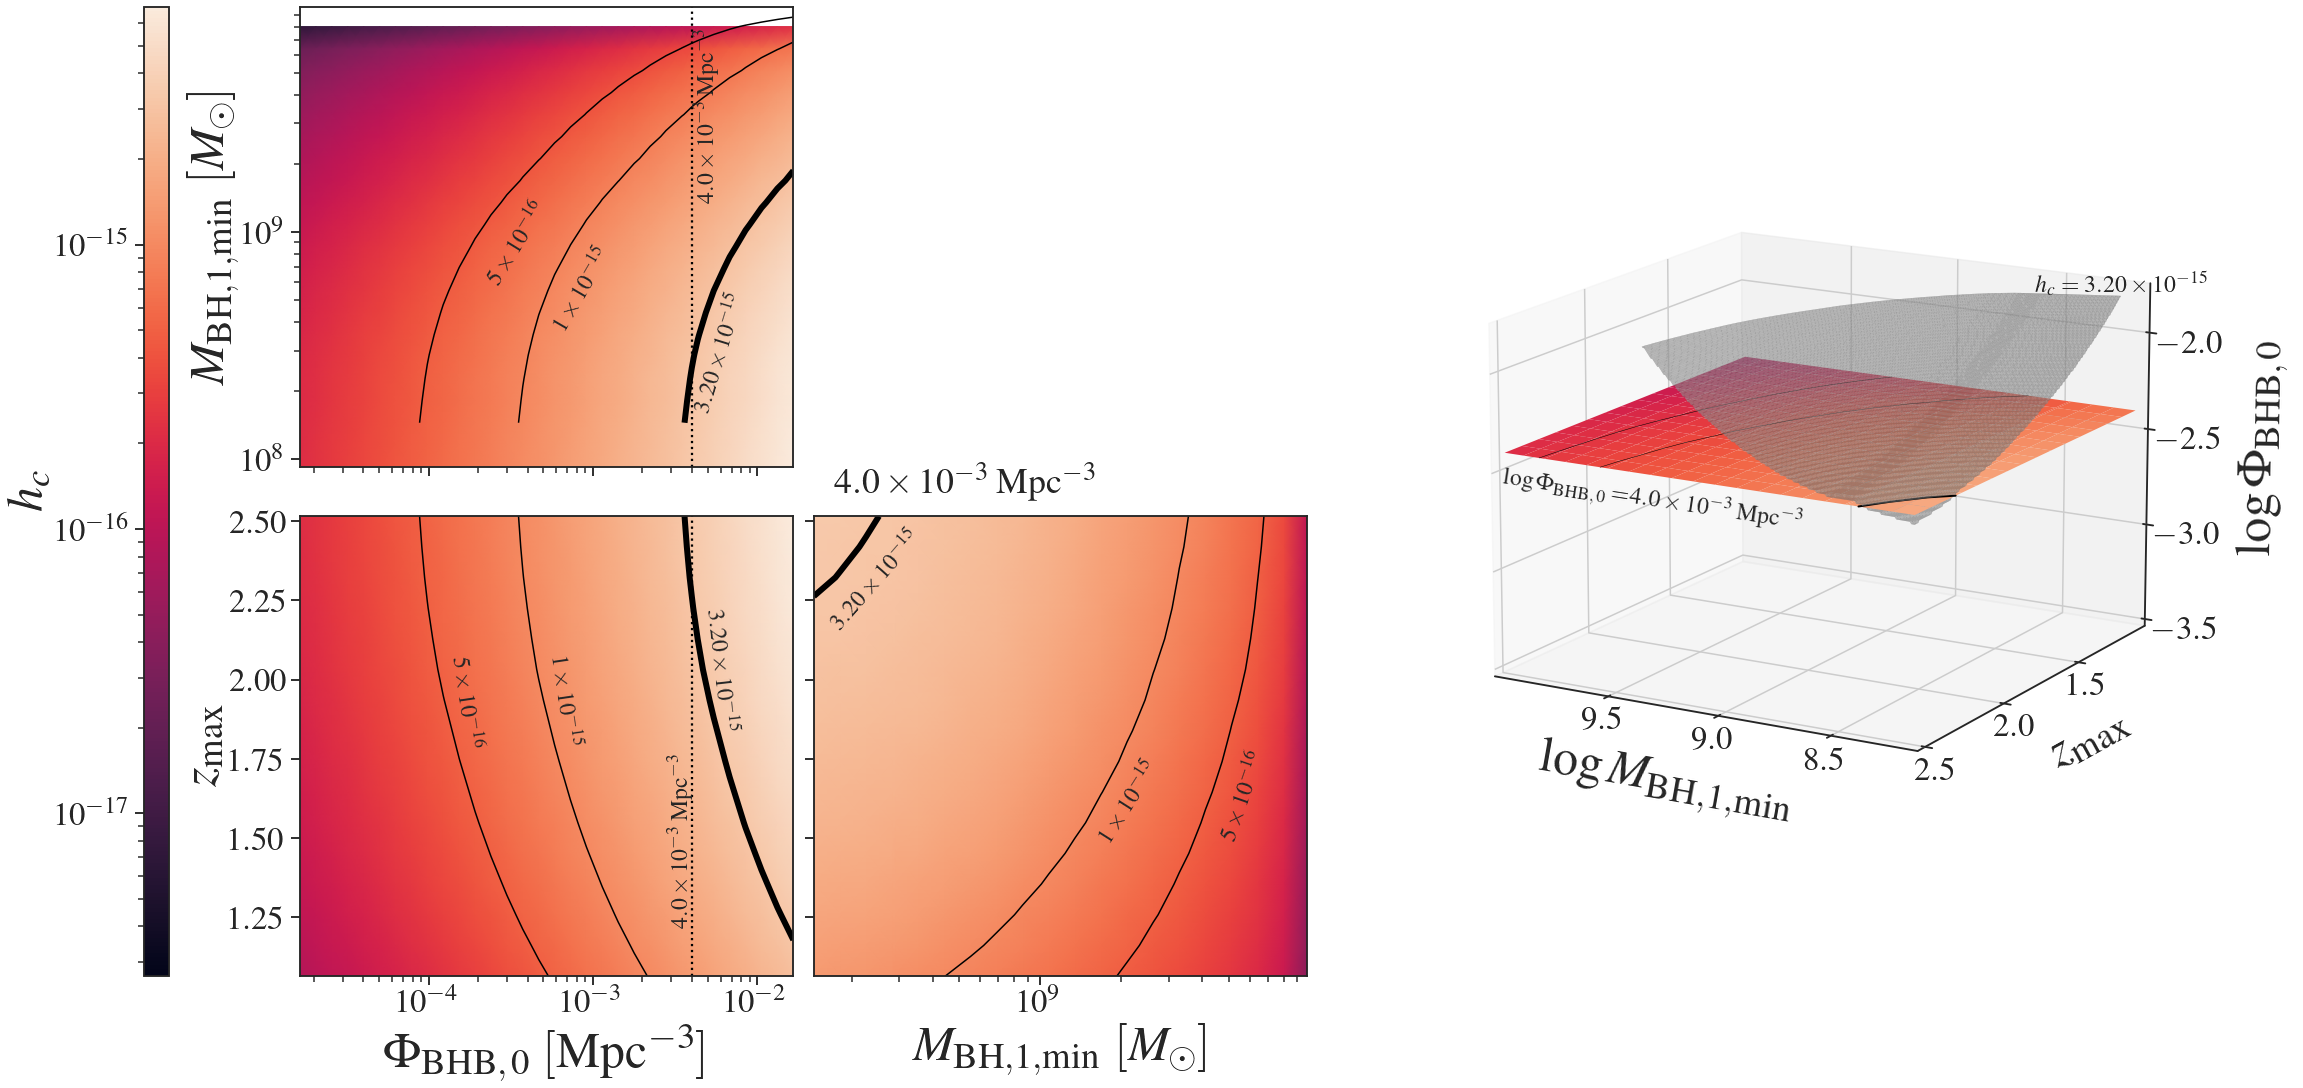

In [93]:
# corner plots
# %matplotlib inline
fmt = {}
strs = [r'$5 \times 10^{{-16}}$', r'$1 \times 10^{{-15}}$', r'$3.20 \times 10^{{-15}}$']
levels = [5e-16, 1e-15, IPTA_hc]
linewidths = [1.5, 1.5, 6]
labels = dict(zip(levels, strs))
cfont_size = 32
inline_spacing=1
inline=False
n_art_idx = 21
text_fs = 24

sns.set_context("talk", font_scale=2)

widths = [.05, 1, 1, 2]
heights = [1, 1]

order = 10. ** np.floor(np.log10(local_number_density_kh * IPTA_mult_factor_kh))
art_dens = r'${0:.1f} \times 10^{{{1:.0f}}} \; \rm{{Mpc}}^{{-3}}$'.format(local_number_density_kh * IPTA_mult_factor_kh / order, np.log10(order))

fig_width = 30
fig_height = fig_width * np.sum(heights) / (np.sum(widths) + .1)

fig = plt.figure(figsize=(32, 15), constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=4, width_ratios=widths, height_ratios=heights)

cnorm = colors.LogNorm(vmin=np.amin(IPTA_hc_cube_kh),
                       vmax=np.amax(IPTA_hc_cube_kh))
cmap = sns.color_palette("rocket", as_cmap=True)
c = cmap(cnorm(np.squeeze(IPTA_hc_cube_kh[log_m_bh_range_zoom_kh == log_m_sat_kh, :, :])))

# next the slices from 3D parameter space
mm_nn_ax = fig.add_subplot(gs[0, 1])
pcm = mm_nn_ax.pcolormesh(np.squeeze(IPTA_nn_cube_kh[:, z_range_zoom_kh == z_sat_kh, :]),
                          10 ** np.squeeze(IPTA_mm_cube[:, z_range_zoom_kh == z_sat_kh, :]),
                          np.squeeze(IPTA_hc_cube_kh[:, z_range_zoom_kh == z_sat_kh, :]), norm=cnorm,
                          shading='gouraud')
cs = mm_nn_ax.contour(np.squeeze(IPTA_nn_cube_kh[:, z_range_zoom_kh == z_sat_kh, :]),
                       np.squeeze(10 ** IPTA_mm_cube_kh[:, z_range_zoom_kh == z_sat_kh, :]),
                       np.squeeze(IPTA_hc_cube_kh[:, z_range_zoom_kh == z_sat_kh, :]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
# for i, (cl, lbl) in enumerate(zip(cs.collections, strs)):
p = cs.collections[0].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 5
rot = np.degrees(np.arctan2([np.log10(y[mid]) - np.log10(y[mid - 15])], [np.log10(x[mid]) - np.log10(x[mid - 15])]))[0]
mm_nn_ax.text(x[mid + 1], y[mid - 5], strs[0], rotation=rot,
              verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

p = cs.collections[1].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2)) - 5
rot = np.degrees(np.arctan2([np.log10(y[mid]) - np.log10(y[mid - 10])], [np.log10(x[mid]) - np.log10(x[mid - 10])]))[0]
mm_nn_ax.text(x[mid + 1], y[mid - 5], strs[1], rotation=rot,
              verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

p = cs.collections[2].get_paths()[0]
v = p.vertices
x = v[:, 0]
y = v[:, 1]

mid = int(np.trunc(len(x) / 2))
rot = np.degrees(np.arctan2([np.log10(y[mid]) - np.log10(y[mid - 10])], [np.log10(x[mid]) - np.log10(x[mid - 10])]))[0]
mm_nn_ax.text(x[mid + 1], y[mid - 5], strs[2], rotation=rot,
              verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

mm_nn_ax.axvline(local_number_density_kh * IPTA_mult_factor_kh, color='k', linestyle=':')
mm_nn_ax.text(local_number_density_kh * IPTA_mult_factor_kh, 10 ** (np.max(log_m_bh_range_zoom_kh) - .1), art_dens, rotation='vertical',
              horizontalalignment='right', verticalalignment='top', rotation_mode='anchor', fontsize=text_fs)

mm_nn_ax.set_ylabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
mm_nn_ax.set_yscale('log')
mm_nn_ax.set_xscale('log')
plt.setp(mm_nn_ax.get_xticklabels(), visible=False)

zz_nn_ax = fig.add_subplot(gs[1, 1], sharex=mm_nn_ax)
pcm = zz_nn_ax.pcolormesh(np.squeeze(IPTA_nn_cube_kh[log_m_bh_range_zoom_kh == log_m_sat_kh, :, :]),
                          np.squeeze(IPTA_zz_cube_kh[log_m_bh_range_zoom_kh == log_m_sat_kh, :, :]),
                          np.squeeze(IPTA_hc_cube_kh[log_m_bh_range_zoom_kh == log_m_sat_kh, :, :]), norm=cnorm,
                          shading='gouraud')
cs = zz_nn_ax.contour(np.squeeze(IPTA_nn_cube_kh[log_m_bh_range_zoom_kh == log_m_sat_kh, :, :]),
                       np.squeeze(IPTA_zz_cube_kh[log_m_bh_range_zoom_kh == log_m_sat_kh, :, :]),
                       np.squeeze(IPTA_hc_cube_kh[log_m_bh_range_zoom_kh == log_m_sat_kh, :, :]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
for cl, lbl in zip(cs.collections, strs):
    p = cl.get_paths()[0]
    v = p.vertices
    x = v[:, 0]
    y = v[:, 1]
    
    mid = int(np.trunc(len(x) / 2))
    
    rot = np.degrees(np.arctan2([y[-1] - y[0]], [np.log10(x[-1]) - np.log10(x[0])]))[0] - 20
    
    zz_nn_ax.text(x[mid + 2], y[mid - 4], lbl, rotation=rot,
                  verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

zz_nn_ax.axvline(local_number_density_kh * IPTA_mult_factor_kh, color='k', linestyle=':')
zz_nn_ax.text(local_number_density_kh * IPTA_mult_factor_kh, np.min(z_range_zoom_kh) + .15, art_dens, rotation='vertical',
              horizontalalignment='left', verticalalignment='bottom', rotation_mode='anchor', fontsize=text_fs)
zz_nn_ax.set_xlabel(r'$\Phi_{\rm{BHB},\,0}\ [\rm{Mpc}^{-3}]$', fontsize=label_fsize)
zz_nn_ax.set_xscale('log')
zz_nn_ax.set_ylabel(r'$z_{\rm{max}}$', fontsize=label_fsize)

zz_mm_ax = fig.add_subplot(gs[1, 2], sharey=zz_nn_ax)
pcm = zz_mm_ax.pcolormesh(10 ** np.squeeze(IPTA_mm_cube_kh[:, :, IPTA_n_artificial_range_kh == IPTA_mult_factor_sqrt_kh]),
                          np.squeeze(IPTA_zz_cube_kh[:, :, IPTA_n_artificial_range_kh == IPTA_mult_factor_sqrt_kh]),
                          np.squeeze(IPTA_hc_cube_kh[:, :, IPTA_n_artificial_range_kh == IPTA_mult_factor_sqrt_kh]),
                          norm=cnorm, shading='gouraud')
cs = zz_mm_ax.contour(10 ** np.squeeze(IPTA_mm_cube_kh[:, :, IPTA_n_artificial_range_kh == IPTA_mult_factor_sqrt_kh]),
                       np.squeeze(IPTA_zz_cube_kh[:, :, IPTA_n_artificial_range_kh == IPTA_mult_factor_sqrt_kh]),
                       np.squeeze(IPTA_hc_cube_kh[:, :, IPTA_n_artificial_range_kh == IPTA_mult_factor_sqrt_kh]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
for cl, lbl in zip(cs.collections, strs):
    p = cl.get_paths()[0]
    v = p.vertices
    x = v[:, 0]
    y = v[:, 1]
    
    mid = int(np.trunc(len(x) / 2))
    
    rot = np.degrees(np.arctan2([y[mid + 1] - y[mid - 1]], [np.log10(x[mid + 1]) - np.log10(x[mid - 1])]))[0]
    
    zz_mm_ax.text(x[mid + 1], y[mid - 1], lbl, rotation=rot,
                  verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

zz_mm_ax.set_xlabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
zz_mm_ax.set_xscale('log')
plt.setp(zz_mm_ax.get_yticklabels(), visible=False)

# add a colorbar
cb_ax = fig.add_subplot(gs[:, 0])
cb = plt.colorbar(pcm, cax=cb_ax)
cb.set_label(r'$h_{c}$', fontsize=label_fsize)

cb_ax.yaxis.set_ticks_position('left')
cb_ax.yaxis.set_label_position('left')

# add 3D plot
plot_3d_ax = fig.add_subplot(gs[:, 3], projection='3d')
tri_bottom = plot_3d_ax.plot_trisurf(IPTA_bottom_verts_kh[:, 0], IPTA_bottom_verts_kh[:,1], IPTA_bottom_verts_kh[:, 2], #vmin=-4,
                                     lw=0, color=clr[7], shade=True, lightsource=light, alpha=.8)
tri_top = plot_3d_ax.plot_trisurf(IPTA_top_verts_kh[:, 0], IPTA_top_verts_kh[:,1], IPTA_top_verts_kh[:, 2], #vmin=-4,
                                  lw=0, color=clr[7], shade=True, lightsource=light, alpha=.8)
surf = plot_3d_ax.plot_surface(IPTA_xx_3d_kh, IPTA_yy_3d_kh, IPTA_zz_3d_kh, shade=False, lightsource=light, 
                               facecolors=c, alpha=1, lw=0)
tri_bottom.set_sort_zpos(.5)
surf.set_sort_zpos(1.5)
tri_top.set_sort_zpos(2.5)

# custom contours
for i, cl in enumerate(cs.collections):
    p = cl.get_paths()[0]
    v = p.vertices
    x = v[:, 0]
    y = v[:, 1]
    
#     print(np.log10(x))
#     print(np.log10(IPTA_mult_factor * local_number_density))
    if i == 2:
        lw = 2
    else:
        lw = .5
    plot_3d_ax.plot(np.log10(x), y, IPTA_log_n_new_kh, color='k', zorder=3, linewidth=lw)

plot_3d_ax.text(np.max(IPTA_xx_3d_kh), np.max(IPTA_yy_3d_kh), IPTA_zz_3d_kh[0, 0] - .05,
                r'$\log \Phi_{\rm{BHB},\,0} = $' + art_dens,
                zdir='x', rotation_mode='anchor', verticalalignment='top',
                fontsize=text_fs, zorder=5)

density_label_x = IPTA_top_verts_kh[IPTA_top_verts_kh[:, 1] == IPTA_top_verts_kh[:, 1].min(), 0].max()
density_label_y = IPTA_top_verts_kh[IPTA_top_verts_kh[:, 1] == IPTA_top_verts_kh[:, 1].min(), 1][0]
density_label_z = IPTA_top_verts_kh[IPTA_top_verts_kh[:, 1] == IPTA_top_verts_kh[:, 1].min(), 2].max()
delta_x = density_label_x - IPTA_top_verts_kh[IPTA_top_verts_kh[:, 1] == IPTA_top_verts_kh[:, 1].min(), 0].min()
delta_z = density_label_z - IPTA_top_verts_kh[IPTA_top_verts_kh[:, 1] == IPTA_top_verts_kh[:, 1].min(), 2].min()
plot_3d_ax.text(density_label_x - (.5 * delta_x), density_label_y, density_label_z - (.5 * delta_z),
                r'$h_{c} = 3.20 \times 10^{-15}$',
                zdir=(delta_x, 0, delta_z), rotation_mode='anchor', 
                horizontalalignment='center', verticalalignment='bottom',
                fontsize=text_fs, zorder=5)
plot_3d_ax.set_xlim(log_m_bh_range_zoom_kh[0], log_m_bh_range_zoom_kh[-1])
plot_3d_ax.set_ylim(z_range_zoom_kh[-1], z_range_zoom_kh[0])
plot_3d_ax.set_zlim(-3.5, IPTA_log_n_range_kh[-1])
plot_3d_ax.set_xticks([8.5, 9, 9.5])
plot_3d_ax.set_yticks([1.5, 2, 2.5])
plot_3d_ax.set_zticks([-3.5, -3, -2.5, -2])
plot_3d_ax.tick_params(axis='z', which='major', pad=25)
plot_3d_ax.view_init(azim=-60, elev=15)
plot_3d_ax.set_xlabel(r'$\log M_{\rm{BH}, 1, \min}$', fontsize=label_fsize, labelpad=50)
plot_3d_ax.set_ylabel(r'$z_{\rm{max}}$', fontsize=label_fsize, labelpad=40)
plot_3d_ax.set_zlabel(r'$\log \Phi_{\rm{BHB},\,0}$', fontsize=label_fsize, labelpad=70)
plot_3d_ax.dist = 13
plot_3d_ax.set_rasterized(True)

# plt.tight_layout(w_pad=w_pad)
fig.text(.36, .54, art_dens, horizontalalignment='left', verticalalignment='bottom')
plt.savefig('../reports/figures/corner_IPTA_kh.pdf')
plt.savefig('../reports/figures/corner_IPTA_kh.png')
plt.show()

## S1

### NANOGrav

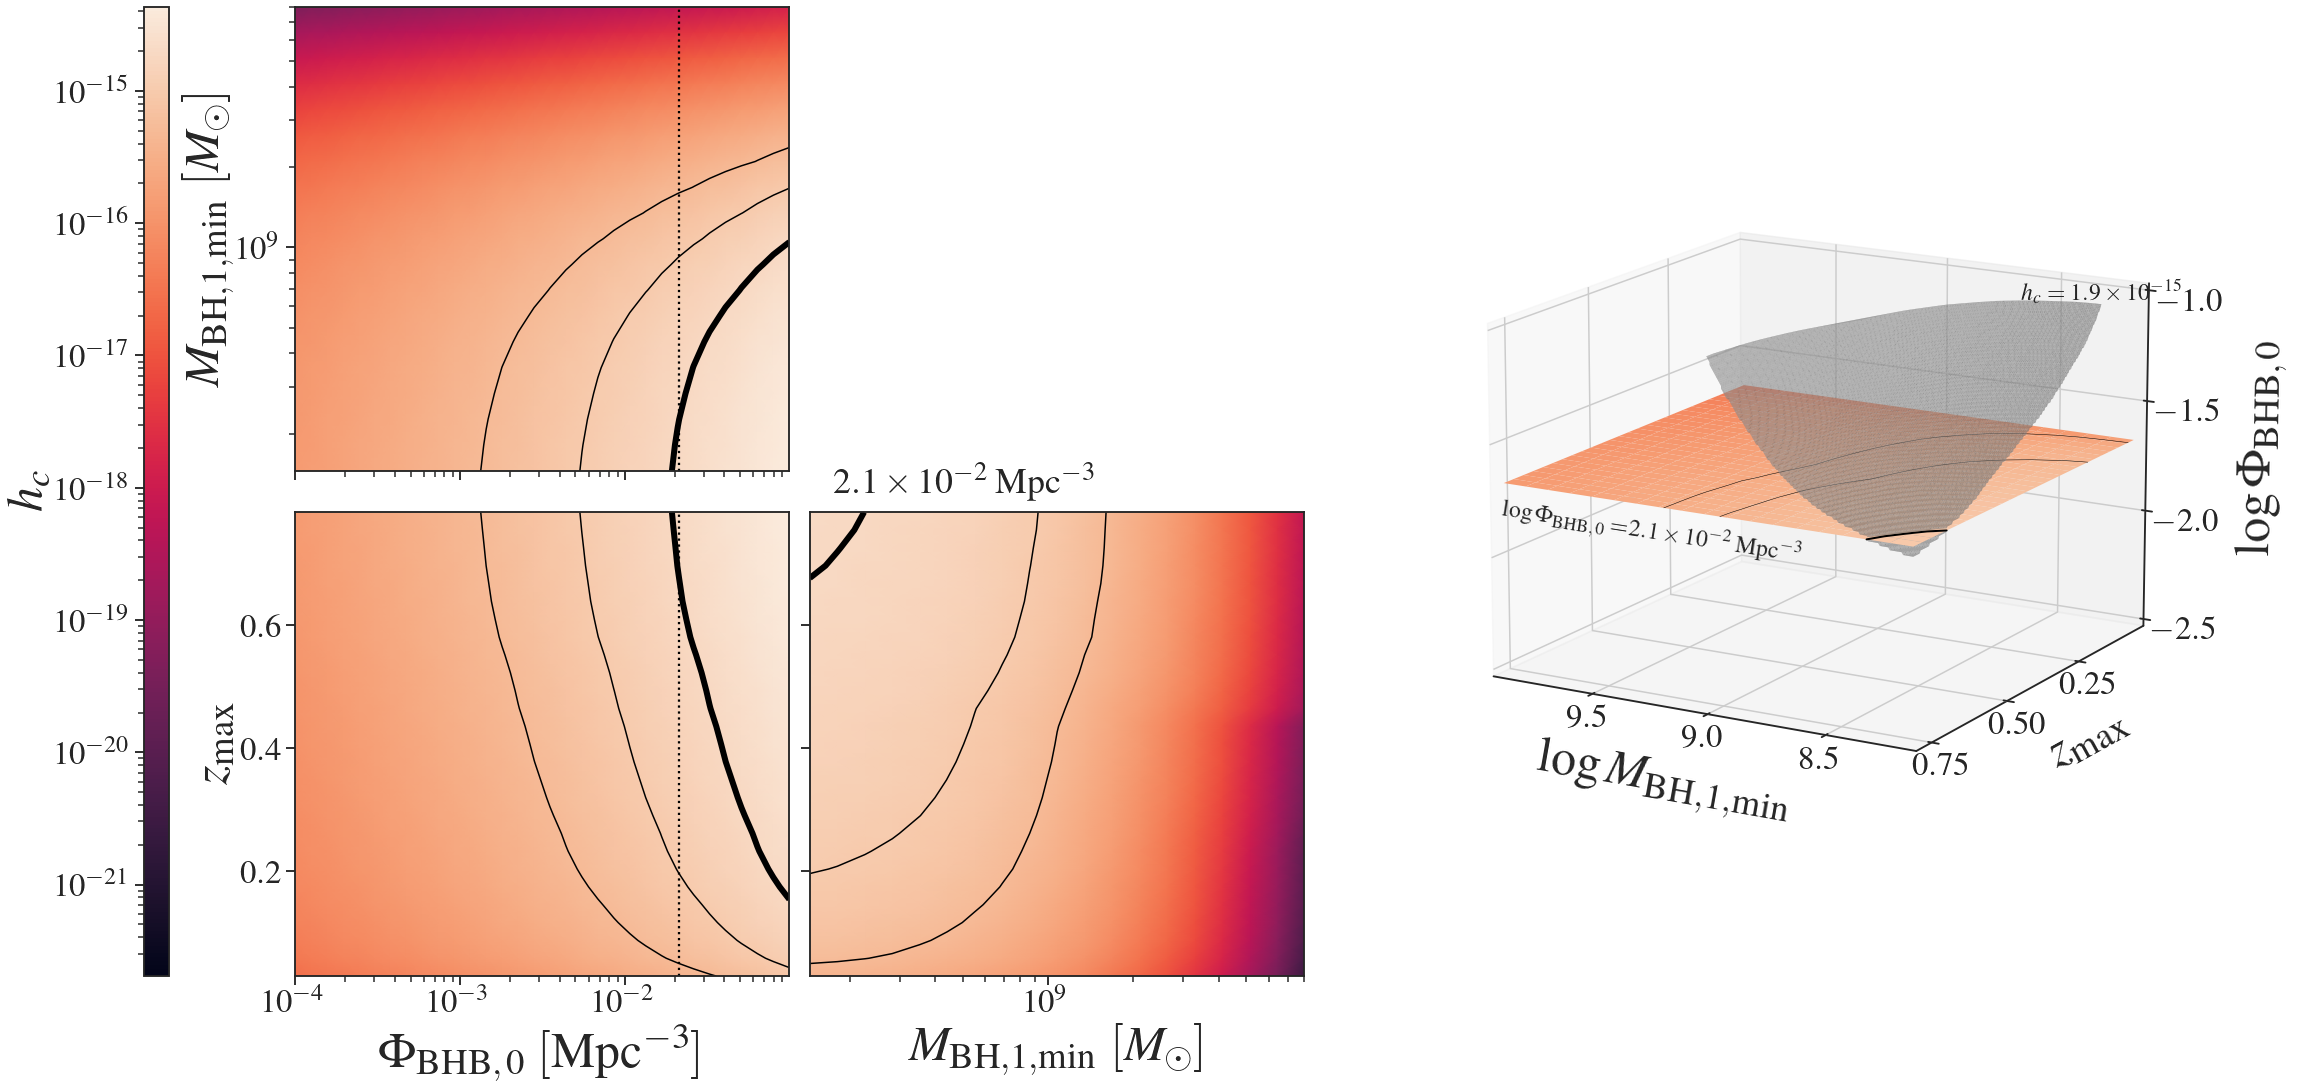

In [94]:
# corner plots
# %matplotlib inline
fmt = {}
strs = [r'$5 \times 10^{{-16}}$', r'$1 \times 10^{{-15}}$', r'$1.9 \times 10^{{-15}}$']
levels = [5e-16, 1e-15, NANOGrav_hc]
linewidths = [1.5, 1.5, 6]
labels = dict(zip(levels, strs))
cfont_size = 32
inline_spacing=1
inline=False
n_art_idx = 21
text_fs = 24

sns.set_context("talk", font_scale=2)

widths = [.05, 1, 1, 2]
heights = [1, 1]

order = 10. ** np.floor(np.log10(S1_local_number_density * NANOGrav_mult_factor_S1))
art_dens = r'${0:.1f} \times 10^{{{1:.0f}}} \; \rm{{Mpc}}^{{-3}}$'.format(S1_local_number_density * NANOGrav_mult_factor_S1 / order, np.log10(order))

fig_width = 30
fig_height = fig_width * np.sum(heights) / (np.sum(widths) + .1)

fig = plt.figure(figsize=(32, 15), constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=4, width_ratios=widths, height_ratios=heights)

cnorm = colors.LogNorm(vmin=np.amin(NANOGrav_hc_cube_S1),
                       vmax=np.amax(NANOGrav_hc_cube_S1))
cmap = sns.color_palette("rocket", as_cmap=True)
c = cmap(cnorm(np.abs(np.squeeze(NANOGrav_hc_cube_S1[log_m_bh_range_zoom_S1 == log_m_sat_S1, :, :]))))

# next the slices from 3D parameter space
mm_nn_ax = fig.add_subplot(gs[0, 1])
pcm = mm_nn_ax.pcolormesh(np.squeeze(NANOGrav_nn_cube_S1[:, z_range_zoom_S1 == z_sat_S1, :]),
                          10 ** np.squeeze(NANOGrav_mm_cube_S1[:, z_range_zoom_S1 == z_sat_S1, :]),
                          np.squeeze(NANOGrav_hc_cube_S1[:, z_range_zoom_S1 == z_sat_S1, :]), norm=cnorm,
                          shading='gouraud')
cs = mm_nn_ax.contour(np.squeeze(NANOGrav_nn_cube_S1[:, z_range_zoom_S1 == z_sat_S1, :]),
                       np.squeeze(10 ** NANOGrav_mm_cube_S1[:, z_range_zoom_S1 == z_sat_S1, :]),
                       np.squeeze(NANOGrav_hc_cube_S1[:, z_range_zoom_S1 == z_sat_S1, :]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
# for i, (cl, lbl) in enumerate(zip(cs.collections, strs)):
# p = cs.collections[0].get_paths()[0]
# v = p.vertices
# x = v[:, 0]
# y = v[:, 1]

# mid = int(np.trunc(len(x) / 2)) - 10
# rot = np.degrees(np.arctan2([np.log10(y[mid - 4]) - np.log10(y[mid - 10])], [np.log10(x[mid - 4]) - np.log10(x[mid - 10])]))[0]
# mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[0], rotation=rot,
#               verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

# p = cs.collections[1].get_paths()[0]
# v = p.vertices
# x = v[:, 0]
# y = v[:, 1]

# mid = int(np.trunc(len(x) / 2)) - 9
# rot = np.degrees(np.arctan2([np.log10(y[mid - 4]) - np.log10(y[mid - 6])], [np.log10(x[mid - 4]) - np.log10(x[mid - 6])]))[0]
# mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[1], rotation=rot,
#               verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

# p = cs.collections[2].get_paths()[0]
# v = p.vertices
# x = v[:, 0]
# y = v[:, 1]

# mid = int(np.trunc(len(x) / 2)) - 5
# rot = np.degrees(np.arctan2([np.log10(y[mid - 2]) - np.log10(y[0])], [np.log10(x[mid - 2]) - np.log10(x[0])]))[0]
# mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[2], rotation=rot,
#               verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

mm_nn_ax.axvline(S1_local_number_density * NANOGrav_mult_factor_S1, color='k', linestyle=':')
# mm_nn_ax.text(S1_local_number_density * NANOGrav_mult_factor_S1, 10 ** (np.max(log_m_bh_range_zoom_S1) - .01), art_dens, rotation='vertical',
#               horizontalalignment='right', verticalalignment='bottom', rotation_mode='anchor', fontsize=text_fs)
mm_nn_ax.set_ylabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
mm_nn_ax.set_yscale('log')
mm_nn_ax.set_xscale('log')
plt.setp(mm_nn_ax.get_xticklabels(), visible=False)

zz_nn_ax = fig.add_subplot(gs[1, 1], sharex=mm_nn_ax)
pcm = zz_nn_ax.pcolormesh(np.squeeze(NANOGrav_nn_cube_S1[log_m_bh_range_zoom_S1 == log_m_sat_S1, :, :]),
                          np.squeeze(NANOGrav_zz_cube_S1[log_m_bh_range_zoom_S1 == log_m_sat_S1, :, :]),
                          np.squeeze(NANOGrav_hc_cube_S1[log_m_bh_range_zoom_S1 == log_m_sat_S1, :, :]), norm=cnorm,
                          shading='gouraud')
cs = zz_nn_ax.contour(np.squeeze(NANOGrav_nn_cube_S1[log_m_bh_range_zoom_S1 == log_m_sat_S1, :, :]),
                       np.squeeze(NANOGrav_zz_cube_S1[log_m_bh_range_zoom_S1 == log_m_sat_S1, :, :]),
                       np.squeeze(NANOGrav_hc_cube_S1[log_m_bh_range_zoom_S1 == log_m_sat_S1, :, :]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
# for cl, lbl in zip(cs.collections, strs):
#     p = cl.get_paths()[0]
#     v = p.vertices
#     x = v[:, 0]
#     y = v[:, 1]
    
#     mid = int(np.trunc(len(x) / 2))
    
#     rot = np.degrees(np.arctan2([y[-1] - y[0]], [np.log10(x[-1]) - np.log10(x[0])]))[0] - 20
    
#     zz_nn_ax.text(x[mid + 2], y[mid - 4], lbl, rotation=rot,
#                   verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)
    
zz_nn_ax.axvline(S1_local_number_density * NANOGrav_mult_factor_S1, color='k', linestyle=':')
# zz_nn_ax.text(S1_local_number_density * NANOGrav_mult_factor_S1, np.min(z_range_zoom_S1) + .01, art_dens, rotation='vertical',
#               horizontalalignment='left', verticalalignment='bottom', rotation_mode='anchor', fontsize=text_fs)
zz_nn_ax.set_xlabel(r'$\Phi_{\rm{BHB},\,0}\ [\rm{Mpc}^{-3}]$', fontsize=label_fsize)
zz_nn_ax.set_xscale('log')
zz_nn_ax.set_ylabel(r'$z_{\rm{max}}$', fontsize=label_fsize)

zz_mm_ax = fig.add_subplot(gs[1, 2], sharey=zz_nn_ax)
pcm = zz_mm_ax.pcolormesh(10 ** np.squeeze(NANOGrav_mm_cube_S1[:, :, NANOGrav_n_artificial_range_S1 == NANOGrav_mult_factor_sqrt_S1]),
                          np.squeeze(NANOGrav_zz_cube_S1[:, :, NANOGrav_n_artificial_range_S1 == NANOGrav_mult_factor_sqrt_S1]),
                          np.squeeze(NANOGrav_hc_cube_S1[:, :, NANOGrav_n_artificial_range_S1 == NANOGrav_mult_factor_sqrt_S1]),
                          norm=cnorm, shading='gouraud')
cs = zz_mm_ax.contour(10 ** np.squeeze(NANOGrav_mm_cube_S1[:, :, NANOGrav_n_artificial_range_S1 == NANOGrav_mult_factor_sqrt_S1]),
                       np.squeeze(NANOGrav_zz_cube_S1[:, :, NANOGrav_n_artificial_range_S1 == NANOGrav_mult_factor_sqrt_S1]),
                       np.squeeze(NANOGrav_hc_cube_S1[:, :, NANOGrav_n_artificial_range_S1 == NANOGrav_mult_factor_sqrt_S1]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
# for cl, lbl in zip(cs.collections, strs):
#     p = cl.get_paths()[0]
#     v = p.vertices
#     x = v[:, 0]
#     y = v[:, 1]
    
#     mid = int(np.trunc(len(x) / 2))
    
#     rot = np.degrees(np.arctan2([y[mid + 1] - y[mid - 1]], [np.log10(x[mid + 1]) - np.log10(x[mid - 1])]))[0]
    
#     zz_mm_ax.text(x[mid + 1], y[mid - 1], lbl, rotation=rot,
#                   verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

zz_mm_ax.set_xlabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
zz_mm_ax.set_xscale('log')
plt.setp(zz_mm_ax.get_yticklabels(), visible=False)

# add a colorbar
cb_ax = fig.add_subplot(gs[:, 0])
cb = plt.colorbar(pcm, cax=cb_ax)
cb.set_label(r'$h_{c}$', fontsize=label_fsize)

cb_ax.yaxis.set_ticks_position('left')
cb_ax.yaxis.set_label_position('left')

# add 3D plot
plot_3d_ax = fig.add_subplot(gs[:, 3], projection='3d')
tri_bottom = plot_3d_ax.plot_trisurf(NANOGrav_bottom_verts_S1[:, 0], NANOGrav_bottom_verts_S1[:,1], NANOGrav_bottom_verts_S1[:, 2], #vmin=-4,
                                     lw=0, color=clr[7], shade=True, lightsource=light, alpha=.8)
tri_top = plot_3d_ax.plot_trisurf(NANOGrav_top_verts_S1[:, 0], NANOGrav_top_verts_S1[:,1], NANOGrav_top_verts_S1[:, 2], #vmin=-4,
                                  lw=0, color=clr[7], shade=True, lightsource=light, alpha=.8)
surf = plot_3d_ax.plot_surface(NANOGrav_xx_3d_S1, NANOGrav_yy_3d_S1, NANOGrav_zz_3d_S1, shade=False, lightsource=light, 
                               facecolors=c, alpha=1, lw=0)
tri_bottom.set_sort_zpos(.5)
surf.set_sort_zpos(1.5)
tri_top.set_sort_zpos(2.5)

# custom contours
for i, cl in enumerate(cs.collections):
    p = cl.get_paths()[0]
    v = p.vertices
    x = v[:, 0]
    y = v[:, 1]
    
#     print(np.log10(x))
#     print(np.log10(NANOGrav_mult_factor * local_number_density))
    if i == 2:
        lw = 2
    else:
        lw = .5
    plot_3d_ax.plot(np.log10(x), y, NANOGrav_log_n_new_S1, color='k', zorder=3, linewidth=lw)

plot_3d_ax.text(np.max(NANOGrav_xx_3d_S1), np.max(NANOGrav_yy_3d_S1), NANOGrav_zz_3d_S1[0, 0] - .05,
                r'$\log \Phi_{\rm{BHB},\,0} = $' + art_dens,
                zdir='x', rotation_mode='anchor', verticalalignment='top',
                fontsize=text_fs, zorder=5)

density_label_x = NANOGrav_top_verts_S1[NANOGrav_top_verts_S1[:, 1] == NANOGrav_top_verts_S1[:, 1].min(), 0].max()
density_label_y = NANOGrav_top_verts_S1[NANOGrav_top_verts_S1[:, 1] == NANOGrav_top_verts_S1[:, 1].min(), 1][0]
density_label_z = NANOGrav_top_verts_S1[NANOGrav_top_verts_S1[:, 1] == NANOGrav_top_verts_S1[:, 1].min(), 2].max()
delta_x = density_label_x - NANOGrav_top_verts_S1[NANOGrav_top_verts_S1[:, 1] == NANOGrav_top_verts_S1[:, 1].min(), 0].min()
delta_z = density_label_z - NANOGrav_top_verts_S1[NANOGrav_top_verts_S1[:, 1] == NANOGrav_top_verts_S1[:, 1].min(), 2].min()
plot_3d_ax.text(density_label_x - (.5 * delta_x), density_label_y, density_label_z - (.5 * delta_z),
                r'$h_{c} = 1.9 \times 10^{-15}$',
                zdir=(delta_x, 0, delta_z), rotation_mode='anchor', 
                horizontalalignment='center', verticalalignment='bottom',
                fontsize=text_fs, zorder=5)
plot_3d_ax.set_xlim(log_m_bh_range_zoom_S1[0], log_m_bh_range_zoom_S1[-1])
plot_3d_ax.set_ylim(z_range_zoom_S1[-1], z_range_zoom_S1[0])
plot_3d_ax.set_zlim(-2.5, NANOGrav_log_n_range_S1[-1])
plot_3d_ax.set_xticks([8.5, 9, 9.5])
plot_3d_ax.set_yticks([.25, .5, .75])
plot_3d_ax.set_zticks([-2.5, -2, -1.5, -1])
plot_3d_ax.tick_params(axis='z', which='major', pad=25)
plot_3d_ax.view_init(azim=-60, elev=15)
plot_3d_ax.set_xlabel(r'$\log M_{\rm{BH}, 1, \min}$', fontsize=label_fsize, labelpad=50)
plot_3d_ax.set_ylabel(r'$z_{\rm{max}}$', fontsize=label_fsize, labelpad=40)
plot_3d_ax.set_zlabel(r'$\log \Phi_{\rm{BHB},\,0}$', fontsize=label_fsize, labelpad=70)
plot_3d_ax.dist = 13
plot_3d_ax.set_rasterized(True)

# plt.tight_layout(w_pad=w_pad)
fig.text(.36, .54, art_dens, horizontalalignment='left', verticalalignment='bottom')
plt.savefig('../reports/figures/corner_NANOGrav_S1.pdf')
plt.savefig('../reports/figures/corner_NANOGrav_S1.png')
plt.show()

### IPTA

KeyboardInterrupt: 

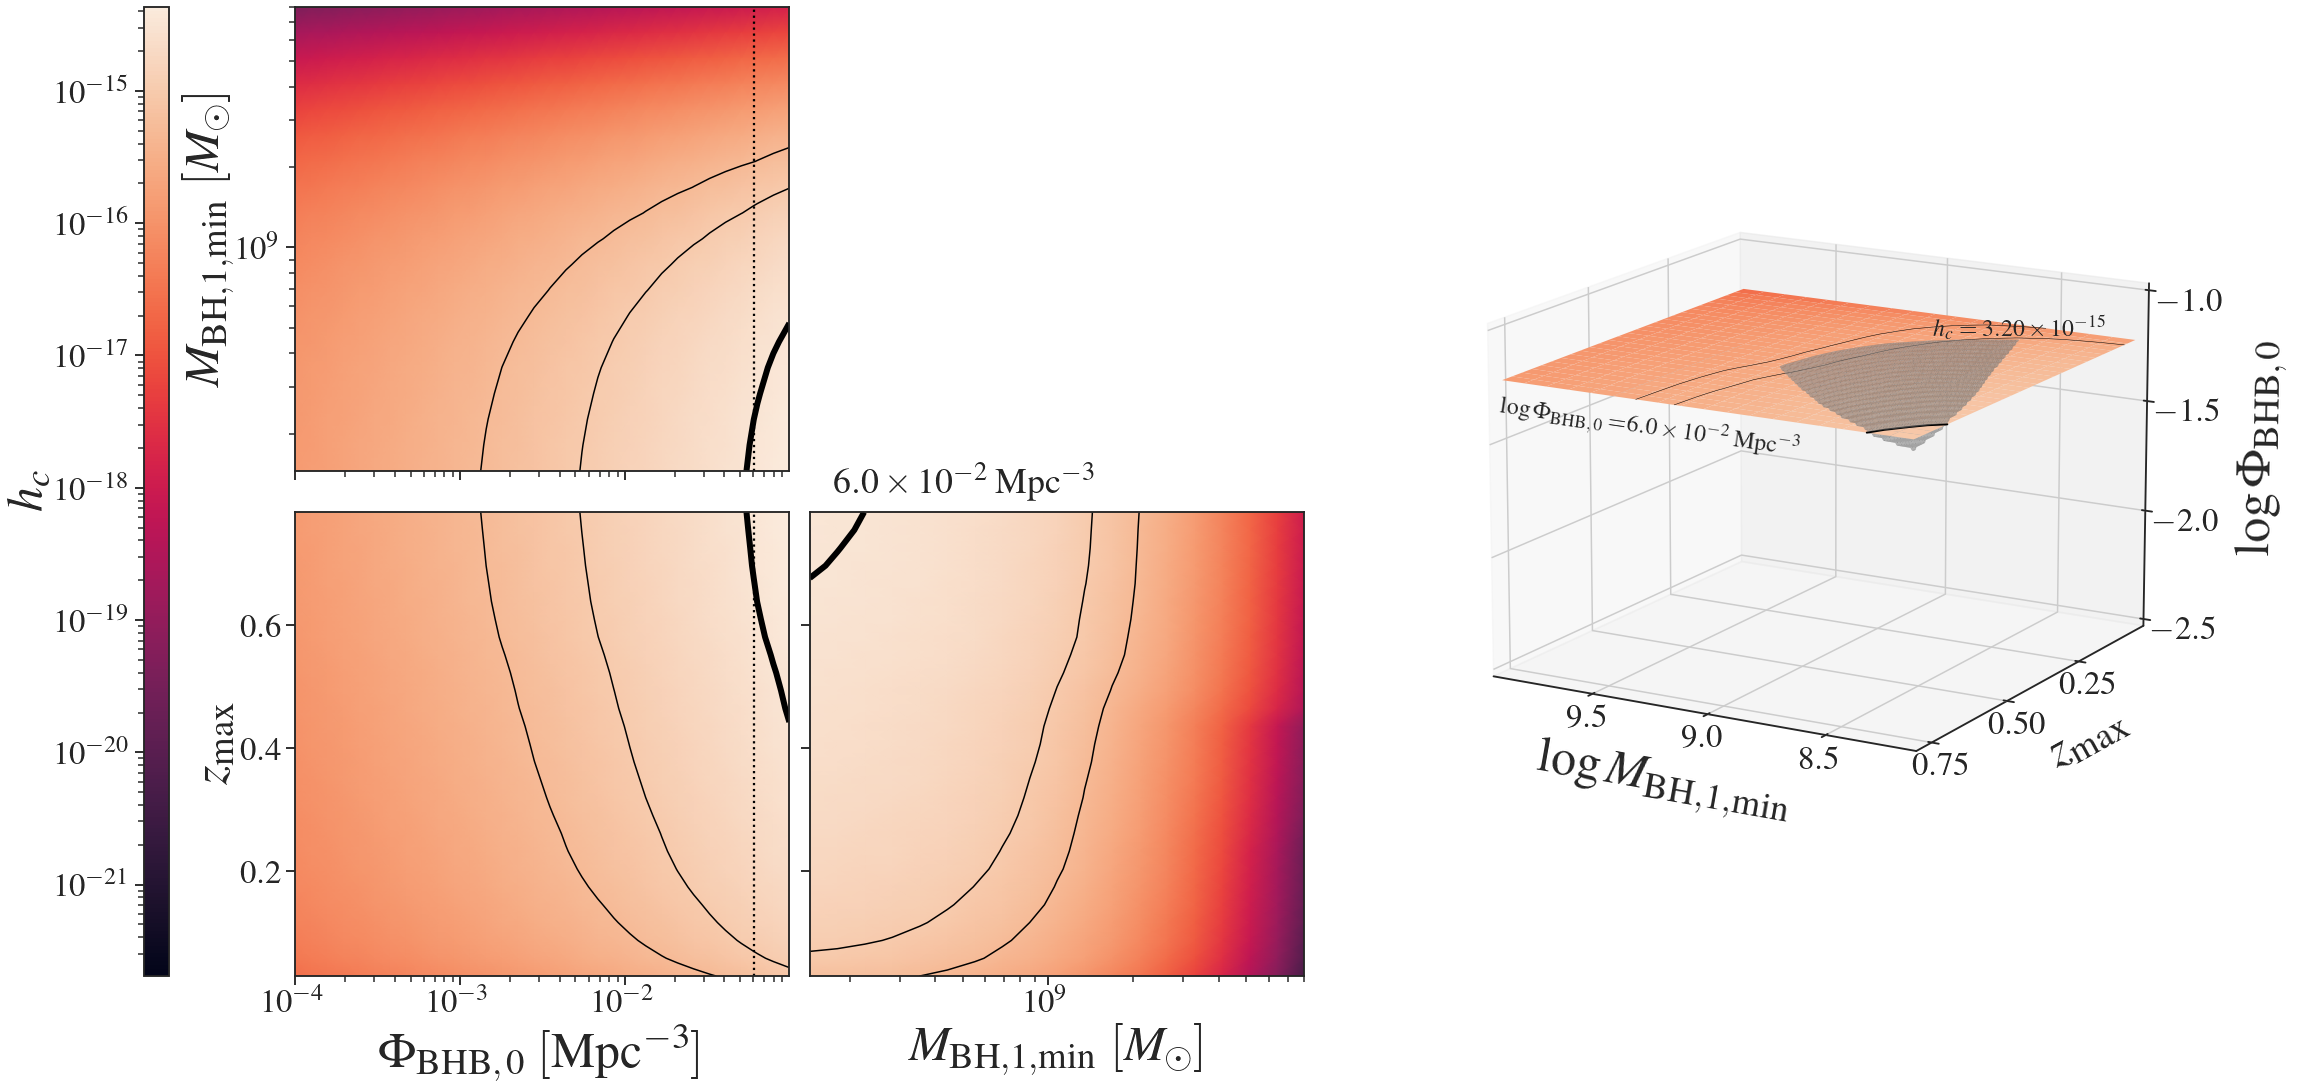

In [95]:
# corner plots
# %matplotlib inline
fmt = {}
strs = [r'$5 \times 10^{{-16}}$', r'$1 \times 10^{{-15}}$', r'$3.20 \times 10^{{-15}}$']
levels = [5e-16, 1e-15, IPTA_hc]
linewidths = [1.5, 1.5, 6]
labels = dict(zip(levels, strs))
cfont_size = 32
inline_spacing=1
inline=False
n_art_idx = 21
text_fs = 24

sns.set_context("talk", font_scale=2)

widths = [.05, 1, 1, 2]
heights = [1, 1]

order = 10. ** np.floor(np.log10(S1_local_number_density * IPTA_mult_factor_S1))
art_dens = r'${0:.1f} \times 10^{{{1:.0f}}} \; \rm{{Mpc}}^{{-3}}$'.format(S1_local_number_density * IPTA_mult_factor_S1 / order, np.log10(order))

fig_width = 30
fig_height = fig_width * np.sum(heights) / (np.sum(widths) + .1)

fig = plt.figure(figsize=(32, 15), constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=4, width_ratios=widths, height_ratios=heights)

cnorm = colors.LogNorm(vmin=np.amin(IPTA_hc_cube_S1),
                       vmax=np.amax(IPTA_hc_cube_S1))
cmap = sns.color_palette("rocket", as_cmap=True)
c = cmap(cnorm(np.abs(np.squeeze(IPTA_hc_cube_S1[log_m_bh_range_zoom_S1 == log_m_sat_S1, :, :]))))

# next the slices from 3D parameter space
mm_nn_ax = fig.add_subplot(gs[0, 1])
pcm = mm_nn_ax.pcolormesh(np.squeeze(IPTA_nn_cube_S1[:, z_range_zoom_S1 == z_sat_S1, :]),
                          10 ** np.squeeze(IPTA_mm_cube_S1[:, z_range_zoom_S1 == z_sat_S1, :]),
                          np.squeeze(IPTA_hc_cube_S1[:, z_range_zoom_S1 == z_sat_S1, :]), norm=cnorm,
                          shading='gouraud')
cs = mm_nn_ax.contour(np.squeeze(IPTA_nn_cube_S1[:, z_range_zoom_S1 == z_sat_S1, :]),
                       np.squeeze(10 ** IPTA_mm_cube_S1[:, z_range_zoom_S1 == z_sat_S1, :]),
                       np.squeeze(IPTA_hc_cube_S1[:, z_range_zoom_S1 == z_sat_S1, :]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
# for i, (cl, lbl) in enumerate(zip(cs.collections, strs)):
# p = cs.collections[0].get_paths()[0]
# v = p.vertices
# x = v[:, 0]
# y = v[:, 1]

# mid = int(np.trunc(len(x) / 2)) - 10
# rot = np.degrees(np.arctan2([np.log10(y[mid - 4]) - np.log10(y[mid - 10])], [np.log10(x[mid - 4]) - np.log10(x[mid - 10])]))[0]
# mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[0], rotation=rot,
#               verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

# p = cs.collections[1].get_paths()[0]
# v = p.vertices
# x = v[:, 0]
# y = v[:, 1]

# mid = int(np.trunc(len(x) / 2)) - 9
# rot = np.degrees(np.arctan2([np.log10(y[mid - 4]) - np.log10(y[mid - 6])], [np.log10(x[mid - 4]) - np.log10(x[mid - 6])]))[0]
# mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[1], rotation=rot,
#               verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

# p = cs.collections[2].get_paths()[0]
# v = p.vertices
# x = v[:, 0]
# y = v[:, 1]

# mid = int(np.trunc(len(x) / 2)) - 5
# rot = np.degrees(np.arctan2([np.log10(y[mid - 2]) - np.log10(y[0])], [np.log10(x[mid - 2]) - np.log10(x[0])]))[0]
# mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[2], rotation=rot,
#               verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

mm_nn_ax.axvline(S1_local_number_density * IPTA_mult_factor_S1, color='k', linestyle=':')
# mm_nn_ax.text(S1_local_number_density * IPTA_mult_factor_S1, 10 ** (np.max(log_m_bh_range_zoom_S1) - .01), art_dens, rotation='vertical',
#               horizontalalignment='right', verticalalignment='bottom', rotation_mode='anchor', fontsize=text_fs)
mm_nn_ax.set_ylabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
mm_nn_ax.set_yscale('log')
mm_nn_ax.set_xscale('log')
plt.setp(mm_nn_ax.get_xticklabels(), visible=False)

zz_nn_ax = fig.add_subplot(gs[1, 1], sharex=mm_nn_ax)
pcm = zz_nn_ax.pcolormesh(np.squeeze(IPTA_nn_cube_S1[log_m_bh_range_zoom_S1 == log_m_sat_S1, :, :]),
                          np.squeeze(IPTA_zz_cube_S1[log_m_bh_range_zoom_S1 == log_m_sat_S1, :, :]),
                          np.squeeze(IPTA_hc_cube_S1[log_m_bh_range_zoom_S1 == log_m_sat_S1, :, :]), norm=cnorm,
                          shading='gouraud')
cs = zz_nn_ax.contour(np.squeeze(IPTA_nn_cube_S1[log_m_bh_range_zoom_S1 == log_m_sat_S1, :, :]),
                       np.squeeze(IPTA_zz_cube_S1[log_m_bh_range_zoom_S1 == log_m_sat_S1, :, :]),
                       np.squeeze(IPTA_hc_cube_S1[log_m_bh_range_zoom_S1 == log_m_sat_S1, :, :]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
# for cl, lbl in zip(cs.collections, strs):
#     p = cl.get_paths()[0]
#     v = p.vertices
#     x = v[:, 0]
#     y = v[:, 1]
    
#     mid = int(np.trunc(len(x) / 2))
    
#     rot = np.degrees(np.arctan2([y[-1] - y[0]], [np.log10(x[-1]) - np.log10(x[0])]))[0] - 20
    
#     zz_nn_ax.text(x[mid + 2], y[mid - 4], lbl, rotation=rot,
#                   verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)
    
zz_nn_ax.axvline(S1_local_number_density * IPTA_mult_factor_S1, color='k', linestyle=':')
# zz_nn_ax.text(S1_local_number_density * IPTA_mult_factor_S1, np.min(z_range_zoom_S1) + .01, art_dens, rotation='vertical',
#               horizontalalignment='left', verticalalignment='bottom', rotation_mode='anchor', fontsize=text_fs)
zz_nn_ax.set_xlabel(r'$\Phi_{\rm{BHB},\,0}\ [\rm{Mpc}^{-3}]$', fontsize=label_fsize)
zz_nn_ax.set_xscale('log')
zz_nn_ax.set_ylabel(r'$z_{\rm{max}}$', fontsize=label_fsize)

zz_mm_ax = fig.add_subplot(gs[1, 2], sharey=zz_nn_ax)
pcm = zz_mm_ax.pcolormesh(10 ** np.squeeze(IPTA_mm_cube_S1[:, :, IPTA_n_artificial_range_S1 == IPTA_mult_factor_sqrt_S1]),
                          np.squeeze(IPTA_zz_cube_S1[:, :, IPTA_n_artificial_range_S1 == IPTA_mult_factor_sqrt_S1]),
                          np.squeeze(IPTA_hc_cube_S1[:, :, IPTA_n_artificial_range_S1 == IPTA_mult_factor_sqrt_S1]),
                          norm=cnorm, shading='gouraud')
cs = zz_mm_ax.contour(10 ** np.squeeze(IPTA_mm_cube_S1[:, :, IPTA_n_artificial_range_S1 == IPTA_mult_factor_sqrt_S1]),
                       np.squeeze(IPTA_zz_cube_S1[:, :, IPTA_n_artificial_range_S1 == IPTA_mult_factor_sqrt_S1]),
                       np.squeeze(IPTA_hc_cube_S1[:, :, IPTA_n_artificial_range_S1 == IPTA_mult_factor_sqrt_S1]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
# for cl, lbl in zip(cs.collections, strs):
#     p = cl.get_paths()[0]
#     v = p.vertices
#     x = v[:, 0]
#     y = v[:, 1]
    
#     mid = int(np.trunc(len(x) / 2))
    
#     rot = np.degrees(np.arctan2([y[mid + 1] - y[mid - 1]], [np.log10(x[mid + 1]) - np.log10(x[mid - 1])]))[0]
    
#     zz_mm_ax.text(x[mid + 1], y[mid - 1], lbl, rotation=rot,
#                   verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

zz_mm_ax.set_xlabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
zz_mm_ax.set_xscale('log')
plt.setp(zz_mm_ax.get_yticklabels(), visible=False)

# add a colorbar
cb_ax = fig.add_subplot(gs[:, 0])
cb = plt.colorbar(pcm, cax=cb_ax)
cb.set_label(r'$h_{c}$', fontsize=label_fsize)

cb_ax.yaxis.set_ticks_position('left')
cb_ax.yaxis.set_label_position('left')

# add 3D plot
plot_3d_ax = fig.add_subplot(gs[:, 3], projection='3d')
tri_bottom = plot_3d_ax.plot_trisurf(IPTA_bottom_verts_S1[:, 0], IPTA_bottom_verts_S1[:,1], IPTA_bottom_verts_S1[:, 2], #vmin=-4,
                                     lw=0, color=clr[7], shade=True, lightsource=light, alpha=.8)
tri_top = plot_3d_ax.plot_trisurf(IPTA_top_verts_S1[:, 0], IPTA_top_verts_S1[:,1], IPTA_top_verts_S1[:, 2], #vmin=-4,
                                  lw=0, color=clr[7], shade=True, lightsource=light, alpha=.8)
surf = plot_3d_ax.plot_surface(IPTA_xx_3d_S1, IPTA_yy_3d_S1, IPTA_zz_3d_S1, shade=False, lightsource=light, 
                               facecolors=c, alpha=1, lw=0)
tri_bottom.set_sort_zpos(.5)
surf.set_sort_zpos(1.5)
tri_top.set_sort_zpos(2.5)

# custom contours
for i, cl in enumerate(cs.collections):
    p = cl.get_paths()[0]
    v = p.vertices
    x = v[:, 0]
    y = v[:, 1]
    
#     print(np.log10(x))
#     print(np.log10(IPTA_mult_factor * local_number_density))
    if i == 2:
        lw = 2
    else:
        lw = .5
    plot_3d_ax.plot(np.log10(x), y, IPTA_log_n_new_S1, color='k', zorder=3, linewidth=lw)

plot_3d_ax.text(np.max(IPTA_xx_3d_S1), np.max(IPTA_yy_3d_S1), IPTA_zz_3d_S1[0, 0] - .05,
                r'$\log \Phi_{\rm{BHB},\,0} = $' + art_dens,
                zdir='x', rotation_mode='anchor', verticalalignment='top',
                fontsize=text_fs, zorder=5)

density_label_x = IPTA_top_verts_S1[IPTA_top_verts_S1[:, 1] == IPTA_top_verts_S1[:, 1].min(), 0].max()
density_label_y = IPTA_top_verts_S1[IPTA_top_verts_S1[:, 1] == IPTA_top_verts_S1[:, 1].min(), 1][0]
density_label_z = IPTA_top_verts_S1[IPTA_top_verts_S1[:, 1] == IPTA_top_verts_S1[:, 1].min(), 2].max()
delta_x = density_label_x - IPTA_top_verts_S1[IPTA_top_verts_S1[:, 1] == IPTA_top_verts_S1[:, 1].min(), 0].min()
delta_z = density_label_z - IPTA_top_verts_S1[IPTA_top_verts_S1[:, 1] == IPTA_top_verts_S1[:, 1].min(), 2].min()
plot_3d_ax.text(density_label_x - (.5 * delta_x), density_label_y, density_label_z - (.5 * delta_z),
                r'$h_{c} = 3.20 \times 10^{-15}$',
                zdir=(delta_x, 0, delta_z), rotation_mode='anchor', 
                horizontalalignment='center', verticalalignment='bottom',
                fontsize=text_fs, zorder=5)
plot_3d_ax.set_xlim(log_m_bh_range_zoom_S1[0], log_m_bh_range_zoom_S1[-1])
plot_3d_ax.set_ylim(z_range_zoom_S1[-1], z_range_zoom_S1[0])
plot_3d_ax.set_zlim(-2.5, IPTA_log_n_range_S1[-1])
plot_3d_ax.set_xticks([8.5, 9, 9.5])
plot_3d_ax.set_yticks([.25, .5, .75])
plot_3d_ax.set_zticks([-2.5, -2, -1.5, -1])
plot_3d_ax.tick_params(axis='z', which='major', pad=25)
plot_3d_ax.view_init(azim=-60, elev=15)
plot_3d_ax.set_xlabel(r'$\log M_{\rm{BH}, 1, \min}$', fontsize=label_fsize, labelpad=50)
plot_3d_ax.set_ylabel(r'$z_{\rm{max}}$', fontsize=label_fsize, labelpad=40)
plot_3d_ax.set_zlabel(r'$\log \Phi_{\rm{BHB},\,0}$', fontsize=label_fsize, labelpad=70)
plot_3d_ax.dist = 13
plot_3d_ax.set_rasterized(True)

# plt.tight_layout(w_pad=w_pad)
fig.text(.36, .54, art_dens, horizontalalignment='left', verticalalignment='bottom')
plt.savefig('../reports/figures/corner_IPTA_S1.pdf')
plt.savefig('../reports/figures/corner_IPTA_S1.png')
plt.show()

## S2

### NANOGrav

In [ ]:
# corner plots
# %matplotlib inline
fmt = {}
strs = [r'$5 \times 10^{{-16}}$', r'$1 \times 10^{{-15}}$', r'$1.9 \times 10^{{-15}}$']
levels = [5e-16, 1e-15, NANOGrav_hc]
linewidths = [1.5, 1.5, 6]
labels = dict(zip(levels, strs))
cfont_size = 32
inline_spacing=1
inline=False
n_art_idx = 21
text_fs = 24

sns.set_context("talk", font_scale=2)

widths = [.05, 1, 1, 2]
heights = [1, 1]

order = 10. ** np.floor(np.log10(S2_local_number_density * NANOGrav_mult_factor_S2))
art_dens = r'${0:.1f} \times 10^{{{1:.0f}}} \; \rm{{Mpc}}^{{-3}}$'.format(S2_local_number_density * NANOGrav_mult_factor_S2 / order, np.log10(order))

fig_width = 30
fig_height = fig_width * np.sum(heights) / (np.sum(widths) + .1)

fig = plt.figure(figsize=(32, 15), constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=4, width_ratios=widths, height_ratios=heights)

cnorm = colors.LogNorm(vmin=np.amin(NANOGrav_hc_cube_S2),
                       vmax=np.amax(NANOGrav_hc_cube_S2))
cmap = sns.color_palette("rocket", as_cmap=True)
c = cmap(cnorm(np.abs(np.squeeze(NANOGrav_hc_cube_S2[log_m_bh_range_zoom_S2 == log_m_sat_S2, :, :]))))

# next the slices from 3D parameter space
mm_nn_ax = fig.add_subplot(gs[0, 1])
pcm = mm_nn_ax.pcolormesh(np.squeeze(NANOGrav_nn_cube_S2[:, z_range_zoom_S2 == z_sat_S2, :]),
                          10 ** np.squeeze(NANOGrav_mm_cube_S2[:, z_range_zoom_S2 == z_sat_S2, :]),
                          np.squeeze(NANOGrav_hc_cube_S2[:, z_range_zoom_S2 == z_sat_S2, :]), norm=cnorm,
                          shading='gouraud')
cs = mm_nn_ax.contour(np.squeeze(NANOGrav_nn_cube_S2[:, z_range_zoom_S2 == z_sat_S2, :]),
                       np.squeeze(10 ** NANOGrav_mm_cube_S2[:, z_range_zoom_S2 == z_sat_S2, :]),
                       np.squeeze(NANOGrav_hc_cube_S2[:, z_range_zoom_S2 == z_sat_S2, :]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
# for i, (cl, lbl) in enumerate(zip(cs.collections, strs)):
# p = cs.collections[0].get_paths()[0]
# v = p.vertices
# x = v[:, 0]
# y = v[:, 1]

# mid = int(np.trunc(len(x) / 2)) - 10
# rot = np.degrees(np.arctan2([np.log10(y[mid - 4]) - np.log10(y[mid - 10])], [np.log10(x[mid - 4]) - np.log10(x[mid - 10])]))[0]
# mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[0], rotation=rot,
#               verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

# p = cs.collections[1].get_paths()[0]
# v = p.vertices
# x = v[:, 0]
# y = v[:, 1]

# mid = int(np.trunc(len(x) / 2)) - 9
# rot = np.degrees(np.arctan2([np.log10(y[mid - 4]) - np.log10(y[mid - 6])], [np.log10(x[mid - 4]) - np.log10(x[mid - 6])]))[0]
# mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[1], rotation=rot,
#               verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

# p = cs.collections[2].get_paths()[0]
# v = p.vertices
# x = v[:, 0]
# y = v[:, 1]

# mid = int(np.trunc(len(x) / 2)) - 5
# rot = np.degrees(np.arctan2([np.log10(y[mid - 2]) - np.log10(y[0])], [np.log10(x[mid - 2]) - np.log10(x[0])]))[0]
# mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[2], rotation=rot,
#               verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

mm_nn_ax.axvline(S2_local_number_density * NANOGrav_mult_factor_S2, color='k', linestyle=':')
# mm_nn_ax.text(S2_local_number_density * NANOGrav_mult_factor_S2, 10 ** (np.max(log_m_bh_range_zoom_S2) - .01), art_dens, rotation='vertical',
#               horizontalalignment='right', verticalalignment='bottom', rotation_mode='anchor', fontsize=text_fs)
mm_nn_ax.set_ylabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
mm_nn_ax.set_yscale('log')
mm_nn_ax.set_xscale('log')
plt.setp(mm_nn_ax.get_xticklabels(), visible=False)

zz_nn_ax = fig.add_subplot(gs[1, 1], sharex=mm_nn_ax)
pcm = zz_nn_ax.pcolormesh(np.squeeze(NANOGrav_nn_cube_S2[log_m_bh_range_zoom_S2 == log_m_sat_S2, :, :]),
                          np.squeeze(NANOGrav_zz_cube_S2[log_m_bh_range_zoom_S2 == log_m_sat_S2, :, :]),
                          np.squeeze(NANOGrav_hc_cube_S2[log_m_bh_range_zoom_S2 == log_m_sat_S2, :, :]), norm=cnorm,
                          shading='gouraud')
cs = zz_nn_ax.contour(np.squeeze(NANOGrav_nn_cube_S2[log_m_bh_range_zoom_S2 == log_m_sat_S2, :, :]),
                       np.squeeze(NANOGrav_zz_cube_S2[log_m_bh_range_zoom_S2 == log_m_sat_S2, :, :]),
                       np.squeeze(NANOGrav_hc_cube_S2[log_m_bh_range_zoom_S2 == log_m_sat_S2, :, :]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
# for cl, lbl in zip(cs.collections, strs):
#     p = cl.get_paths()[0]
#     v = p.vertices
#     x = v[:, 0]
#     y = v[:, 1]
    
#     mid = int(np.trunc(len(x) / 2))
    
#     rot = np.degrees(np.arctan2([y[-1] - y[0]], [np.log10(x[-1]) - np.log10(x[0])]))[0] - 20
    
#     zz_nn_ax.text(x[mid + 2], y[mid - 4], lbl, rotation=rot,
#                   verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)
    
zz_nn_ax.axvline(S2_local_number_density * NANOGrav_mult_factor_S2, color='k', linestyle=':')
# zz_nn_ax.text(S2_local_number_density * NANOGrav_mult_factor_S2, np.min(z_range_zoom_S2) + .01, art_dens, rotation='vertical',
#               horizontalalignment='left', verticalalignment='bottom', rotation_mode='anchor', fontsize=text_fs)
zz_nn_ax.set_xlabel(r'$\Phi_{\rm{BHB},\,0}\ [\rm{Mpc}^{-3}]$', fontsize=label_fsize)
zz_nn_ax.set_xscale('log')
zz_nn_ax.set_ylabel(r'$z_{\rm{max}}$', fontsize=label_fsize)

zz_mm_ax = fig.add_subplot(gs[1, 2], sharey=zz_nn_ax)
pcm = zz_mm_ax.pcolormesh(10 ** np.squeeze(NANOGrav_mm_cube_S2[:, :, NANOGrav_n_artificial_range_S2 == NANOGrav_mult_factor_sqrt_S2]),
                          np.squeeze(NANOGrav_zz_cube_S2[:, :, NANOGrav_n_artificial_range_S2 == NANOGrav_mult_factor_sqrt_S2]),
                          np.squeeze(NANOGrav_hc_cube_S2[:, :, NANOGrav_n_artificial_range_S2 == NANOGrav_mult_factor_sqrt_S2]),
                          norm=cnorm, shading='gouraud')
cs = zz_mm_ax.contour(10 ** np.squeeze(NANOGrav_mm_cube_S2[:, :, NANOGrav_n_artificial_range_S2 == NANOGrav_mult_factor_sqrt_S2]),
                       np.squeeze(NANOGrav_zz_cube_S2[:, :, NANOGrav_n_artificial_range_S2 == NANOGrav_mult_factor_sqrt_S2]),
                       np.squeeze(NANOGrav_hc_cube_S2[:, :, NANOGrav_n_artificial_range_S2 == NANOGrav_mult_factor_sqrt_S2]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
# for cl, lbl in zip(cs.collections, strs):
#     p = cl.get_paths()[0]
#     v = p.vertices
#     x = v[:, 0]
#     y = v[:, 1]
    
#     mid = int(np.trunc(len(x) / 2))
    
#     rot = np.degrees(np.arctan2([y[mid + 1] - y[mid - 1]], [np.log10(x[mid + 1]) - np.log10(x[mid - 1])]))[0]
    
#     zz_mm_ax.text(x[mid + 1], y[mid - 1], lbl, rotation=rot,
#                   verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

zz_mm_ax.set_xlabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
zz_mm_ax.set_xscale('log')
plt.setp(zz_mm_ax.get_yticklabels(), visible=False)

# add a colorbar
cb_ax = fig.add_subplot(gs[:, 0])
cb = plt.colorbar(pcm, cax=cb_ax)
cb.set_label(r'$h_{c}$', fontsize=label_fsize)

cb_ax.yaxis.set_ticks_position('left')
cb_ax.yaxis.set_label_position('left')

# add 3D plot
plot_3d_ax = fig.add_subplot(gs[:, 3], projection='3d')
tri_bottom = plot_3d_ax.plot_trisurf(NANOGrav_bottom_verts_S2[:, 0], NANOGrav_bottom_verts_S2[:,1], NANOGrav_bottom_verts_S2[:, 2], #vmin=-4,
                                     lw=0, color=clr[7], shade=True, lightsource=light, alpha=.8)
tri_top = plot_3d_ax.plot_trisurf(NANOGrav_top_verts_S2[:, 0], NANOGrav_top_verts_S2[:,1], NANOGrav_top_verts_S2[:, 2], #vmin=-4,
                                  lw=0, color=clr[7], shade=True, lightsource=light, alpha=.8)
surf = plot_3d_ax.plot_surface(NANOGrav_xx_3d_S2, NANOGrav_yy_3d_S2, NANOGrav_zz_3d_S2, shade=False, lightsource=light, 
                               facecolors=c, alpha=1, lw=0)
tri_bottom.set_sort_zpos(.5)
surf.set_sort_zpos(1.5)
tri_top.set_sort_zpos(2.5)

# custom contours
for i, cl in enumerate(cs.collections):
    p = cl.get_paths()[0]
    v = p.vertices
    x = v[:, 0]
    y = v[:, 1]
    
#     print(np.log10(x))
#     print(np.log10(NANOGrav_mult_factor * local_number_density))
    if i == 2:
        lw = 2
    else:
        lw = .5
    plot_3d_ax.plot(np.log10(x), y, NANOGrav_log_n_new_S2, color='k', zorder=3, linewidth=lw)

plot_3d_ax.text(np.max(NANOGrav_xx_3d_S2), np.max(NANOGrav_yy_3d_S2), NANOGrav_zz_3d_S2[0, 0] - .05,
                r'$\log \Phi_{\rm{BHB},\,0} = $' + art_dens,
                zdir='x', rotation_mode='anchor', verticalalignment='top',
                fontsize=text_fs, zorder=5)

density_label_x = NANOGrav_top_verts_S2[NANOGrav_top_verts_S2[:, 1] == NANOGrav_top_verts_S2[:, 1].min(), 0].max()
density_label_y = NANOGrav_top_verts_S2[NANOGrav_top_verts_S2[:, 1] == NANOGrav_top_verts_S2[:, 1].min(), 1][0]
density_label_z = NANOGrav_top_verts_S2[NANOGrav_top_verts_S2[:, 1] == NANOGrav_top_verts_S2[:, 1].min(), 2].max()
delta_x = density_label_x - NANOGrav_top_verts_S2[NANOGrav_top_verts_S2[:, 1] == NANOGrav_top_verts_S2[:, 1].min(), 0].min()
delta_z = density_label_z - NANOGrav_top_verts_S2[NANOGrav_top_verts_S2[:, 1] == NANOGrav_top_verts_S2[:, 1].min(), 2].min()
plot_3d_ax.text(density_label_x - (.5 * delta_x), density_label_y, density_label_z - (.5 * delta_z),
                r'$h_{c} = 1.9 \times 10^{-15}$',
                zdir=(delta_x, 0, delta_z), rotation_mode='anchor', 
                horizontalalignment='center', verticalalignment='bottom',
                fontsize=text_fs, zorder=5)
plot_3d_ax.set_xlim(log_m_bh_range_zoom_S2[0], log_m_bh_range_zoom_S2[-1])
plot_3d_ax.set_ylim(z_range_zoom_S2[-1], z_range_zoom_S2[0])
plot_3d_ax.set_zlim(-1.5, NANOGrav_log_n_range_S2[-1])
plot_3d_ax.set_xticks([8.5, 9, 9.5])
plot_3d_ax.set_yticks([.25, .5, .75])
plot_3d_ax.set_zticks([-2.5, -2, -1.5, -1])
plot_3d_ax.tick_params(axis='z', which='major', pad=25)
plot_3d_ax.view_init(azim=-60, elev=15)
plot_3d_ax.set_xlabel(r'$\log M_{\rm{BH}, 1, \min}$', fontsize=label_fsize, labelpad=50)
plot_3d_ax.set_ylabel(r'$z_{\rm{max}}$', fontsize=label_fsize, labelpad=40)
plot_3d_ax.set_zlabel(r'$\log \Phi_{\rm{BHB},\,0}$', fontsize=label_fsize, labelpad=70)
plot_3d_ax.dist = 13
plot_3d_ax.set_rasterized(True)

# plt.tight_layout(w_pad=w_pad)
fig.text(.36, .54, art_dens, horizontalalignment='left', verticalalignment='bottom')
plt.savefig('../reports/figures/corner_NANOGrav_S2.pdf')
plt.savefig('../reports/figures/corner_NANOGrav_S2.png')
plt.show()

### IPTA

In [ ]:
# corner plots
# %matplotlib inline
fmt = {}
strs = [r'$5 \times 10^{{-16}}$', r'$1 \times 10^{{-15}}$', r'$3.20 \times 10^{{-15}}$']
levels = [5e-16, 1e-15, IPTA_hc]
linewidths = [1.5, 1.5, 6]
labels = dict(zip(levels, strs))
cfont_size = 32
inline_spacing=1
inline=False
n_art_idx = 21
text_fs = 24

sns.set_context("talk", font_scale=2)

widths = [.05, 1, 1, 2]
heights = [1, 1]

order = 10. ** np.floor(np.log10(S2_local_number_density * IPTA_mult_factor_S2))
art_dens = r'${0:.1f} \times 10^{{{1:.0f}}} \; \rm{{Mpc}}^{{-3}}$'.format(S2_local_number_density * IPTA_mult_factor_S2 / order, np.log10(order))

fig_width = 30
fig_height = fig_width * np.sum(heights) / (np.sum(widths) + .1)

fig = plt.figure(figsize=(32, 15), constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=4, width_ratios=widths, height_ratios=heights)

cnorm = colors.LogNorm(vmin=np.amin(IPTA_hc_cube_S2),
                       vmax=np.amax(IPTA_hc_cube_S2))
cmap = sns.color_palette("rocket", as_cmap=True)
c = cmap(cnorm(np.abs(np.squeeze(IPTA_hc_cube_S2[log_m_bh_range_zoom_S2 == log_m_sat_S2, :, :]))))

# next the slices from 3D parameter space
mm_nn_ax = fig.add_subplot(gs[0, 1])
pcm = mm_nn_ax.pcolormesh(np.squeeze(IPTA_nn_cube_S2[:, z_range_zoom_S2 == z_sat_S2, :]),
                          10 ** np.squeeze(IPTA_mm_cube_S2[:, z_range_zoom_S2 == z_sat_S2, :]),
                          np.squeeze(IPTA_hc_cube_S2[:, z_range_zoom_S2 == z_sat_S2, :]), norm=cnorm,
                          shading='gouraud')
cs = mm_nn_ax.contour(np.squeeze(IPTA_nn_cube_S2[:, z_range_zoom_S2 == z_sat_S2, :]),
                       np.squeeze(10 ** IPTA_mm_cube_S2[:, z_range_zoom_S2 == z_sat_S2, :]),
                       np.squeeze(IPTA_hc_cube_S2[:, z_range_zoom_S2 == z_sat_S2, :]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
# for i, (cl, lbl) in enumerate(zip(cs.collections, strs)):
# p = cs.collections[0].get_paths()[0]
# v = p.vertices
# x = v[:, 0]
# y = v[:, 1]

# mid = int(np.trunc(len(x) / 2)) - 10
# rot = np.degrees(np.arctan2([np.log10(y[mid - 4]) - np.log10(y[mid - 10])], [np.log10(x[mid - 4]) - np.log10(x[mid - 10])]))[0]
# mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[0], rotation=rot,
#               verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

# p = cs.collections[1].get_paths()[0]
# v = p.vertices
# x = v[:, 0]
# y = v[:, 1]

# mid = int(np.trunc(len(x) / 2)) - 9
# rot = np.degrees(np.arctan2([np.log10(y[mid - 4]) - np.log10(y[mid - 6])], [np.log10(x[mid - 4]) - np.log10(x[mid - 6])]))[0]
# mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[1], rotation=rot,
#               verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

# p = cs.collections[2].get_paths()[0]
# v = p.vertices
# x = v[:, 0]
# y = v[:, 1]

# mid = int(np.trunc(len(x) / 2)) - 5
# rot = np.degrees(np.arctan2([np.log10(y[mid - 2]) - np.log10(y[0])], [np.log10(x[mid - 2]) - np.log10(x[0])]))[0]
# mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[2], rotation=rot,
#               verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

mm_nn_ax.axvline(S2_local_number_density * IPTA_mult_factor_S2, color='k', linestyle=':')
# mm_nn_ax.text(S2_local_number_density * IPTA_mult_factor_S2, 10 ** (np.max(log_m_bh_range_zoom_S2) - .01), art_dens, rotation='vertical',
#               horizontalalignment='right', verticalalignment='bottom', rotation_mode='anchor', fontsize=text_fs)
mm_nn_ax.set_ylabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
mm_nn_ax.set_yscale('log')
mm_nn_ax.set_xscale('log')
plt.setp(mm_nn_ax.get_xticklabels(), visible=False)

zz_nn_ax = fig.add_subplot(gs[1, 1], sharex=mm_nn_ax)
pcm = zz_nn_ax.pcolormesh(np.squeeze(IPTA_nn_cube_S2[log_m_bh_range_zoom_S2 == log_m_sat_S2, :, :]),
                          np.squeeze(IPTA_zz_cube_S2[log_m_bh_range_zoom_S2 == log_m_sat_S2, :, :]),
                          np.squeeze(IPTA_hc_cube_S2[log_m_bh_range_zoom_S2 == log_m_sat_S2, :, :]), norm=cnorm,
                          shading='gouraud')
cs = zz_nn_ax.contour(np.squeeze(IPTA_nn_cube_S2[log_m_bh_range_zoom_S2 == log_m_sat_S2, :, :]),
                       np.squeeze(IPTA_zz_cube_S2[log_m_bh_range_zoom_S2 == log_m_sat_S2, :, :]),
                       np.squeeze(IPTA_hc_cube_S2[log_m_bh_range_zoom_S2 == log_m_sat_S2, :, :]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
# for cl, lbl in zip(cs.collections, strs):
#     p = cl.get_paths()[0]
#     v = p.vertices
#     x = v[:, 0]
#     y = v[:, 1]
    
#     mid = int(np.trunc(len(x) / 2))
    
#     rot = np.degrees(np.arctan2([y[-1] - y[0]], [np.log10(x[-1]) - np.log10(x[0])]))[0] - 20
    
#     zz_nn_ax.text(x[mid + 2], y[mid - 4], lbl, rotation=rot,
#                   verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)
    
zz_nn_ax.axvline(S2_local_number_density * IPTA_mult_factor_S2, color='k', linestyle=':')
# zz_nn_ax.text(S2_local_number_density * IPTA_mult_factor_S2, np.min(z_range_zoom_S2) + .01, art_dens, rotation='vertical',
#               horizontalalignment='left', verticalalignment='bottom', rotation_mode='anchor', fontsize=text_fs)
zz_nn_ax.set_xlabel(r'$\Phi_{\rm{BHB},\,0}\ [\rm{Mpc}^{-3}]$', fontsize=label_fsize)
zz_nn_ax.set_xscale('log')
zz_nn_ax.set_ylabel(r'$z_{\rm{max}}$', fontsize=label_fsize)

zz_mm_ax = fig.add_subplot(gs[1, 2], sharey=zz_nn_ax)
pcm = zz_mm_ax.pcolormesh(10 ** np.squeeze(IPTA_mm_cube_S2[:, :, IPTA_n_artificial_range_S2 == IPTA_mult_factor_sqrt_S2]),
                          np.squeeze(IPTA_zz_cube_S2[:, :, IPTA_n_artificial_range_S2 == IPTA_mult_factor_sqrt_S2]),
                          np.squeeze(IPTA_hc_cube_S2[:, :, IPTA_n_artificial_range_S2 == IPTA_mult_factor_sqrt_S2]),
                          norm=cnorm, shading='gouraud')
cs = zz_mm_ax.contour(10 ** np.squeeze(IPTA_mm_cube_S2[:, :, IPTA_n_artificial_range_S2 == IPTA_mult_factor_sqrt_S2]),
                       np.squeeze(IPTA_zz_cube_S2[:, :, IPTA_n_artificial_range_S2 == IPTA_mult_factor_sqrt_S2]),
                       np.squeeze(IPTA_hc_cube_S2[:, :, IPTA_n_artificial_range_S2 == IPTA_mult_factor_sqrt_S2]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
# for cl, lbl in zip(cs.collections, strs):
#     p = cl.get_paths()[0]
#     v = p.vertices
#     x = v[:, 0]
#     y = v[:, 1]
    
#     mid = int(np.trunc(len(x) / 2))
    
#     rot = np.degrees(np.arctan2([y[mid + 1] - y[mid - 1]], [np.log10(x[mid + 1]) - np.log10(x[mid - 1])]))[0]
    
#     zz_mm_ax.text(x[mid + 1], y[mid - 1], lbl, rotation=rot,
#                   verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

zz_mm_ax.set_xlabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
zz_mm_ax.set_xscale('log')
plt.setp(zz_mm_ax.get_yticklabels(), visible=False)

# add a colorbar
cb_ax = fig.add_subplot(gs[:, 0])
cb = plt.colorbar(pcm, cax=cb_ax)
cb.set_label(r'$h_{c}$', fontsize=label_fsize)

cb_ax.yaxis.set_ticks_position('left')
cb_ax.yaxis.set_label_position('left')

# add 3D plot
plot_3d_ax = fig.add_subplot(gs[:, 3], projection='3d')
tri_bottom = plot_3d_ax.plot_trisurf(IPTA_bottom_verts_S2[:, 0], IPTA_bottom_verts_S2[:,1], IPTA_bottom_verts_S2[:, 2], #vmin=-4,
                                     lw=0, color=clr[7], shade=True, lightsource=light, alpha=.8)
tri_top = plot_3d_ax.plot_trisurf(IPTA_top_verts_S2[:, 0], IPTA_top_verts_S2[:,1], IPTA_top_verts_S2[:, 2], #vmin=-4,
                                  lw=0, color=clr[7], shade=True, lightsource=light, alpha=.8)
surf = plot_3d_ax.plot_surface(IPTA_xx_3d_S2, IPTA_yy_3d_S2, IPTA_zz_3d_S2, shade=False, lightsource=light, 
                               facecolors=c, alpha=1, lw=0)
tri_bottom.set_sort_zpos(.5)
surf.set_sort_zpos(1.5)
tri_top.set_sort_zpos(2.5)

# custom contours
for i, cl in enumerate(cs.collections):
    p = cl.get_paths()[0]
    v = p.vertices
    x = v[:, 0]
    y = v[:, 1]
    
#     print(np.log10(x))
#     print(np.log10(IPTA_mult_factor * local_number_density))
    if i == 2:
        lw = 2
    else:
        lw = .5
    plot_3d_ax.plot(np.log10(x), y, IPTA_log_n_new_S2, color='k', zorder=3, linewidth=lw)

plot_3d_ax.text(np.max(IPTA_xx_3d_S2), np.max(IPTA_yy_3d_S2), IPTA_zz_3d_S2[0, 0] - .05,
                r'$\log \Phi_{\rm{BHB},\,0} = $' + art_dens,
                zdir='x', rotation_mode='anchor', verticalalignment='top',
                fontsize=text_fs, zorder=5)

density_label_x = IPTA_top_verts_S2[IPTA_top_verts_S2[:, 1] == IPTA_top_verts_S2[:, 1].min(), 0].max()
density_label_y = IPTA_top_verts_S2[IPTA_top_verts_S2[:, 1] == IPTA_top_verts_S2[:, 1].min(), 1][0]
density_label_z = IPTA_top_verts_S2[IPTA_top_verts_S2[:, 1] == IPTA_top_verts_S2[:, 1].min(), 2].max()
delta_x = density_label_x - IPTA_top_verts_S2[IPTA_top_verts_S2[:, 1] == IPTA_top_verts_S2[:, 1].min(), 0].min()
delta_z = density_label_z - IPTA_top_verts_S2[IPTA_top_verts_S2[:, 1] == IPTA_top_verts_S2[:, 1].min(), 2].min()
plot_3d_ax.text(density_label_x - (.5 * delta_x), density_label_y, density_label_z - (.5 * delta_z),
                r'$h_{c} = 3.20 \times 10^{-15}$',
                zdir=(delta_x, 0, delta_z), rotation_mode='anchor', 
                horizontalalignment='center', verticalalignment='bottom',
                fontsize=text_fs, zorder=5)
plot_3d_ax.set_xlim(log_m_bh_range_zoom_S2[0], log_m_bh_range_zoom_S2[-1])
plot_3d_ax.set_ylim(z_range_zoom_S2[-1], z_range_zoom_S2[0])
plot_3d_ax.set_zlim(-2.5, IPTA_log_n_range_S2[-1])
plot_3d_ax.set_xticks([8.5, 9, 9.5])
plot_3d_ax.set_yticks([.25, .5, .75])
plot_3d_ax.set_zticks([-2.5, -2, -1.5, -1])
plot_3d_ax.tick_params(axis='z', which='major', pad=25)
plot_3d_ax.view_init(azim=-60, elev=15)
plot_3d_ax.set_xlabel(r'$\log M_{\rm{BH}, 1, \min}$', fontsize=label_fsize, labelpad=50)
plot_3d_ax.set_ylabel(r'$z_{\rm{max}}$', fontsize=label_fsize, labelpad=40)
plot_3d_ax.set_zlabel(r'$\log \Phi_{\rm{BHB},\,0}$', fontsize=label_fsize, labelpad=70)
plot_3d_ax.dist = 13
plot_3d_ax.set_rasterized(True)

# plt.tight_layout(w_pad=w_pad)
fig.text(.36, .54, art_dens, horizontalalignment='left', verticalalignment='bottom')
plt.savefig('../reports/figures/corner_IPTA_S2.pdf')
plt.savefig('../reports/figures/corner_IPTA_S2.png')
plt.show()

## S3

### NANOGrav

In [ ]:
# corner plots
# %matplotlib inline
fmt = {}
strs = [r'$5 \times 10^{{-16}}$', r'$1 \times 10^{{-15}}$', r'$1.9 \times 10^{{-15}}$']
levels = [5e-16, 1e-15, NANOGrav_hc]
linewidths = [1.5, 1.5, 6]
labels = dict(zip(levels, strs))
cfont_size = 32
inline_spacing=1
inline=False
n_art_idx = 21
text_fs = 24

sns.set_context("talk", font_scale=2)

widths = [.05, 1, 1, 2]
heights = [1, 1]

order = 10. ** np.floor(np.log10(S3_local_number_density * NANOGrav_mult_factor_S3))
art_dens = r'${0:.1f} \times 10^{{{1:.0f}}} \; \rm{{Mpc}}^{{-3}}$'.format(S3_local_number_density * NANOGrav_mult_factor_S3 / order, np.log10(order))

fig_width = 30
fig_height = fig_width * np.sum(heights) / (np.sum(widths) + .1)

fig = plt.figure(figsize=(32, 15), constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=4, width_ratios=widths, height_ratios=heights)

cnorm = colors.LogNorm(vmin=np.amin(NANOGrav_hc_cube_S3),
                       vmax=np.amax(NANOGrav_hc_cube_S3))
cmap = sns.color_palette("rocket", as_cmap=True)
c = cmap(cnorm(np.abs(np.squeeze(NANOGrav_hc_cube_S3[log_m_bh_range_zoom_S3 == log_m_sat_S3, :, :]))))

# next the slices from 3D parameter space
mm_nn_ax = fig.add_subplot(gs[0, 1])
pcm = mm_nn_ax.pcolormesh(np.squeeze(NANOGrav_nn_cube_S3[:, z_range_zoom_S3 == z_sat_S3, :]),
                          10 ** np.squeeze(NANOGrav_mm_cube_S3[:, z_range_zoom_S3 == z_sat_S3, :]),
                          np.squeeze(NANOGrav_hc_cube_S3[:, z_range_zoom_S3 == z_sat_S3, :]), norm=cnorm,
                          shading='gouraud')
cs = mm_nn_ax.contour(np.squeeze(NANOGrav_nn_cube_S3[:, z_range_zoom_S3 == z_sat_S3, :]),
                       np.squeeze(10 ** NANOGrav_mm_cube_S3[:, z_range_zoom_S3 == z_sat_S3, :]),
                       np.squeeze(NANOGrav_hc_cube_S3[:, z_range_zoom_S3 == z_sat_S3, :]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
# for i, (cl, lbl) in enumerate(zip(cs.collections, strs)):
# p = cs.collections[0].get_paths()[0]
# v = p.vertices
# x = v[:, 0]
# y = v[:, 1]

# mid = int(np.trunc(len(x) / 2)) - 10
# rot = np.degrees(np.arctan2([np.log10(y[mid - 4]) - np.log10(y[mid - 10])], [np.log10(x[mid - 4]) - np.log10(x[mid - 10])]))[0]
# mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[0], rotation=rot,
#               verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

# p = cs.collections[1].get_paths()[0]
# v = p.vertices
# x = v[:, 0]
# y = v[:, 1]

# mid = int(np.trunc(len(x) / 2)) - 9
# rot = np.degrees(np.arctan2([np.log10(y[mid - 4]) - np.log10(y[mid - 6])], [np.log10(x[mid - 4]) - np.log10(x[mid - 6])]))[0]
# mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[1], rotation=rot,
#               verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

# p = cs.collections[2].get_paths()[0]
# v = p.vertices
# x = v[:, 0]
# y = v[:, 1]

# mid = int(np.trunc(len(x) / 2)) - 5
# rot = np.degrees(np.arctan2([np.log10(y[mid - 2]) - np.log10(y[0])], [np.log10(x[mid - 2]) - np.log10(x[0])]))[0]
# mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[2], rotation=rot,
#               verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

mm_nn_ax.axvline(S3_local_number_density * NANOGrav_mult_factor_S3, color='k', linestyle=':')
# mm_nn_ax.text(S3_local_number_density * NANOGrav_mult_factor_S3, 10 ** (np.max(log_m_bh_range_zoom_S3) - .01), art_dens, rotation='vertical',
#               horizontalalignment='right', verticalalignment='bottom', rotation_mode='anchor', fontsize=text_fs)
mm_nn_ax.set_ylabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
mm_nn_ax.set_yscale('log')
mm_nn_ax.set_xscale('log')
plt.setp(mm_nn_ax.get_xticklabels(), visible=False)

zz_nn_ax = fig.add_subplot(gs[1, 1], sharex=mm_nn_ax)
pcm = zz_nn_ax.pcolormesh(np.squeeze(NANOGrav_nn_cube_S3[log_m_bh_range_zoom_S3 == log_m_sat_S3, :, :]),
                          np.squeeze(NANOGrav_zz_cube_S3[log_m_bh_range_zoom_S3 == log_m_sat_S3, :, :]),
                          np.squeeze(NANOGrav_hc_cube_S3[log_m_bh_range_zoom_S3 == log_m_sat_S3, :, :]), norm=cnorm,
                          shading='gouraud')
cs = zz_nn_ax.contour(np.squeeze(NANOGrav_nn_cube_S3[log_m_bh_range_zoom_S3 == log_m_sat_S3, :, :]),
                       np.squeeze(NANOGrav_zz_cube_S3[log_m_bh_range_zoom_S3 == log_m_sat_S3, :, :]),
                       np.squeeze(NANOGrav_hc_cube_S3[log_m_bh_range_zoom_S3 == log_m_sat_S3, :, :]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
# for cl, lbl in zip(cs.collections, strs):
#     p = cl.get_paths()[0]
#     v = p.vertices
#     x = v[:, 0]
#     y = v[:, 1]
    
#     mid = int(np.trunc(len(x) / 2))
    
#     rot = np.degrees(np.arctan2([y[-1] - y[0]], [np.log10(x[-1]) - np.log10(x[0])]))[0] - 20
    
#     zz_nn_ax.text(x[mid + 2], y[mid - 4], lbl, rotation=rot,
#                   verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)
    
zz_nn_ax.axvline(S3_local_number_density * NANOGrav_mult_factor_S3, color='k', linestyle=':')
# zz_nn_ax.text(S3_local_number_density * NANOGrav_mult_factor_S3, np.min(z_range_zoom_S3) + .01, art_dens, rotation='vertical',
#               horizontalalignment='left', verticalalignment='bottom', rotation_mode='anchor', fontsize=text_fs)
zz_nn_ax.set_xlabel(r'$\Phi_{\rm{BHB},\,0}\ [\rm{Mpc}^{-3}]$', fontsize=label_fsize)
zz_nn_ax.set_xscale('log')
zz_nn_ax.set_ylabel(r'$z_{\rm{max}}$', fontsize=label_fsize)

zz_mm_ax = fig.add_subplot(gs[1, 2], sharey=zz_nn_ax)
pcm = zz_mm_ax.pcolormesh(10 ** np.squeeze(NANOGrav_mm_cube_S3[:, :, NANOGrav_n_artificial_range_S3 == NANOGrav_mult_factor_sqrt_S3]),
                          np.squeeze(NANOGrav_zz_cube_S3[:, :, NANOGrav_n_artificial_range_S3 == NANOGrav_mult_factor_sqrt_S3]),
                          np.squeeze(NANOGrav_hc_cube_S3[:, :, NANOGrav_n_artificial_range_S3 == NANOGrav_mult_factor_sqrt_S3]),
                          norm=cnorm, shading='gouraud')
cs = zz_mm_ax.contour(10 ** np.squeeze(NANOGrav_mm_cube_S3[:, :, NANOGrav_n_artificial_range_S3 == NANOGrav_mult_factor_sqrt_S3]),
                       np.squeeze(NANOGrav_zz_cube_S3[:, :, NANOGrav_n_artificial_range_S3 == NANOGrav_mult_factor_sqrt_S3]),
                       np.squeeze(NANOGrav_hc_cube_S3[:, :, NANOGrav_n_artificial_range_S3 == NANOGrav_mult_factor_sqrt_S3]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
# for cl, lbl in zip(cs.collections, strs):
#     p = cl.get_paths()[0]
#     v = p.vertices
#     x = v[:, 0]
#     y = v[:, 1]
    
#     mid = int(np.trunc(len(x) / 2))
    
#     rot = np.degrees(np.arctan2([y[mid + 1] - y[mid - 1]], [np.log10(x[mid + 1]) - np.log10(x[mid - 1])]))[0]
    
#     zz_mm_ax.text(x[mid + 1], y[mid - 1], lbl, rotation=rot,
#                   verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

zz_mm_ax.set_xlabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
zz_mm_ax.set_xscale('log')
plt.setp(zz_mm_ax.get_yticklabels(), visible=False)

# add a colorbar
cb_ax = fig.add_subplot(gs[:, 0])
cb = plt.colorbar(pcm, cax=cb_ax)
cb.set_label(r'$h_{c}$', fontsize=label_fsize)

cb_ax.yaxis.set_ticks_position('left')
cb_ax.yaxis.set_label_position('left')

# add 3D plot
plot_3d_ax = fig.add_subplot(gs[:, 3], projection='3d')
tri_bottom = plot_3d_ax.plot_trisurf(NANOGrav_bottom_verts_S3[:, 0], NANOGrav_bottom_verts_S3[:,1], NANOGrav_bottom_verts_S3[:, 2], #vmin=-4,
                                     lw=0, color=clr[7], shade=True, lightsource=light, alpha=.8)
tri_top = plot_3d_ax.plot_trisurf(NANOGrav_top_verts_S3[:, 0], NANOGrav_top_verts_S3[:,1], NANOGrav_top_verts_S3[:, 2], #vmin=-4,
                                  lw=0, color=clr[7], shade=True, lightsource=light, alpha=.8)
surf = plot_3d_ax.plot_surface(NANOGrav_xx_3d_S3, NANOGrav_yy_3d_S3, NANOGrav_zz_3d_S3, shade=False, lightsource=light, 
                               facecolors=c, alpha=1, lw=0)
tri_bottom.set_sort_zpos(.5)
surf.set_sort_zpos(1.5)
tri_top.set_sort_zpos(2.5)

# custom contours
for i, cl in enumerate(cs.collections):
    p = cl.get_paths()[0]
    v = p.vertices
    x = v[:, 0]
    y = v[:, 1]
    
#     print(np.log10(x))
#     print(np.log10(NANOGrav_mult_factor * local_number_density))
    if i == 2:
        lw = 2
    else:
        lw = .5
    plot_3d_ax.plot(np.log10(x), y, NANOGrav_log_n_new_S3, color='k', zorder=3, linewidth=lw)

plot_3d_ax.text(np.max(NANOGrav_xx_3d_S3), np.max(NANOGrav_yy_3d_S3), NANOGrav_zz_3d_S3[0, 0] - .05,
                r'$\log \Phi_{\rm{BHB},\,0} = $' + art_dens,
                zdir='x', rotation_mode='anchor', verticalalignment='top',
                fontsize=text_fs, zorder=5)

density_label_x = NANOGrav_top_verts_S3[NANOGrav_top_verts_S3[:, 1] == NANOGrav_top_verts_S3[:, 1].min(), 0].max()
density_label_y = NANOGrav_top_verts_S3[NANOGrav_top_verts_S3[:, 1] == NANOGrav_top_verts_S3[:, 1].min(), 1][0]
density_label_z = NANOGrav_top_verts_S3[NANOGrav_top_verts_S3[:, 1] == NANOGrav_top_verts_S3[:, 1].min(), 2].max()
delta_x = density_label_x - NANOGrav_top_verts_S3[NANOGrav_top_verts_S3[:, 1] == NANOGrav_top_verts_S3[:, 1].min(), 0].min()
delta_z = density_label_z - NANOGrav_top_verts_S3[NANOGrav_top_verts_S3[:, 1] == NANOGrav_top_verts_S3[:, 1].min(), 2].min()
plot_3d_ax.text(density_label_x - (.5 * delta_x), density_label_y, density_label_z - (.5 * delta_z),
                r'$h_{c} = 1.9 \times 10^{-15}$',
                zdir=(delta_x, 0, delta_z), rotation_mode='anchor', 
                horizontalalignment='center', verticalalignment='bottom',
                fontsize=text_fs, zorder=5)
plot_3d_ax.set_xlim(log_m_bh_range_zoom_S3[0], log_m_bh_range_zoom_S3[-1])
plot_3d_ax.set_ylim(z_range_zoom_S3[-1], z_range_zoom_S3[0])
plot_3d_ax.set_zlim(-2.5, NANOGrav_log_n_range_S3[-1])
plot_3d_ax.set_xticks([8.5, 9, 9.5])
plot_3d_ax.set_yticks([.25, .5, .75, 1, 1.25])
plot_3d_ax.set_zticks([-2.5, -2, -1.5, -1])
plot_3d_ax.tick_params(axis='z', which='major', pad=25)
plot_3d_ax.view_init(azim=-60, elev=15)
plot_3d_ax.set_xlabel(r'$\log M_{\rm{BH}, 1, \min}$', fontsize=label_fsize, labelpad=50)
plot_3d_ax.set_ylabel(r'$z_{\rm{max}}$', fontsize=label_fsize, labelpad=40)
plot_3d_ax.set_zlabel(r'$\log \Phi_{\rm{BHB},\,0}$', fontsize=label_fsize, labelpad=70)
plot_3d_ax.dist = 13
plot_3d_ax.set_rasterized(True)

# plt.tight_layout(w_pad=w_pad)
fig.text(.36, .54, art_dens, horizontalalignment='left', verticalalignment='bottom')
plt.savefig('../reports/figures/corner_NANOGrav_S3.pdf')
plt.savefig('../reports/figures/corner_NANOGrav_S3.png')
plt.show()

### IPTA

In [ ]:
# corner plots
# %matplotlib inline
fmt = {}
strs = [r'$5 \times 10^{{-16}}$', r'$1 \times 10^{{-15}}$', r'$3.20 \times 10^{{-15}}$']
levels = [5e-16, 1e-15, IPTA_hc]
linewidths = [1.5, 1.5, 6]
labels = dict(zip(levels, strs))
cfont_size = 32
inline_spacing=1
inline=False
n_art_idx = 21
text_fs = 24

sns.set_context("talk", font_scale=2)

widths = [.05, 1, 1, 2]
heights = [1, 1]

order = 10. ** np.floor(np.log10(S3_local_number_density * IPTA_mult_factor_S3))
art_dens = r'${0:.1f} \times 10^{{{1:.0f}}} \; \rm{{Mpc}}^{{-3}}$'.format(S3_local_number_density * IPTA_mult_factor_S3 / order, np.log10(order))

fig_width = 30
fig_height = fig_width * np.sum(heights) / (np.sum(widths) + .1)

fig = plt.figure(figsize=(32, 15), constrained_layout=True)
gs = fig.add_gridspec(nrows=2, ncols=4, width_ratios=widths, height_ratios=heights)

cnorm = colors.LogNorm(vmin=np.amin(IPTA_hc_cube_S3),
                       vmax=np.amax(IPTA_hc_cube_S3))
cmap = sns.color_palette("rocket", as_cmap=True)
c = cmap(cnorm(np.abs(np.squeeze(IPTA_hc_cube_S3[log_m_bh_range_zoom_S3 == log_m_sat_S3, :, :]))))

# next the slices from 3D parameter space
mm_nn_ax = fig.add_subplot(gs[0, 1])
pcm = mm_nn_ax.pcolormesh(np.squeeze(IPTA_nn_cube_S3[:, z_range_zoom_S3 == z_sat_S3, :]),
                          10 ** np.squeeze(IPTA_mm_cube_S3[:, z_range_zoom_S3 == z_sat_S3, :]),
                          np.squeeze(IPTA_hc_cube_S3[:, z_range_zoom_S3 == z_sat_S3, :]), norm=cnorm,
                          shading='gouraud')
cs = mm_nn_ax.contour(np.squeeze(IPTA_nn_cube_S3[:, z_range_zoom_S3 == z_sat_S3, :]),
                       np.squeeze(10 ** IPTA_mm_cube_S3[:, z_range_zoom_S3 == z_sat_S3, :]),
                       np.squeeze(IPTA_hc_cube_S3[:, z_range_zoom_S3 == z_sat_S3, :]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
# for i, (cl, lbl) in enumerate(zip(cs.collections, strs)):
# p = cs.collections[0].get_paths()[0]
# v = p.vertices
# x = v[:, 0]
# y = v[:, 1]

# mid = int(np.trunc(len(x) / 2)) - 10
# rot = np.degrees(np.arctan2([np.log10(y[mid - 4]) - np.log10(y[mid - 10])], [np.log10(x[mid - 4]) - np.log10(x[mid - 10])]))[0]
# mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[0], rotation=rot,
#               verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

# p = cs.collections[1].get_paths()[0]
# v = p.vertices
# x = v[:, 0]
# y = v[:, 1]

# mid = int(np.trunc(len(x) / 2)) - 9
# rot = np.degrees(np.arctan2([np.log10(y[mid - 4]) - np.log10(y[mid - 6])], [np.log10(x[mid - 4]) - np.log10(x[mid - 6])]))[0]
# mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[1], rotation=rot,
#               verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

# p = cs.collections[2].get_paths()[0]
# v = p.vertices
# x = v[:, 0]
# y = v[:, 1]

# mid = int(np.trunc(len(x) / 2)) - 5
# rot = np.degrees(np.arctan2([np.log10(y[mid - 2]) - np.log10(y[0])], [np.log10(x[mid - 2]) - np.log10(x[0])]))[0]
# mm_nn_ax.text(x[mid + 2], y[mid - 5], strs[2], rotation=rot,
#               verticalalignment='baseline', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

mm_nn_ax.axvline(S3_local_number_density * IPTA_mult_factor_S3, color='k', linestyle=':')
# mm_nn_ax.text(S3_local_number_density * IPTA_mult_factor_S3, 10 ** (np.max(log_m_bh_range_zoom_S3) - .01), art_dens, rotation='vertical',
#               horizontalalignment='right', verticalalignment='bottom', rotation_mode='anchor', fontsize=text_fs)
mm_nn_ax.set_ylabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
mm_nn_ax.set_yscale('log')
mm_nn_ax.set_xscale('log')
plt.setp(mm_nn_ax.get_xticklabels(), visible=False)

zz_nn_ax = fig.add_subplot(gs[1, 1], sharex=mm_nn_ax)
pcm = zz_nn_ax.pcolormesh(np.squeeze(IPTA_nn_cube_S3[log_m_bh_range_zoom_S3 == log_m_sat_S3, :, :]),
                          np.squeeze(IPTA_zz_cube_S3[log_m_bh_range_zoom_S3 == log_m_sat_S3, :, :]),
                          np.squeeze(IPTA_hc_cube_S3[log_m_bh_range_zoom_S3 == log_m_sat_S3, :, :]), norm=cnorm,
                          shading='gouraud')
cs = zz_nn_ax.contour(np.squeeze(IPTA_nn_cube_S3[log_m_bh_range_zoom_S3 == log_m_sat_S3, :, :]),
                       np.squeeze(IPTA_zz_cube_S3[log_m_bh_range_zoom_S3 == log_m_sat_S3, :, :]),
                       np.squeeze(IPTA_hc_cube_S3[log_m_bh_range_zoom_S3 == log_m_sat_S3, :, :]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
# for cl, lbl in zip(cs.collections, strs):
#     p = cl.get_paths()[0]
#     v = p.vertices
#     x = v[:, 0]
#     y = v[:, 1]
    
#     mid = int(np.trunc(len(x) / 2))
    
#     rot = np.degrees(np.arctan2([y[-1] - y[0]], [np.log10(x[-1]) - np.log10(x[0])]))[0] - 20
    
#     zz_nn_ax.text(x[mid + 2], y[mid - 4], lbl, rotation=rot,
#                   verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)
    
zz_nn_ax.axvline(S3_local_number_density * IPTA_mult_factor_S3, color='k', linestyle=':')
# zz_nn_ax.text(S3_local_number_density * IPTA_mult_factor_S3, np.min(z_range_zoom_S3) + .01, art_dens, rotation='vertical',
#               horizontalalignment='left', verticalalignment='bottom', rotation_mode='anchor', fontsize=text_fs)
zz_nn_ax.set_xlabel(r'$\Phi_{\rm{BHB},\,0}\ [\rm{Mpc}^{-3}]$', fontsize=label_fsize)
zz_nn_ax.set_xscale('log')
zz_nn_ax.set_ylabel(r'$z_{\rm{max}}$', fontsize=label_fsize)

zz_mm_ax = fig.add_subplot(gs[1, 2], sharey=zz_nn_ax)
pcm = zz_mm_ax.pcolormesh(10 ** np.squeeze(IPTA_mm_cube_S3[:, :, IPTA_n_artificial_range_S3 == IPTA_mult_factor_sqrt_S3]),
                          np.squeeze(IPTA_zz_cube_S3[:, :, IPTA_n_artificial_range_S3 == IPTA_mult_factor_sqrt_S3]),
                          np.squeeze(IPTA_hc_cube_S3[:, :, IPTA_n_artificial_range_S3 == IPTA_mult_factor_sqrt_S3]),
                          norm=cnorm, shading='gouraud')
cs = zz_mm_ax.contour(10 ** np.squeeze(IPTA_mm_cube_S3[:, :, IPTA_n_artificial_range_S3 == IPTA_mult_factor_sqrt_S3]),
                       np.squeeze(IPTA_zz_cube_S3[:, :, IPTA_n_artificial_range_S3 == IPTA_mult_factor_sqrt_S3]),
                       np.squeeze(IPTA_hc_cube_S3[:, :, IPTA_n_artificial_range_S3 == IPTA_mult_factor_sqrt_S3]), levels=levels,
                       locator=ticker.LogLocator(), colors='black',
                       linewidths=linewidths)

# custom contours
# for cl, lbl in zip(cs.collections, strs):
#     p = cl.get_paths()[0]
#     v = p.vertices
#     x = v[:, 0]
#     y = v[:, 1]
    
#     mid = int(np.trunc(len(x) / 2))
    
#     rot = np.degrees(np.arctan2([y[mid + 1] - y[mid - 1]], [np.log10(x[mid + 1]) - np.log10(x[mid - 1])]))[0]
    
#     zz_mm_ax.text(x[mid + 1], y[mid - 1], lbl, rotation=rot,
#                   verticalalignment='top', horizontalalignment='center', rotation_mode='anchor', fontsize=text_fs)

zz_mm_ax.set_xlabel(r'$M_{\rm{BH}, 1, \min}\ [M_{\odot}]$', fontsize=label_fsize)
zz_mm_ax.set_xscale('log')
plt.setp(zz_mm_ax.get_yticklabels(), visible=False)

# add a colorbar
cb_ax = fig.add_subplot(gs[:, 0])
cb = plt.colorbar(pcm, cax=cb_ax)
cb.set_label(r'$h_{c}$', fontsize=label_fsize)

cb_ax.yaxis.set_ticks_position('left')
cb_ax.yaxis.set_label_position('left')

# add 3D plot
plot_3d_ax = fig.add_subplot(gs[:, 3], projection='3d')
tri_bottom = plot_3d_ax.plot_trisurf(IPTA_bottom_verts_S3[:, 0], IPTA_bottom_verts_S3[:,1], IPTA_bottom_verts_S3[:, 2], #vmin=-4,
                                     lw=0, color=clr[7], shade=True, lightsource=light, alpha=.8)
tri_top = plot_3d_ax.plot_trisurf(IPTA_top_verts_S3[:, 0], IPTA_top_verts_S3[:,1], IPTA_top_verts_S3[:, 2], #vmin=-4,
                                  lw=0, color=clr[7], shade=True, lightsource=light, alpha=.8)
surf = plot_3d_ax.plot_surface(IPTA_xx_3d_S3, IPTA_yy_3d_S3, IPTA_zz_3d_S3, shade=False, lightsource=light, 
                               facecolors=c, alpha=1, lw=0)
tri_bottom.set_sort_zpos(.5)
surf.set_sort_zpos(1.5)
tri_top.set_sort_zpos(2.5)

# custom contours
for i, cl in enumerate(cs.collections):
    p = cl.get_paths()[0]
    v = p.vertices
    x = v[:, 0]
    y = v[:, 1]
    
#     print(np.log10(x))
#     print(np.log10(IPTA_mult_factor * local_number_density))
    if i == 2:
        lw = 2
    else:
        lw = .5
    plot_3d_ax.plot(np.log10(x), y, IPTA_log_n_new_S3, color='k', zorder=3, linewidth=lw)

plot_3d_ax.text(np.max(IPTA_xx_3d_S3), np.max(IPTA_yy_3d_S3), IPTA_zz_3d_S3[0, 0] - .05,
                r'$\log \Phi_{\rm{BHB},\,0} = $' + art_dens,
                zdir='x', rotation_mode='anchor', verticalalignment='top',
                fontsize=text_fs, zorder=5)

density_label_x = IPTA_top_verts_S3[IPTA_top_verts_S3[:, 1] == IPTA_top_verts_S3[:, 1].min(), 0].max()
density_label_y = IPTA_top_verts_S3[IPTA_top_verts_S3[:, 1] == IPTA_top_verts_S3[:, 1].min(), 1][0]
density_label_z = IPTA_top_verts_S3[IPTA_top_verts_S3[:, 1] == IPTA_top_verts_S3[:, 1].min(), 2].max()
delta_x = density_label_x - IPTA_top_verts_S3[IPTA_top_verts_S3[:, 1] == IPTA_top_verts_S3[:, 1].min(), 0].min()
delta_z = density_label_z - IPTA_top_verts_S3[IPTA_top_verts_S3[:, 1] == IPTA_top_verts_S3[:, 1].min(), 2].min()
plot_3d_ax.text(density_label_x - (.5 * delta_x), density_label_y, density_label_z - (.5 * delta_z),
                r'$h_{c} = 3.20 \times 10^{-15}$',
                zdir=(delta_x, 0, delta_z), rotation_mode='anchor', 
                horizontalalignment='center', verticalalignment='bottom',
                fontsize=text_fs, zorder=5)
plot_3d_ax.set_xlim(log_m_bh_range_zoom_S3[0], log_m_bh_range_zoom_S3[-1])
plot_3d_ax.set_ylim(z_range_zoom_S3[-1], z_range_zoom_S3[0])
plot_3d_ax.set_zlim(-2.5, IPTA_log_n_range_S3[-1])
plot_3d_ax.set_xticks([8.5, 9, 9.5])
plot_3d_ax.set_yticks([.25, .5, .75, 1, 1.25])
plot_3d_ax.set_zticks([-2.5, -2, -1.5, -1])
plot_3d_ax.tick_params(axis='z', which='major', pad=25)
plot_3d_ax.view_init(azim=-60, elev=15)
plot_3d_ax.set_xlabel(r'$\log M_{\rm{BH}, 1, \min}$', fontsize=label_fsize, labelpad=50)
plot_3d_ax.set_ylabel(r'$z_{\rm{max}}$', fontsize=label_fsize, labelpad=40)
plot_3d_ax.set_zlabel(r'$\log \Phi_{\rm{BHB},\,0}$', fontsize=label_fsize, labelpad=70)
plot_3d_ax.dist = 13
plot_3d_ax.set_rasterized(True)

# plt.tight_layout(w_pad=w_pad)
fig.text(.36, .54, art_dens, horizontalalignment='left', verticalalignment='bottom')
plt.savefig('../reports/figures/corner_IPTA_S3.pdf')
plt.savefig('../reports/figures/corner_IPTA_S3.png')
plt.show()